# Exploratory Data Analysis (EDA)

## Introduction

In this section, I perform an **Exploratory Data Analysis (EDA)** on the previously processed dataset, with the goal of identifying key sales patterns and trends.  

I use a combination of **SQL** for descriptive and aggregated queries, and **pandas/matplotlib** for additional analysis and visualizations.  

Throughout this analysis, I address the following business questions:  

1. What are the top 10 products by sales?
2. Which countries generate the highest sales?
3. How have sales evolved over time (by month)?
4. Who are the top customers by sales?
5. What percentage of invoices correspond to returns?
6. What is the average ticket per invoice?
7. On which day of the week are sales highest?
8. Are there seasonal or monthly sales patterns?
9. Which products are most frequently returned?
10. Which products are often purchased together?

This comprehensive approach makes it possible to obtain clear insights and communicate results both from a database perspective and through visual analysis in Python.  

[⬅️ Previous: Dataset Initial Exploration](01_EN_data_cleaning.ipynb) | 
[Next: Power BI Dashboard ➡️](../reports/2_Overview.jpg)

---
### 1. Importing all the libraries needed for analysis and visualizations

It is necessary to have the corresponding **extension installed** in order to run SQL queries directly from Python.  
I also **import** the standard libraries used in the previous section, such as Pandas, NumPy, and Matplotlib for data analysis, as well as Seaborn to create more professional visualizations.  

Additionally, I configure the plots so that the visualizations are **consistent with the notebook format**.

In [1]:
# Installing the SQL extension (uncomment this line if working in a temporary environment such as Google Colab)
# !pip install ipython-sql

# Importing main libraries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuring plot style for notebooks
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')

---
### 2. Loading the dataset and converting it into a database

I proceed to load the **clean dataset** generated in the [previous section](01_EN_data_cleaning.ipynb) and convert it into an **SQLite database**, which will be the engine I use in this notebook to run SQL queries.  

Next, I load the `ipython-sql` extension and connect it to the newly created database. Finally, I apply a few compatibility and formatting adjustments to ensure everything works correctly.

In [2]:
from pathlib import Path

# Root folder and relative paths
BASE_DIR = Path.cwd().parent
csv_path = BASE_DIR / 'data' / 'online_retail_clean.csv'
db_path = BASE_DIR / 'data' / 'retail.db'

# Loading the cleaned dataset (from the previous step)
df = pd.read_csv(csv_path)

# Converting the DataFrame into an SQLite database (.db)
from sqlalchemy import create_engine

engine = create_engine(f'sqlite:///{db_path}')
df.to_sql('retail', engine, if_exists='replace', index=False)

# Loading the SQL extension and connecting it to the database
%load_ext sql
%sql sqlite:///{db_path}

# Compatibility fix for recent ipython-sql versions (prettytable)
import prettytable
prettytable.DEFAULT = prettytable.TableStyle.PLAIN_COLUMNS

# Uncomment this line if working in a temporary environment such as Google Colab
# !pip install --upgrade prettytable

I also convert the `Year_Month` column in the DataFrame to *period[M]* type to facilitate **monthly time-series analysis**.

In [3]:
df['Year_Month'] = df['Year_Month'].astype('period[M]')

I define a function with multiple **assert statements** to validate the integrity of the DataFrame and the columns I will use in the transformations.

The parameters are:

- df : DataFrame to validate
- col_num : numeric column(s) that must exist and be numeric
- col_text : text column(s) that must exist and not be empty
- negative : if False, numeric values cannot be negative

In [4]:
# Defining a data validation function
def df_check(df, col_num=None, col_text=None, col_date=None, negative=True):
      
    # Verifying that the DataFrame is not empty
    assert not df.empty, 'The DataFrame is empty.'

    # Helper to accept either string or list input
    def to_list(cols):
        return [cols] if isinstance(cols, str) else cols

    # Validating numeric columns
    if col_num:
        for col in to_list(col_num):
            assert col in df.columns, f'Missing column {col}.'
            assert df[col].notna().all(), f'{col} contains null values.'
            assert df[col].dtype.kind in 'ifc', f'{col} is not numeric.'
            if not negative:
                assert (df[col] >= 0).all(), f'{col} contains negative values.'
    
    # Validating datetime columns
    if col_text:
        for col in to_list(col_text):
            assert col in df.columns, f'Missing column {col}.'
            assert df[col].notna().all(), f'{col} contains null values.'
            assert (df[col].str.strip() != '').all(), f'{col} contains empty values.'

    # Validar columna datetime
    if col_date:
        for col in to_list(col_date):
            assert col in df.columns, f'Missing column {col}.'
            assert df[col].notna().all(), f'{col} contains null values.'
            assert df[col].dtype.kind == 'M', f'{col} is not datetime type.'
        
    # Detecting exact duplicates
    assert not df.duplicated().all(), 'The DataFrame contains duplicate rows.'
    
    # Ensuring the DataFrame has more than one record
    assert len(df) > 1, 'Not enough records for analysis.'

With these **preparatory adjustments** completed, I proceed to address the analysis questions.

The **approach** of this analysis is to compare the **behavior** of gross sales (excluding returns) with net sales (including returns). Whenever possible, I will use tables that combine both metrics to facilitate comparison.

The methodology will be: run an **SQL query** to extract the relevant information to answer each question, apply the necessary transformations in **Pandas** and generate visualizations using **Matplotlib** amd **Seaborn**. 

It is worth noting that the goal of the charts is to **clearly communicate** the findings, prioritizing readability and understanding over interactivity. The latter will be addressed in the next section through a **Power BI dashboard**.

## Analysis and exploration

---
### 3. Question 1: What are the top 10 products by sales?

#### 3.1. Gross sales

In this section, I obtain the **products** with the **highest total gross sales**, meaning **without considering returns**. To achieve this:
- Query the database and calculate the total units sold (`Quantity`) with the alias *"Units Sold"* and the total value of orders (`LineTotal`) per product with the alias *"Total Gross Sales"*
- Convert the result into a DataFrame and select the top 10 products by gross sales.  
- Finally, plot the results in a horizontal bar chart to make the comparison easier to visualize.  


In [5]:
# Getting products by gross sales (excluding returns) using SQL
query = """
SELECT
    "Description",
    SUM("Quantity") AS "Units Sold",
    SUM("LineTotal") AS "Total Gross Sales"
FROM retail
WHERE "Quantity" > 0
GROUP BY "Description"
ORDER BY "Total Gross Sales" DESC;
"""

# Converting query result into a DataFrame
products_gsales = pd.read_sql_query(query, engine)

# Copying DataFrame and showing the top 10
top_products_gsales = products_gsales.head(10).copy()

# Formatting columns and displaying results
top_products_gsales['Units Sold'] = top_products_gsales['Units Sold'].map('{:,.0f}'.format)
top_products_gsales['Total Gross Sales'] = top_products_gsales['Total Gross Sales'].map('{:,.0f}'.format)
display(top_products_gsales)

Description Units Sold Total Gross Sales
0            REGENCY CAKESTAND 3 TIER     27,571           344,487
1  WHITE HANGING HEART T-LIGHT HOLDER     96,737           267,081
2             JUMBO BAG RED RETROSPOT     98,768           185,566
3         PAPER CRAFT , LITTLE BIRDIE     80,995           168,470
4                       PARTY BUNTING     28,378           149,187
5       ASSORTED COLOUR BIRD ORNAMENT     81,787           132,151
6      PAPER CHAIN KIT 50'S CHRISTMAS     36,581           123,142
7                       CHILLI LIGHTS     16,840            85,490
8      MEDIUM CERAMIC TOP STORAGE JAR     78,033            81,701
9                SMALL POPCORN HOLDER     89,883            80,908

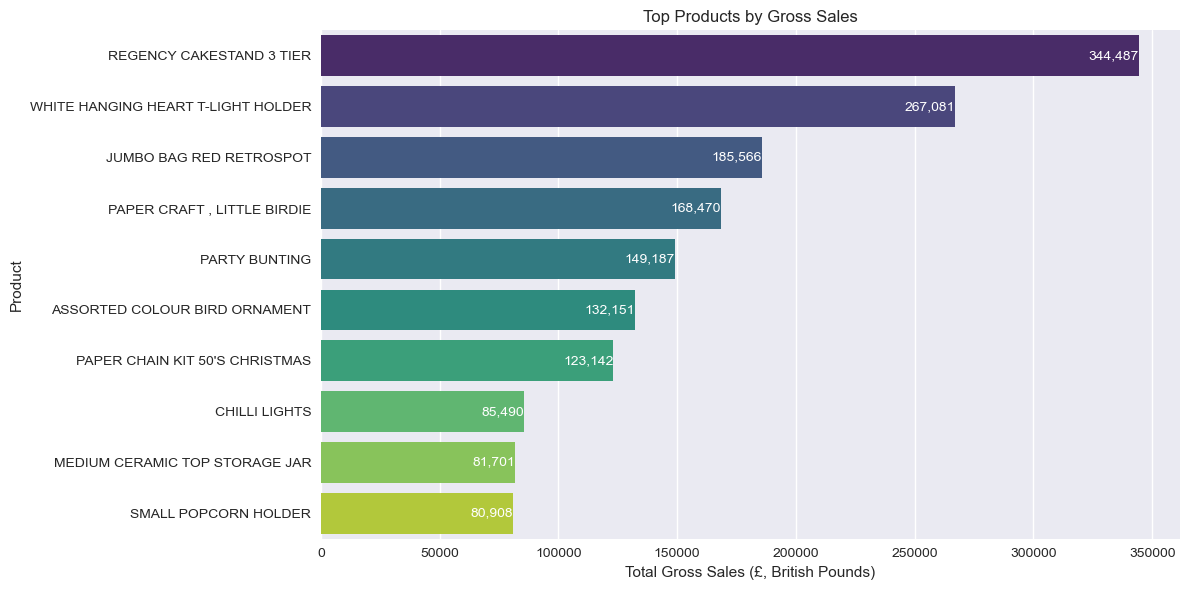

In [6]:
# Converting values back to float
try:
    top_products_gsales['Total Gross Sales'] = top_products_gsales['Total Gross Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validating DataFrame integrity for the plot
df_check(top_products_gsales, col_num='Total Gross Sales', col_text='Description', negative=False)

# Creating barplot
plt.figure(figsize=(12, 6))
ax=sns.barplot(
    data=top_products_gsales,
    y= 'Description',
    x='Total Gross Sales',
    hue='Description',
    palette='viridis',
    legend=False
)

# Adding data labels
for i, value in enumerate(top_products_gsales['Total Gross Sales']):
    ax.text(value-1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Customizing chart format
plt.title('Top Products by Gross Sales')
plt.xlabel('Total Gross Sales (£, British Pounds)')
plt.ylabel('Product')
plt.tight_layout()
plt.show()        

We can observe that:

- The product **"REGENCY CAKESTAND 3 TIER"** clearly stands out as the **best-selling item**, exceeding £344k.
- It is followed by **"WHITE HANGING HEART T-LIGHT HOLDER"**, with over £267k.
- Starting from the **third place**, the **sales amount decreases progressively**, showing a long tail of popular products but with **less individual impact**.

This chart helps quickly identify which products are the most important in terms of gross revenue, which can be useful for stock strategies, promotions, or bundles.


To gain a more complete view of sales behavior, I also run a query to identify the **top 10 products by units sold**, excluding returns.

In [7]:
# Getting products by units sold (excluding returns)
query = """
SELECT
    "Description",
    SUM("Quantity") AS "Units Sold",
    SUM("LineTotal") AS "Total Gross Sales"
FROM retail
WHERE "Quantity" > 0
GROUP BY "Description"
ORDER BY "Units Sold" DESC;
"""

# Converting query result into a DataFrame
products_gunits = pd.read_sql_query(query, engine)

# Copying DataFrame and showing the top 10
top_products_gunits = products_gunits.head(10).copy()

# Formatting columns and displaying results
top_products_gunits['Units Sold'] = top_products_gunits['Units Sold'].map('{:,.0f}'.format)
top_products_gunits['Total Gross Sales'] = top_products_gunits['Total Gross Sales'].map('{:,.0f}'.format)
display(top_products_gunits)

Description Units Sold Total Gross Sales
0   WORLD WAR 2 GLIDERS ASSTD DESIGNS    110,042            25,232
1             JUMBO BAG RED RETROSPOT     98,768           185,566
2  WHITE HANGING HEART T-LIGHT HOLDER     96,737           267,081
3     PACK OF 72 RETROSPOT CAKE CASES     96,499            52,964
4                SMALL POPCORN HOLDER     89,883            80,908
5       ASSORTED COLOUR BIRD ORNAMENT     81,787           132,151
6         PAPER CRAFT , LITTLE BIRDIE     80,995           168,470
7      MEDIUM CERAMIC TOP STORAGE JAR     78,033            81,701
8                  BROCADE RING PURSE     71,430            14,959
9  PACK OF 60 PINK PAISLEY CAKE CASES     56,720            28,450

The table reveals an interesting insight: the product with the highest unit sales does not match the one with the highest monetary sales.

In this case, the most popular product, **"WORLD WAR 2 GLIDERS ASSTD DESIGNS"**, with **110,042 units sold**, generates only around **£25k in gross sales**.  

Additionally, only 6 products appear simultaneously in both the Top 10 by units sold and the Top 10 by monetary value, highlighting **significant differences between popularity and economic contribution**.

#### 3.2. Net sales

In this section, I obtain the **products** with the **highest total net sales**, meaning **including returns**. To achieve this:

- Query the database and calculate the total value of orders (`LineTotal`) per product with the alias *"Total Net Sales"*.  
- Convert the result into a DataFrame and select the top 10 products by net sales.  
- Finally, plot the results in a horizontal bar chart to make the comparison easier to visualize.

In [8]:
# Getting products by net sales (including returns)
query = """
SELECT
    "Description",
    SUM("Quantity") AS "Units Sold",
    SUM("LineTotal") AS "Total Net Sales"
FROM retail
GROUP BY "Description"
ORDER BY SUM("LineTotal") DESC;
"""

# Converting query result into a DataFrame
products_nsales = pd.read_sql_query(query, engine)

# Copying DataFrame and showing the top 10
top_products_nsales = products_nsales.head(10).copy()

# Formatting columns and displaying results
top_products_nsales['Units Sold'] = top_products_nsales['Units Sold'].map('{:,.0f}'.format)
top_products_nsales['Total Net Sales'] = top_products_nsales['Total Net Sales'].map('{:,.0f}'.format)
display(top_products_nsales)

Description Units Sold Total Net Sales
0             REGENCY CAKESTAND 3 TIER     26,103         327,737
1   WHITE HANGING HEART T-LIGHT HOLDER     93,099         257,692
2              JUMBO BAG RED RETROSPOT     97,551         183,390
3                        PARTY BUNTING     28,093         147,948
4        ASSORTED COLOUR BIRD ORNAMENT     81,276         131,377
5       PAPER CHAIN KIT 50'S CHRISTMAS     35,985         121,662
6                        CHILLI LIGHTS     16,695          84,854
7                 SMALL POPCORN HOLDER     89,074          80,287
8              JUMBO BAG PINK POLKADOT     39,358          76,245
9  ROTATING SILVER ANGELS T-LIGHT HLDR     13,774          73,812

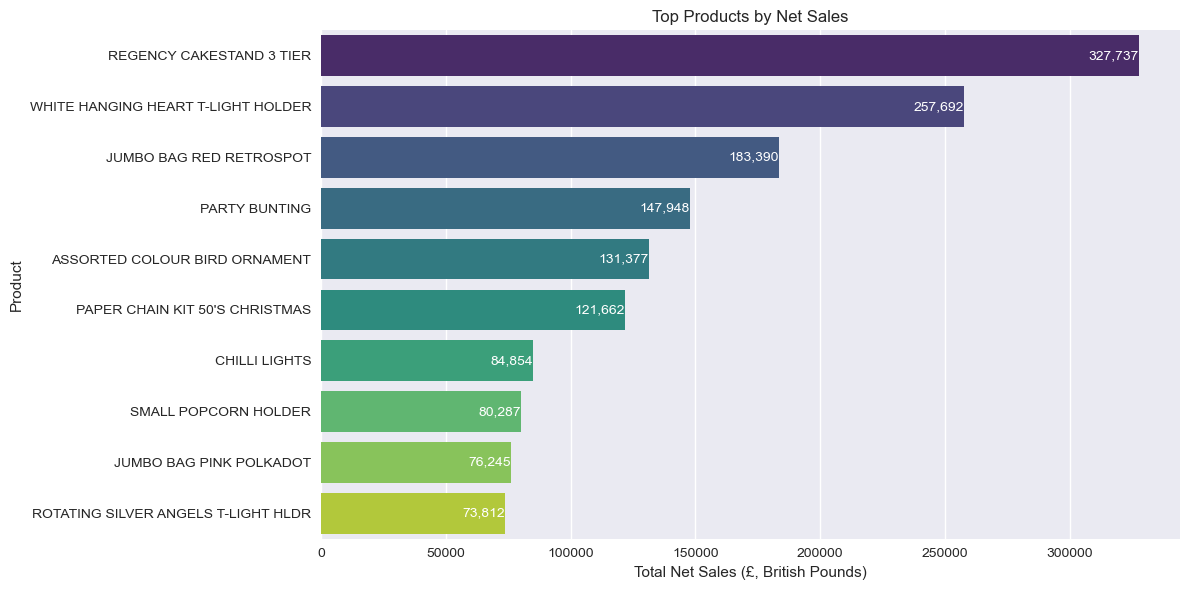

In [9]:
# Converting values back to float
try:
    top_products_nsales['Total Net Sales'] = top_products_nsales['Total Net Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validating integrity
df_check(top_products_nsales, col_num='Total Net Sales', col_text='Description', negative=True)

# Creating barplot
plt.figure(figsize=(12, 6))
ax=sns.barplot(
    data=top_products_nsales,
    x='Total Net Sales',
    y='Description',
    hue='Description',
    palette='viridis',
    legend=False
)

# Adding data labels
for i, value in enumerate(top_products_nsales['Total Net Sales']):
    ax.text(value-1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Customizing chart format
plt.title('Top Products by Net Sales')
plt.xlabel('Total Net Sales (£, British Pounds)')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

We can observe, as with gross sales, that:

- The product **"REGENCY CAKESTAND 3 TIER"** clearly stands out as the best seller, exceeding £327k.
- It is followed by **"WHITE HANGING HEART T-LIGHT HOLDER"**, with over £257k.
- From the **third place onward**, the **sales amount decreases progressively**. However, while the **first three products** remain the **top sellers**, in both charts, this table shows different products in positions 4 through 10, since this view considers the impact of returns on sales.

This chart helps identify which products are the most important in terms of actual sales.

In the same way, I run a query to identify the products with the **highest number of units sold** after accounting for returns.

In [10]:
# Getting products by units sold (including returns)
query = """
SELECT
    "Description",
    SUM("Quantity") AS "Units Sold",
    SUM("LineTotal") AS "Total Net Sales"
FROM retail
GROUP BY "Description"
ORDER BY "Units Sold" DESC;
"""

# Converting query result into a DataFrame
products_nunits = pd.read_sql_query(query, engine)

# Copying DataFrame and showing the top 10
top_products_nunits = products_nunits.head(10).copy()

# Formatting columns and displaying results
top_products_nunits['Units Sold'] = top_products_nunits['Units Sold'].map('{:,.0f}'.format)
top_products_nunits['Total Net Sales'] = top_products_nunits['Total Net Sales'].map('{:,.0f}'.format)
display(top_products_nunits)

Description Units Sold Total Net Sales
0   WORLD WAR 2 GLIDERS ASSTD DESIGNS    108,338          24,870
1             JUMBO BAG RED RETROSPOT     97,551         183,390
2     PACK OF 72 RETROSPOT CAKE CASES     95,389          52,414
3  WHITE HANGING HEART T-LIGHT HOLDER     93,099         257,692
4                SMALL POPCORN HOLDER     89,074          80,287
5       ASSORTED COLOUR BIRD ORNAMENT     81,276         131,377
6                  BROCADE RING PURSE     70,690          14,743
7  PACK OF 60 PINK PAISLEY CAKE CASES     56,501          28,333
8         60 TEATIME FAIRY CAKE CASES     54,220          27,136
9              MINI PAINT SET VINTAGE     45,384          28,864

This table shows that the best-selling product is still **"WORLD WAR 2 GLIDERS ASSTD DESIGNS"**, even after considering returns.

It is followed in the ranking by **"WHITE HANGING HEART T-LIGHT HOLDER"**, the same as in the list without returns.

It is important to highlight that the other positions are affected by the impact of returns: now only four products coincide with the Top 10 of highest net sales.

#### 3.3. Sales comparison

For this last section of Question 1, I **combine both tables** to obtain a more complete view of sales behavior, comparing the value of the products sold with the value that actually remains in the company after considering returns.  

This procedure will serve as the **basis for the comparative analyses** that will be carried out in the following sections. The steps followed are:  

- Create **copies of the original DataFrames** to preserve the initial queries and apply transformations without altering the source data.  
- Combine both DataFrames into one that will serve as the basis for the joint visualization.  
- Convert the numeric values back to `float` to ensure **accurate calculations and visualizations**.  
- Finally, plot the comparison in a **grouped barplot**, clearly showing the **difference** between gross sales and net sales for each product.  

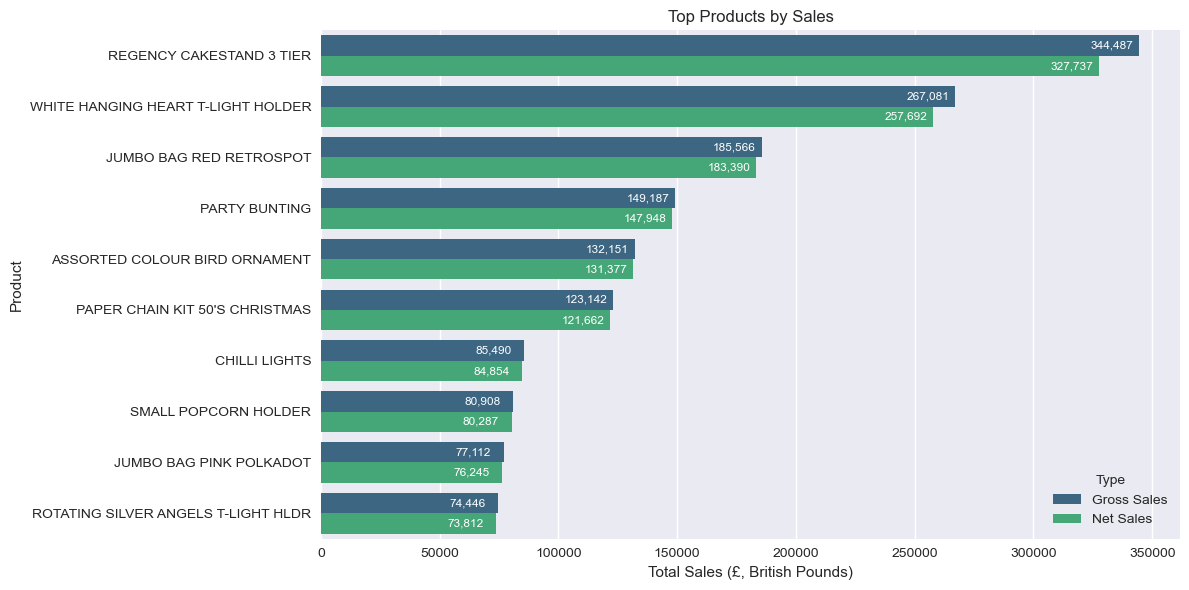

In [11]:
# Copying original DataFrames for transformation
pgs = products_gsales.copy()
pns = products_nsales.copy()

# Merging gross and net sales by product and rename columns
merged_prod = pd.merge(pns, pgs, on='Description', how='left')
merged_prod = merged_prod.rename(columns={
    'Total Net Sales': 'Net Sales',
    'Total Gross Sales': 'Gross Sales'
})

# Converting values to float
try:
    for col in ['Net Sales', 'Gross Sales']:
        merged_prod[col] = merged_prod[col].str.replace(',','').astype(float)
except AttributeError:
    pass

# Creating DataFrame with top 10 and converting it to long format
top_10_prod = merged_prod.sort_values(by='Net Sales', ascending=False).head(10)
top_products_sales = top_10_prod.melt(
    id_vars='Description',
    value_vars=['Net Sales', 'Gross Sales'],
    var_name='Type',
    value_name='Total Sales'
)

# Validating integrity
df_check(top_products_sales, col_num='Total Sales', col_text=['Description', 'Type'], negative=True)

# Creating grouped barplot
plt.figure(figsize=(12,6))
ax=sns.barplot(
    data=top_products_sales,
    x='Total Sales',
    y='Description',
    hue='Type',
    hue_order=['Gross Sales', 'Net Sales'],
    palette='viridis'
)

# Adding data labels
for container in ax.containers:
    ax.bar_label(container, labels=[f'{v.get_width():,.0f}' for v in container], 
                 label_type='edge', padding=-35, fontsize=8.5, color='white')

# Customizing chart format
plt.title('Top Products by Sales')
plt.xlabel('Total Sales (£, British Pounds)')
plt.ylabel('Product')
plt.legend(title='Type')
plt.tight_layout()
plt.show()

This chart shows the **large sales difference** that the **top two products** have compared to the rest.

In addition, we can observe that the difference between gross and net sales for each product is **not significant** overall. However, it is more noticeable for the first two products, which can be explained by their **high sales volume**.

---
### 4. Question 2: Which countries generate the highest sales?

#### 4.1. Gross sales

To answer this question, I run an SQL query that returns the top 10 **countries** with the **highest total gross sales** and their percentage relative to total gross sales. Then, I display the results in a horizontal barplot.

In [12]:
# Getting countries by gross sales and their percentage of the total
query = """
SELECT 
    "Country",
    SUM("LineTotal") AS "Total Gross Sales",
    ROUND(100.0 * SUM("LineTotal") / (
        SELECT SUM("LineTotal")
        FROM retail
        WHERE "Quantity" > 0
        ), 2) AS "Percentage of Total"
FROM retail
WHERE "Quantity" > 0
GROUP BY "Country"
ORDER BY SUM("LineTotal") DESC;
"""

# Converting query result into a DataFrame
countries_gsales = pd.read_sql_query(query, engine)

# Copying DataFrame and showing the top 10
top_countries_gsales = countries_gsales.head(10).copy()

# Formatting columns and displaying results
top_countries_gsales['Total Gross Sales'] = top_countries_gsales['Total Gross Sales'].map('{:,.0f}'.format)
top_countries_gsales['Percentage of Total'] = top_countries_gsales['Percentage of Total'].map('{:,.2f} %'.format)
display(top_countries_gsales)

Country Total Gross Sales Percentage of Total
0  United Kingdom        17,235,543             85.70 %
1         Ireland           638,934              3.18 %
2     Netherlands           549,953              2.73 %
3         Germany           388,830              1.93 %
4          France           317,345              1.58 %
5       Australia           168,485              0.84 %
6           Spain            98,613              0.49 %
7     Switzerland            94,270              0.47 %
8          Sweden            86,353              0.43 %
9         Denmark            68,560              0.34 %

Because of the **large difference** in sales between the first country and the others, I formatted the chart’s **x-axis** with a **logarithmic scale** to make the visualization easier to read.

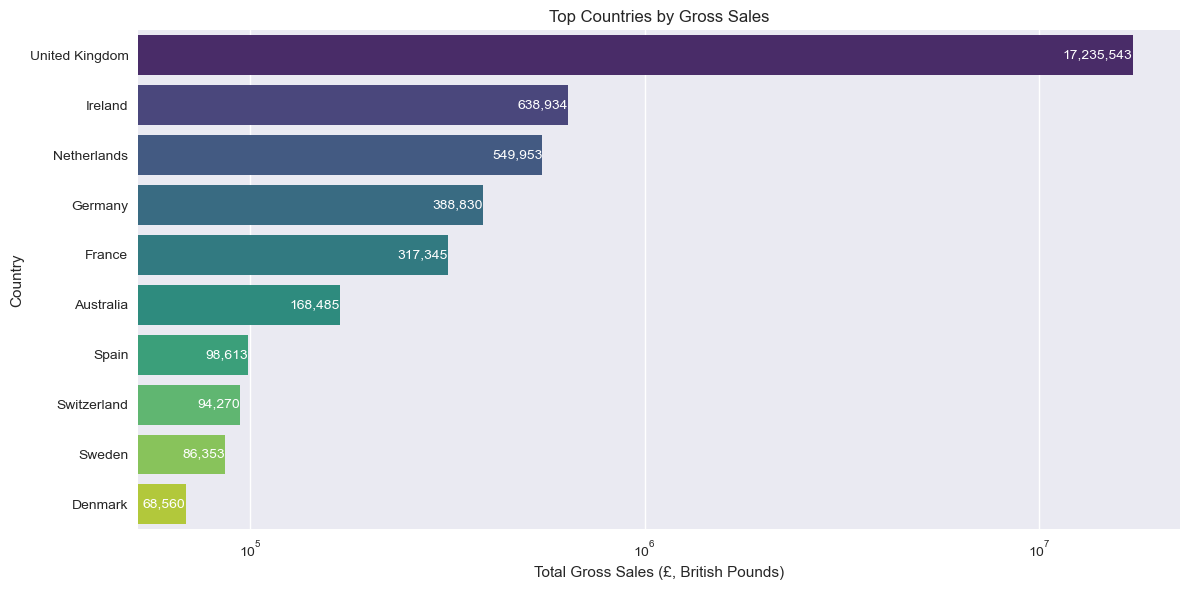

In [13]:
# Converting values back to float
try:
    top_countries_gsales['Total Gross Sales'] = top_countries_gsales['Total Gross Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validating integrity
df_check(top_countries_gsales, col_num='Total Gross Sales', col_text='Country', negative=False)

# Creating barplot
plt.figure(figsize=(12, 6)) 
ax=sns.barplot(
    data=top_countries_gsales,
    y='Country',
    x='Total Gross Sales', 
    hue='Country',
    palette='viridis',
    legend=False
)

# Setting logarithmic scale for readability
ax.set_xscale('log')

# Adding data labels
for i, value in enumerate(top_countries_gsales['Total Gross Sales']):
    ax.text(value-1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10, color='white')

# Customizing chart format
plt.title('Top Countries by Gross Sales')
plt.xlabel('Total Gross Sales (£, British Pounds)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

The chart shows that:

- **United Kingdom** accounts for nearly all gross sales, exceeding **£17 million** and representing approximately **86% of total gross sales** clearly positioning it as the **main market**.
- **Ireland** takes second place with only about **£639k** far below the sales leader.

#### 4.2. Net sales

There is not much variation in the SQL query for net sales.  

In [14]:
# Getting countries by net sales and their percentage of the total
query = """
SELECT 
    "Country",
    SUM("LineTotal") AS "Total Net Sales",
    ROUND(100.0 * SUM("LineTotal") / (
        SELECT SUM("LineTotal")
        FROM retail
        ), 2) AS "Percentage of Total"
FROM retail
GROUP BY "Country"
ORDER BY SUM("LineTotal") DESC;
"""

# Converting query result into a DataFrame
countries_nsales = pd.read_sql_query(query, engine)

# Copying DataFrame and showing the top 10
top_countries_nsales = countries_nsales.head(10).copy()

# Formatting columns and displaying results
top_countries_nsales['Total Net Sales'] = top_countries_nsales['Total Net Sales'].map('{:,.0f}'.format)
top_countries_nsales['Percentage of Total'] = top_countries_nsales['Percentage of Total'].map('{:,.2f} %'.format)
display(top_countries_nsales)

Country Total Net Sales Percentage of Total
0  United Kingdom      16,593,572             85.61 %
1         Ireland         618,472              3.19 %
2     Netherlands         546,275              2.82 %
3         Germany         379,901              1.96 %
4          France         299,656              1.55 %
5       Australia         166,967              0.86 %
6     Switzerland          93,164              0.48 %
7           Spain          85,658              0.44 %
8          Sweden          84,379              0.44 %
9         Denmark          64,493              0.33 %

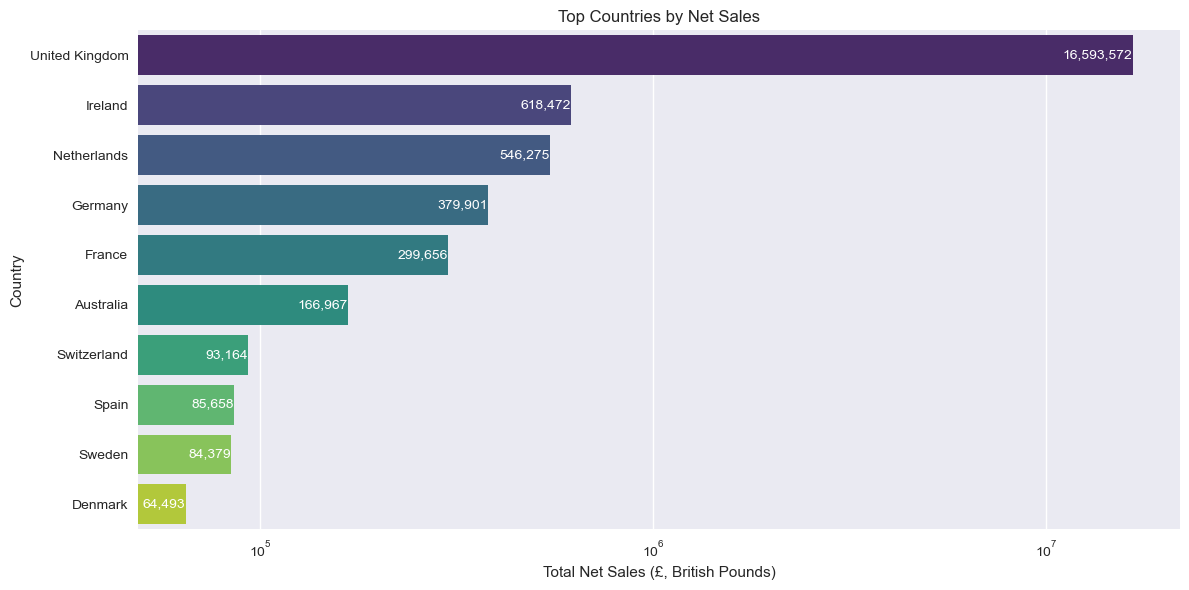

In [15]:
# Converting values back to float
try:
    top_countries_nsales['Total Net Sales'] = top_countries_nsales['Total Net Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validating integrity
df_check(top_countries_nsales, col_num='Total Net Sales', col_text='Country', negative=True)

# Creating barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_countries_nsales,
    y='Country',
    x='Total Net Sales',
    hue='Country',
    palette='viridis',
    legend=False
)

# Setting logarithmic scale for readability
ax.set_xscale('log')

# Adding data labels
for i, value in enumerate(top_countries_nsales['Total Net Sales']):
    ax.text(value - 1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Customizing chart format
plt.title('Top Countries by Net Sales')
plt.xlabel('Total Net Sales (£, British Pounds)')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

As in the previous chart, we can observe that:

- **United Kingdom** is clearly the leader in total net sales, far above the second place **Ireland**, with an approximate difference of **£16 million**.
- In both cases, the **rest of the Top 5** is completed by the Netherlands, Germany, and France.
- **Switzerland** surpasses **Spain** in net sales, the opposite of what was shown in gross sales. This suggests a higher volume of returns for Spain.

#### 4.3. Sales comparison

For the comparison of sales between countries, I follow the **same procedure** as in the previous question. Both DataFrames are combined into one so that **both metrics** can be visualized at the same time in the chart.

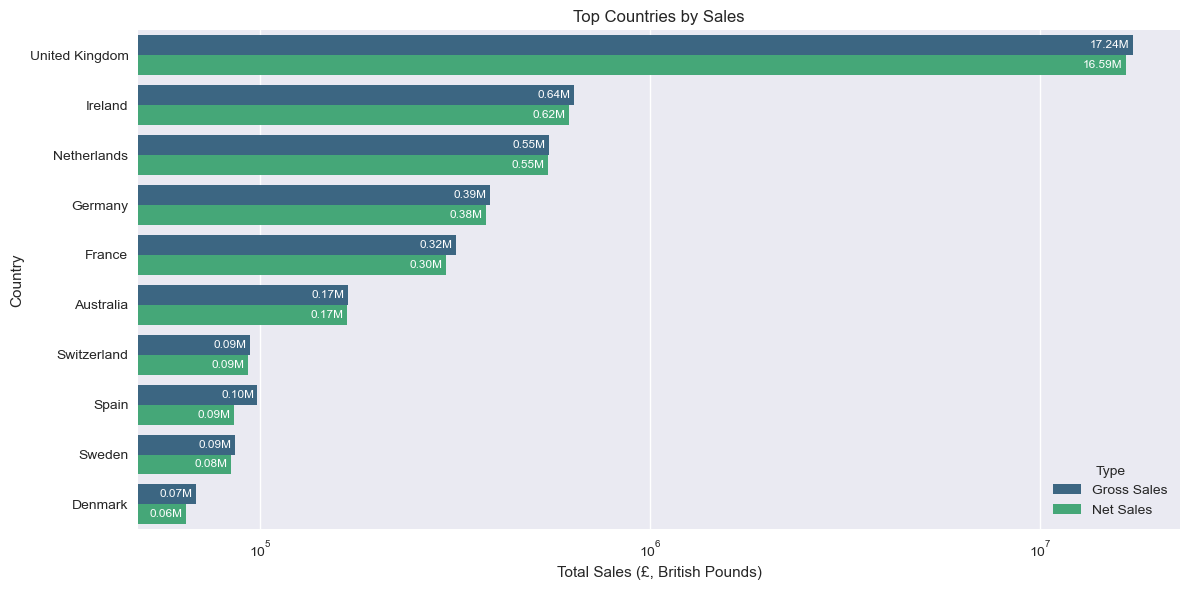

In [16]:
# Copying original DataFrames for transformation
cns = countries_nsales.copy()
cgs = countries_gsales.copy()

# Merging gross and net sales by country and renaming columns
merged_countries = pd.merge(cns, cgs, on='Country', how='left')
merged_countries = merged_countries.rename(columns={
    'Total Net Sales': 'Net Sales',
    'Total Gross Sales': 'Gross Sales'
})

# Converting values to float
try:
    for col in ['Net Sales', 'Gross Sales']:
        merged_countries[col] = merged_countries[col].str.replace(',','').astype(float)
except AttributeError:
    pass

# Creating DataFrame with the top 10 and convert to long format
top_10_countries = merged_countries.sort_values(by='Net Sales', ascending=False).head(10)
top_countries_sales = top_10_countries.melt(
    id_vars='Country',
    value_vars=['Net Sales', 'Gross Sales'],
    var_name='Type',
    value_name='Total Sales'
)

# Validating integrity
df_check(top_countries_sales, col_num='Total Sales', col_text=['Country', 'Type'], negative=True)

# Creating grouped barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_countries_sales,
    x='Total Sales',
    y='Country',
    hue='Type',
    hue_order=['Gross Sales', 'Net Sales'],
    palette='viridis'
)

# Setting logarithmic scale for readability
ax.set_xscale('log')

# Adding data labels
for container in ax.containers:
    for bar in container:
        value=bar.get_width()
        offset=value * 0.02
        ax.text(value - offset, bar.get_y() + bar.get_height() / 2, f'{value/1e6:.2f}M',
                va='center', ha='right', fontsize=8.5, color='white')

# Customizing chart format
plt.title('Top Countries by Sales')
plt.xlabel('Total Sales (£, British Pounds)')
plt.ylabel('Country')
plt.legend(title='Type')
plt.tight_layout()
plt.show()      

The chart provides a broader view of the **sales volume by country**. There are not many more differences compared to the previous charts. However, one aspect that **stands out** here is the **larger proportional gap** between gross and net sales in **Spain**, which reveals a high number of **returns** in that country.

---
### 5. Question 3: How have sales evolved over time (by month)?

#### 5.1. Gross sales

I run an SQL query to obtain the **total gross sales for each month of the year** in the full DataFrame. This is possible thanks to the `Year_Month` column created in the previous **data exploration and cleaning step**.

In [17]:
# Getting gross sales by month
query = """
SELECT "Year_Month" AS "Period",
    SUM("LineTotal") AS "Total Gross Sales"
FROM retail
WHERE "Quantity" > 0
GROUP BY "Period"
ORDER BY "Period" ASC;
"""

# Converting query to DataFrame, formatting it, and displaying results
gsales_by_month = pd.read_sql_query(query, engine)
gsales_by_month['Total Gross Sales'] = gsales_by_month['Total Gross Sales'].map('{:,.0f}'.format)
display(gsales_by_month)

Period Total Gross Sales
0   2009-12-01           801,603
1   2010-01-01           612,966
2   2010-02-01           539,945
3   2010-03-01           764,734
4   2010-04-01           649,091
5   2010-05-01           645,895
6   2010-06-01           699,766
7   2010-07-01           633,277
8   2010-08-01           676,711
9   2010-09-01           870,350
10  2010-10-01         1,098,868
11  2010-11-01         1,436,505
12  2010-12-01         1,188,008
13  2011-01-01           672,133
14  2011-02-01           509,101
15  2011-03-01           692,008
16  2011-04-01           516,164
17  2011-05-01           740,558
18  2011-06-01           738,579
19  2011-07-01           687,707
20  2011-08-01           725,164
21  2011-09-01         1,030,999
22  2011-10-01         1,107,250
23  2011-11-01         1,457,555
24  2011-12-01           615,543

Transforming the data for the *lineplot* involved some additional steps compared to the *barplots* shown earlier.

In this case, to avoid cluttering the visualization, I decided to show **data labels** only for the **top three and bottom three months** by sales volume.

To achieve the final result, the chart is composed of a *lineplot* that represents the overall sales trend, complemented by three *scatterplots* that highlight these key points without overloading the visualization with labels on every value.

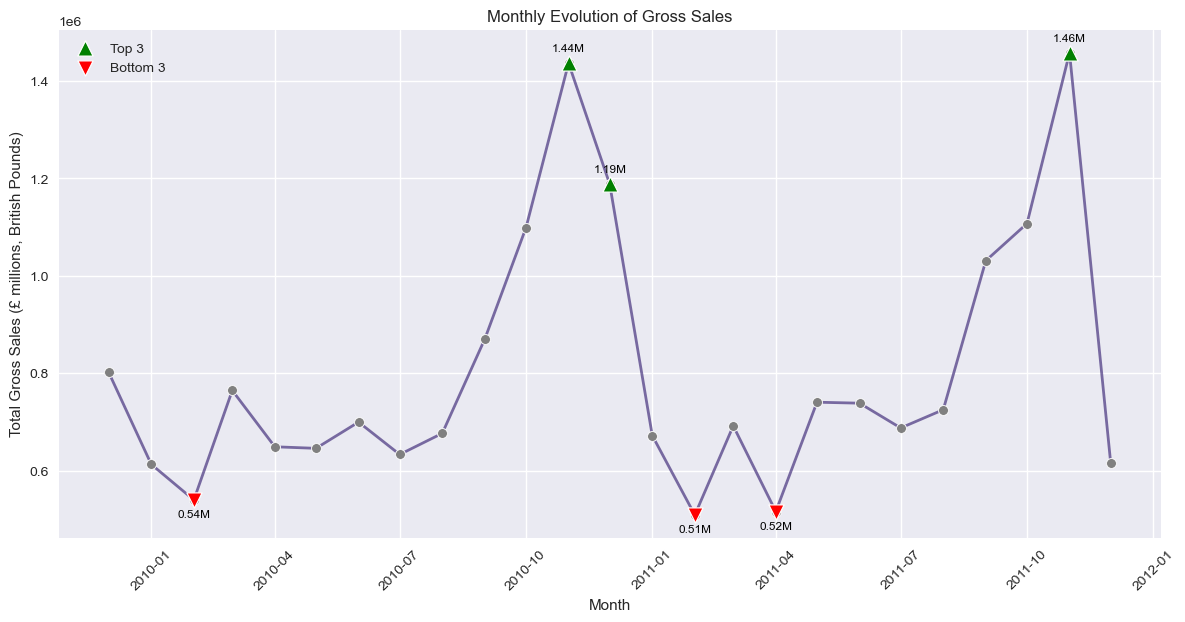

In [18]:
# Converting values back to float
try:
    gsales_by_month['Total Gross Sales'] = gsales_by_month['Total Gross Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Converting months to datetime format
gsales_by_month['Period'] = pd.to_datetime(gsales_by_month['Period'], format='%Y-%m-%d')

# Selecting the 3 months with highest and lowest gross sales
top3_gsales = gsales_by_month.nlargest(3, 'Total Gross Sales')
bottom3_gsales = gsales_by_month.nsmallest(3, 'Total Gross Sales')

# Validating integrity
df_check(gsales_by_month, col_num='Total Gross Sales', col_date='Period', negative=False)

# Creating lineplot
plt.figure(figsize=(12, 6))
ax=sns.lineplot(
    data=gsales_by_month,
    x='Period',
    y='Total Gross Sales',
    marker='o',
    color='C0',
    linewidth=2,
    alpha=0.7,
    zorder=1
)

# Plotting all data points
sns.scatterplot(
    data=gsales_by_month, x='Period', y='Total Gross Sales', color='gray', s=50, ax=ax, zorder=2
)

# Plotting Top 3 months (green, upward triangles)
sns.scatterplot(
    data=top3_gsales, x='Period', y='Total Gross Sales', color='green', s=120, marker='^', label='Top 3', ax=ax, zorder=5
)

# Plotting Bottom 3 months (red, downward triangles)
sns.scatterplot(
    data=bottom3_gsales, x='Period', y='Total Gross Sales', color='red', s=120, marker='v', label='Bottom 3', ax=ax, zorder=5
)

# Adding labels for Top 3
for i, row in top3_gsales.iterrows():
    date = row['Period']
    value = row['Total Gross Sales']
    ax.text(date, value+20000, f'{value/1e6:.2f}M',
            ha='center', va='bottom', fontsize=8.5, color='black')

# Adding labels for Bottom 3
for i, row in bottom3_gsales.iterrows():
    date = row['Period']
    value = row['Total Gross Sales']
    ax.text(date, value-20000, f'{value/1e6:.2f}M',
            ha='center', va='top', fontsize=8.5, color='black')

# Customizing chart format
plt.title('Monthly Evolution of Gross Sales')
plt.xlabel('Month')
plt.ylabel('Total Gross Sales (£ millions, British Pounds)')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

The evolution of gross sales follows an **almost cyclical pattern** (to be analyzed in more detail in a later question), with **considerable peaks** in November and **sharp declines** at the beginning of the year.

#### 5.2. Net sales

Similar to the previous query for gross sales, I obtain the **total net sales for each month of the year**, ordered in ascending order, and display the results using a *lineplot*.

In [19]:
# Getting net sales by month
query = """
SELECT "Year_Month" AS "Period",
    SUM("LineTotal") AS "Total Net Sales"
FROM retail
GROUP BY "Period"
ORDER BY "Period" ASC;
"""

# Converting query to DataFrame, formatting it, and displaying results
nsales_by_month = pd.read_sql_query(query, engine)
nsales_by_month['Total Net Sales'] = nsales_by_month['Total Net Sales'].map('{:,.0f}'.format)
display(nsales_by_month)

Period Total Net Sales
0   2009-12-01         782,042
1   2010-01-01         605,500
2   2010-02-01         527,360
3   2010-03-01         755,027
4   2010-04-01         639,066
5   2010-05-01         608,601
6   2010-06-01         673,372
7   2010-07-01         616,144
8   2010-08-01         664,292
9   2010-09-01         842,582
10  2010-10-01       1,073,243
11  2010-11-01       1,401,345
12  2010-12-01       1,163,537
13  2011-01-01         580,557
14  2011-02-01         500,725
15  2011-03-01         681,332
16  2011-04-01         482,847
17  2011-05-01         731,609
18  2011-06-01         724,812
19  2011-07-01         676,313
20  2011-08-01         702,235
21  2011-09-01       1,013,954
22  2011-10-01       1,063,258
23  2011-11-01       1,432,544
24  2011-12-01         441,417

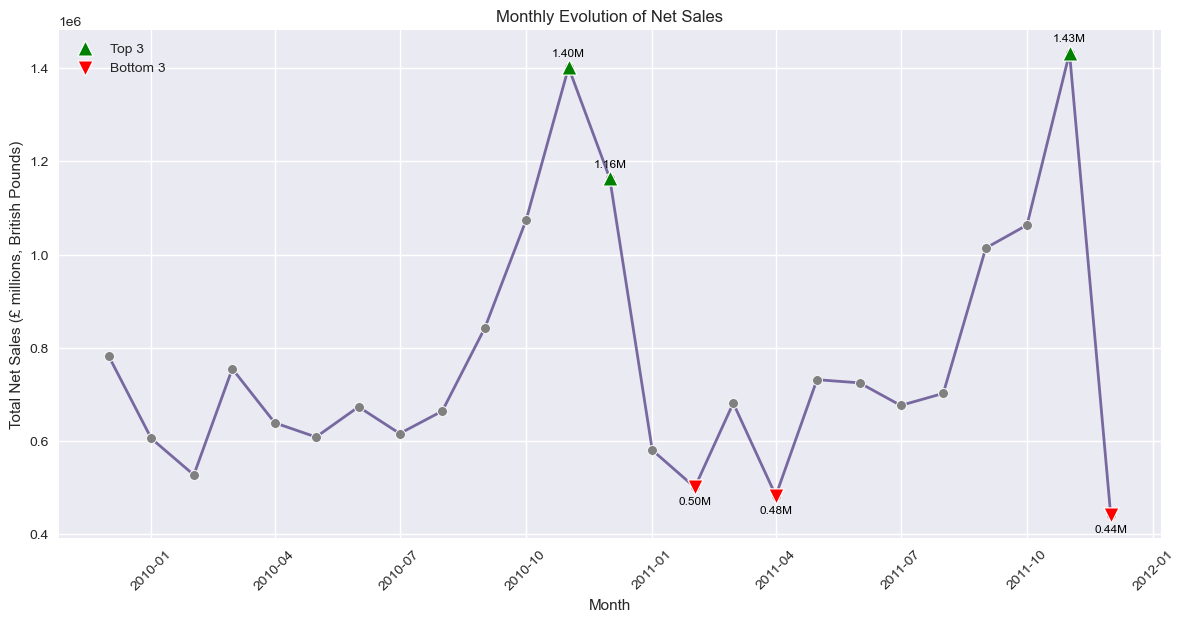

In [20]:
# Converting values back to float
try:
    nsales_by_month['Total Net Sales'] = nsales_by_month['Total Net Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Converting months to datetime format
nsales_by_month['Period'] = pd.to_datetime(nsales_by_month['Period'], format='%Y-%m-%d')

# Selecting the 3 months with highest and lowest net sales
top3_nsales= nsales_by_month.nlargest(3, 'Total Net Sales')
bottom3_nsales= nsales_by_month.nsmallest(3, 'Total Net Sales')

# Validating integrity
df_check(nsales_by_month, col_num='Total Net Sales', col_date='Period', negative=True)

# Creating lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=nsales_by_month,
    x='Period',
    y='Total Net Sales',
    marker='o',
    color='C0',
    linewidth=2,
    alpha=0.7,
    zorder=1
)

# Plotting all data points
sns.scatterplot(
    data=nsales_by_month, x='Period', y='Total Net Sales', color='gray', s=50, ax=ax, zorder=2
)

# Plotting Top 3 points
sns.scatterplot(
    data=top3_nsales, x='Period', y='Total Net Sales', color='green', s=120, marker='^', label='Top 3', ax=ax, zorder=5
)

# Plotting Bottom 3 points
sns.scatterplot(
    data=bottom3_nsales, x='Period', y='Total Net Sales', color='red', s=120, marker='v', label='Bottom 3', ax=ax, zorder=5
)

# Adding labels for Top 3
for i, row in top3_nsales.iterrows():
    date = row['Period']
    value = row['Total Net Sales']
    ax.text(date, value+20000, f'{value/1e6:.2f}M',
            va='bottom', ha='center', fontsize=8.5, color='black')

# Adding labels for Bottom 3
for i, row in bottom3_nsales.iterrows():
    date = row['Period']
    value = row['Total Net Sales']
    ax.text(date, value-20000, f'{value/1e6:.2f}M',
            va='top', ha='center', fontsize=8.5, color='black')

# Customizing chart format
plt.title('Monthly Evolution of Net Sales')
plt.xlabel('Month')
plt.ylabel('Total Net Sales (£ millions, British Pounds)')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

There is not much difference compared to gross sales, except that in **December 2011** we see the month with the **lowest net sales volume**, driven  by **returns**.

#### 5.3. Sales comparison

To perform the **comparison** between the evolution of gross and net sales, I follow the same procedure as in previous cases. However, to better **visualize the difference** between both graphs, I use a *fill between* that **shades** the area between the two lines.  

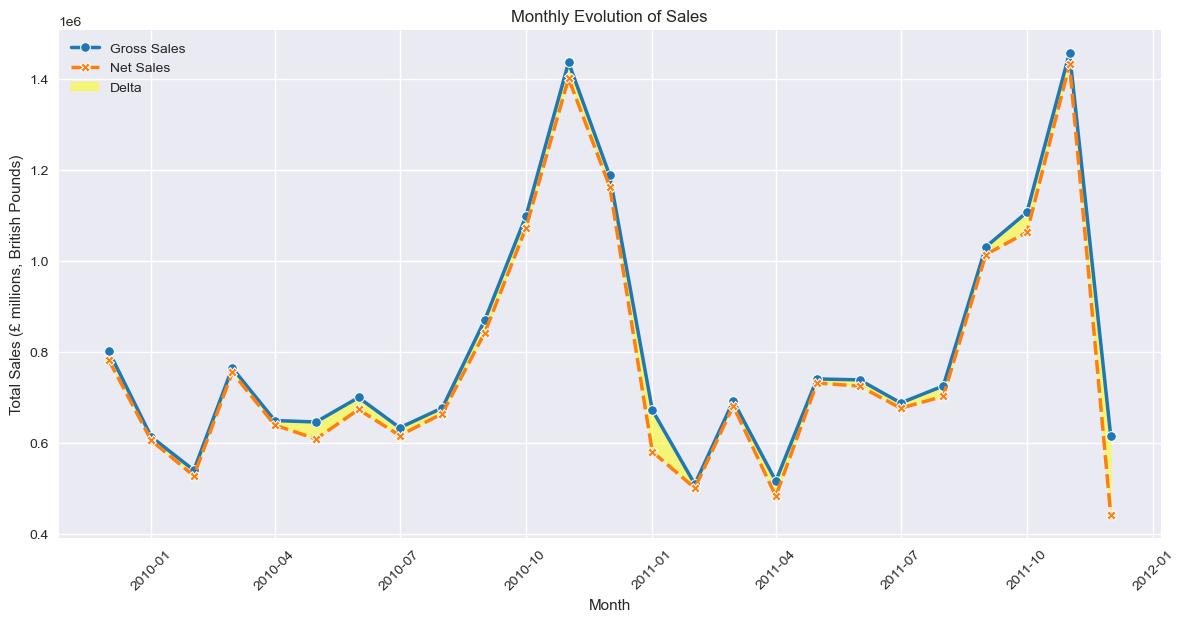

In [21]:
# Copying original DataFrames for transformation
gsales = gsales_by_month.copy()
nsales = nsales_by_month.copy()

# Merging gross and net sales by period and renaming columns
merged_sales = pd.merge(nsales, gsales, on='Period', how='inner')
merged_sales = merged_sales.rename(columns={
    'Total Gross Sales': 'Gross Sales',
    'Total Net Sales': 'Net Sales'
})

# Creating long-format DataFrame
sales = merged_sales.melt(
    id_vars='Period',
    value_vars=['Gross Sales', 'Net Sales'],
    var_name='Type',
    value_name='Total Sales'
)

# Converting values to float
try:
    sales['Total Sales'] = sales['Total Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validating integrity
df_check(sales, col_num='Total Sales', col_text='Type', col_date='Period', negative=True)

# Creating lineplot
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=sales,
    x='Period',
    y='Total Sales',
    hue='Type',
    style='Type',
    markers=True,
    linewidth=2.5,
    palette=['#1f77b4', '#ff7f0e']
)

# Shading the difference area
plt.fill_between(
    merged_sales['Period'],
    merged_sales['Gross Sales'],
    merged_sales['Net Sales'],
    where=(merged_sales['Gross Sales'] > merged_sales['Net Sales']),
    interpolate=True,
    color='yellow',
    alpha=0.5,
    label='Delta'
)

# Customizing chart format
plt.title('Monthly Evolution of Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales (£ millions, British Pounds)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In this comparative chart, it can be seen that both gross and net sales follow **seasonal patterns** and that returns are not out of control nor do they significantly distort the chart. However, the shaded area highlights certain months where the **volume of returns** is larger than in others. It would be ideal to check whether this is due to **seasonal behavior** or possibly a **logistical issue**.

---
### 6. Question 4: Who are the top customers by sales?

#### 6.1. Gross sales

In this section, I follow the same procedure as before. I obtain the **general table** of total gross sales per customer (which will also be needed later for the **comparison** between gross and net sales) and transform a copy to display the top 10 **customers** with the highest volume of **total gross sales**. Finally, the results are displayed in a horizontal *barplot*.  

In [22]:
# Getting customers by gross sales and their percentage of the total
query = """
SELECT "Customer Label" AS "Customer",
    SUM("LineTotal") AS "Total Gross Sales",
    ROUND(100.0 * SUM("LineTotal") / (
        SELECT SUM("LineTotal")
        FROM retail
        ), 2) AS "Percentage of Total"
FROM retail
WHERE "Quantity" > 0
GROUP BY "Customer"
ORDER BY "Total Gross Sales" DESC;
"""

# Converting query result into a DataFrame
customers_gsales = pd.read_sql_query(query, engine)

# Copying DataFrame and showing the top 10
top_customers_gsales = customers_gsales.head(10).copy()

# Formatting columns and displaying results
top_customers_gsales['Total Gross Sales'] = top_customers_gsales['Total Gross Sales'].map('{:,.0f}'.format)
top_customers_gsales['Percentage of Total'] = top_customers_gsales['Percentage of Total'].map('{:,.2f} %'.format)
display(top_customers_gsales)

Customer Total Gross Sales Percentage of Total
0  unknown         2,674,191             13.80 %
1  18102.0           608,822              3.14 %
2  14646.0           526,752              2.72 %
3  14156.0           305,229              1.57 %
4  14911.0           284,030              1.47 %
5  17450.0           246,973              1.27 %
6  13694.0           196,483              1.01 %
7  17511.0           175,604              0.91 %
8  16446.0           168,472              0.87 %
9  16684.0           147,143              0.76 %

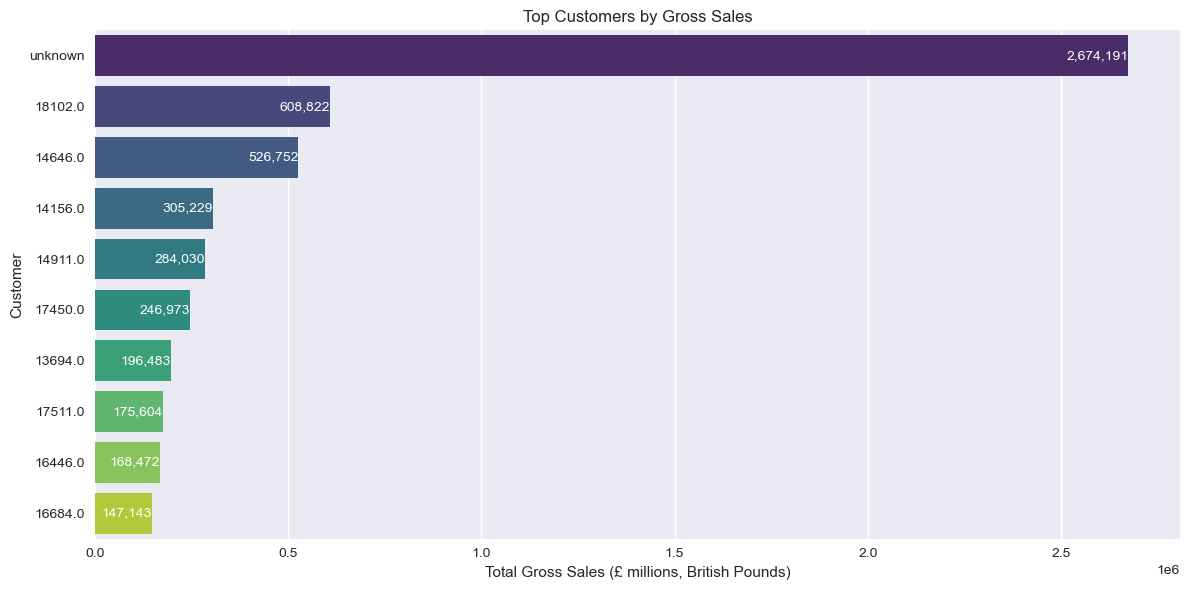

In [23]:
# Converting values back to float
try:
    top_customers_gsales['Total Gross Sales'] = top_customers_gsales['Total Gross Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validating integrity
df_check(top_customers_gsales, col_num='Total Gross Sales', col_text='Customer', negative=False)

# Creating barplot
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=top_customers_gsales,
    x='Total Gross Sales',
    y='Customer',
    hue='Customer',
    palette='viridis',
    legend=False
)

# Adding data labels
for i, value in enumerate(top_customers_gsales['Total Gross Sales']):
    ax.text(value - 1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Customizing chart format
plt.title('Top Customers by Gross Sales')
plt.xlabel('Total Gross Sales (£ millions, British Pounds)')
plt.ylabel('Customer')
plt.tight_layout()
plt.show()

The chart reveals an **important reality**, there are more than £2.6 million (13.80% of total gross sales) not assigned to any customer. The ***unknown*** customer is the top buyer, followed by customero ***18102*** with a considerable difference of more than **£2 million** between both positions.

Because such a **large portion** of sales is **not classified** by customer code, it becomes difficult to perform segmentation analysis or any other metric focused on determining customer behavior.

#### 6.2. Net sales

The query for net sales is similar to the previous one, and the results are also presented in a horizontal *barplot*.

In [24]:
# Getting customers by net sales and their percentage of the total
query = """
SELECT "Customer Label" AS "Customer",
    SUM("LineTotal") AS "Total Net Sales",
    ROUND(100.0 * SUM("LineTotal") / (
        SELECT SUM("LineTotal")
        FROM retail
        ), 2) AS "Percentage of Total"
FROM retail
GROUP BY "Customer Label"
ORDER BY "Total Net Sales" DESC;
"""

# Converting query result into a DataFrame
customers_nsales = pd.read_sql_query(query, engine)

# Copying DataFrame and showing the top 10
top_customers_nsales = customers_nsales.head(10).copy()

# Formatting columns and displaying results
top_customers_nsales['Total Net Sales'] = top_customers_nsales['Total Net Sales'].map('{:,.0f}'.format)
top_customers_nsales['Percentage of Total'] = top_customers_nsales['Percentage of Total'].map('{:,.2f} %'.format)
display(top_customers_nsales)

Customer Total Net Sales Percentage of Total
0  unknown       2,667,321             13.76 %
1  18102.0         606,243              3.13 %
2  14646.0         523,203              2.70 %
3  14156.0         299,926              1.55 %
4  14911.0         270,188              1.39 %
5  17450.0         235,833              1.22 %
6  13694.0         191,196              0.99 %
7  17511.0         171,899              0.89 %
8  12415.0         143,107              0.74 %
9  16684.0         141,530              0.73 %

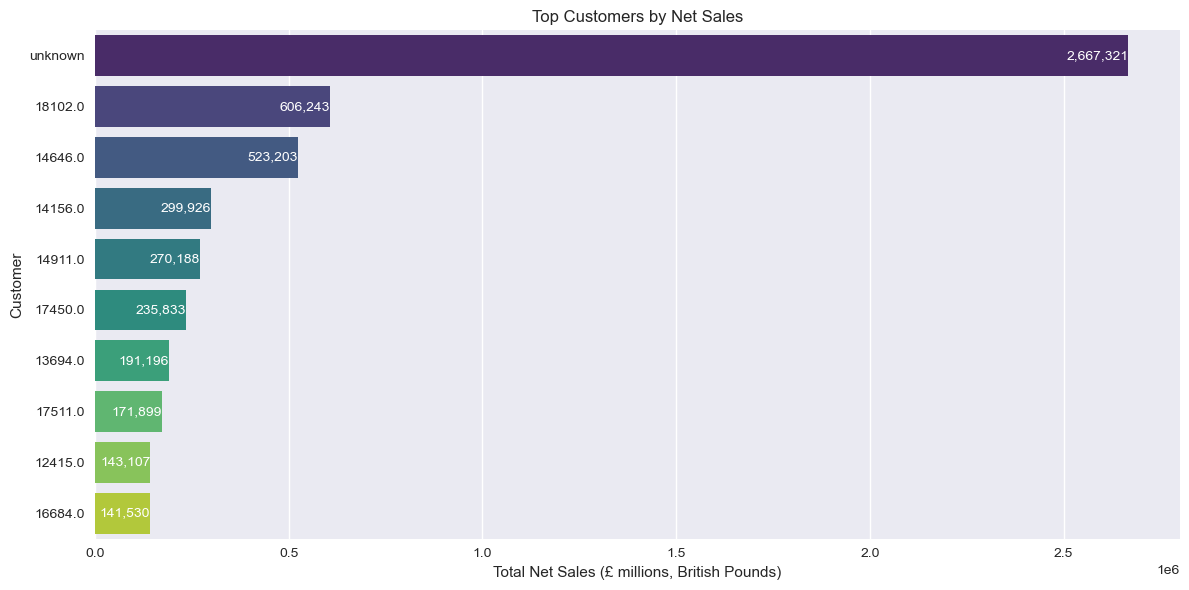

In [25]:
# Converting values back to float
try:
    top_customers_nsales['Total Net Sales'] = top_customers_nsales['Total Net Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validating integrity
df_check(top_customers_nsales, col_num='Total Net Sales', col_text='Customer', negative=True)

# Creating barplot
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=top_customers_nsales,
    x='Total Net Sales',
    y='Customer',
    hue='Customer',
    palette='viridis',
    legend=False
)

# Adding data labels
for i, value in enumerate(top_customers_nsales['Total Net Sales']):
    ax.text(value - 1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Customizing chart format
plt.title('Top Customers by Net Sales')
plt.xlabel('Total Net Sales (£ millions, British Pounds)')
plt.ylabel('Customer')
plt.tight_layout()
plt.show()

In this chart, there is not much difference compared to the gross sales chart. Sales **without a customer code** remain in the first place, and the other positions **do not really change**, except for the last two.

#### 6.3. Sales comparison

For the **comparison of gross and net sales**, I use the same methodology as in the previous questions. I combine both tables, perform the necessary data transformations for correct visualization, and finally plot the comparison in a grouped horizontal *barplot* to observe the difference between both amounts. 

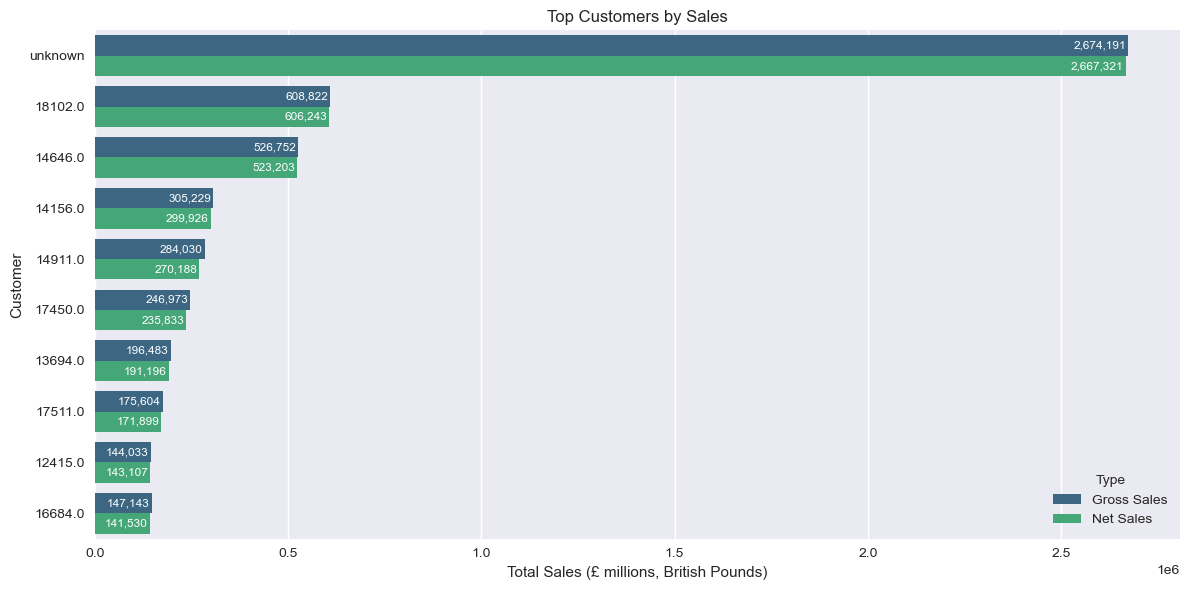

In [26]:
# Copying original DataFrames for transformation
cuns = customers_nsales.copy()
cugs = customers_gsales.copy()

# Merging gross and net sales by customer and renaming columns
merged_customers = pd.merge(cuns, cugs, on='Customer', how='left')
merged_customers = merged_customers.rename(columns={
    'Total Net Sales': 'Net Sales',
    'Total Gross Sales': 'Gross Sales'
})

# Converting values to float
try:
    for col in ['Net Sales', 'Gross Sales']:
        merged_customers[col] = merged_customers[col].str.replace(',','').astype(float)
except AttributeError:
    pass

# Creating DataFrame with the top 10 and converting it to long format
top10_customers = merged_customers.sort_values(by='Net Sales', ascending=False).head(10)
top_customers_sales = top10_customers.melt(
    id_vars='Customer',
    value_vars=['Net Sales', 'Gross Sales'],
    var_name='Type',
    value_name='Total Sales'
)

# Validating integrity
df_check(top_customers_sales, col_num='Total Sales', col_text=['Customer', 'Type'], negative=True)

# Creating barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_customers_sales,
    x='Total Sales',
    y='Customer',
    hue='Type',
    hue_order=['Gross Sales', 'Net Sales'],
    palette='viridis'
)

# Adding data labels
for container in ax.containers:
    for bar in container:
        value=bar.get_width()
        ax.text(value-5000, bar.get_y() + bar.get_height() / 2, f'{value:=,.0f}',
            ha='right', va='center', fontsize=8.5, color='white'
        )

# Customizing chart format
plt.title('Top Customers by Sales')
plt.xlabel('Total Sales (£ millions, British Pounds)')
plt.ylabel('Customer')
plt.legend(title='Type')
plt.tight_layout()
plt.show()

It can be observed that there are **no significant differences** between gross and net sales, since the returns associated with each customer code (including unidentified ones) are minimal.

However, the presence of a considerable volume of sales with the ***unknown*** abel represents an important limitation. This lack of identification prevents further analyses focused on customer behavior, affecting the quality and depth of segmentation analysis.

> The presence of the outlier ***unknown*** as the "customer" with the highest sales caught my attention. I wanted to understand its **behavior** and determine whether it is, in fact, caused by a temporary error, a *bug* in the sales system triggered when purchasing certain products, or when purchasing from a specific country.
> 
> Therefore, in the remainder of this section, I will try to discover whether there is a **specific reason** behind these high values.
> 
> The queries will be based on **net sales** to account for both sales and returns, and will be ordered accordingly to measure the **monetary impact** of these records.

#### 6.4. Records without customer code

As a first analysis, I run an SQL query to identify in which **countries** the highest number of ***unknown*** records are found, as well as the **sales volume** they represent.

In [27]:
# Getting number of invoices and net sales by country without customer code
query = """
SELECT
    "Country",
    COUNT(DISTINCT "Invoice") AS "Number of Invoices",
    SUM("LineTotal") AS "Total Net Sales"
FROM retail
WHERE "Customer Label" LIKE 'unknown'
GROUP BY "Country"
ORDER BY "Total Net Sales" DESC;
"""

# Converting query result into a DataFrame, formatting it, and displaying results
unknown_country_dist = pd.read_sql_query(query, engine)
unknown_country_dist['Number of Invoices'] = unknown_country_dist['Number of Invoices'].map('{:,.0f}'.format)
unknown_country_dist['Total Net Sales'] = unknown_country_dist['Total Net Sales'].map('{:,.0f}'.format)
display(unknown_country_dist)

Country Number of Invoices Total Net Sales
0         United Kingdom              2,926       2,607,104
1                Ireland                 67          36,978
2              Hong Kong                 10          13,864
3                 France                  8           1,687
4                Bahrain                  8           1,507
5           South Africa                  1           1,435
6                Bermuda                  1           1,253
7                 Israel                  3             914
8   United Arab Emirates                  5             862
9               Portugal                  2             731
10           Switzerland                  3             646
11                Sweden                  1             274
12               Lebanon                  1             212
13               Nigeria                  1            -147

This table shows that the country with the largest number of ***unknown*** records is **United Kingdom**, with almost 3,000 distinct invoices. This represents approximately **£2.6 million** in net sales, which is not surprising considering it is the main market.

The rest of the **Top 5** consists of Ireland, Hong Kong, France, and Bahrain. However, combined they account for **less than 2%** of the sales volume associated with ***unknown***, highlighting the disproportionate weight of the UK in this category.

It is also interesting to note a **negative invoice** corresponding to Nigeria, without a customer assignment. As it is an isolated return, its monetary impact is minimal, but it is worth keeping in mind since it could distort segmentation analyses if not properly treated.

The next analysis aims to identify whether there is any **product** that stands out in terms of volume within the invoices labeled as ***unknown***, as well as to evaluate its **impact on sales**.

In [28]:
# Getting number of invoices and net sales of products without customer code
query = """
SELECT
    "Description",
    COUNT(DISTINCT "Invoice") AS "Number of Invoices",
    SUM("LineTotal") AS "Total Net Sales"
FROM retail
WHERE "Customer Label" LIKE 'unknown'
GROUP BY "Description"
ORDER BY "Total Net Sales" DESC;
"""

# Converting query result into a DataFrame, formatting it, and displaying results
unknown_product_dist = pd.read_sql_query(query, engine)
unknown_product_dist['Number of Invoices'] = unknown_product_dist['Number of Invoices'].map('{:,.0f}'.format)
unknown_product_dist['Total Net Sales'] = unknown_product_dist['Total Net Sales'].map('{:,.0f}'.format)
display(unknown_product_dist)

Description Number of Invoices Total Net Sales
0               REGENCY CAKESTAND 3 TIER                601          58,077
1                          PARTY BUNTING                598          45,262
2         PAPER CHAIN KIT 50'S CHRISTMAS                328          43,295
3              CHARLOTTE BAG SUKI DESIGN                551          30,865
4      HOT WATER BOTTLE TEA AND SYMPATHY                286          27,068
...                                  ...                ...             ...
4161       SET OF 4 PASTEL STACKING MUGS                  2               0
4162   PURPLE FOXGLOVE ARTIIFCIAL FLOWER                  2               0
4163      WHITE ALLIUM ARTIFICIAL FLOWER                  2              -2
4164     CANDLE IN JAR COLLAGE , VANILLA                  9             -24
4165  ASSTD FRUIT+FLOWERS FRIDGE MAGNETS                  4             -66

[4166 rows x 3 columns]

The resulting table shows that there are **4,116 products** registered in invoices with this label, with the **top three products** also appearing in the **Top 10 overall best-selling products**.

The distribution of different products in invoices without customer assignment indicates that this is **not a product-specific error**.

The following query aims to identify whether there was any **specific day** in which an unusually high number of invoices were recorded without a customer label. The purpose is to rule out the possibility that the high volume of ***unknown*** invoices is due to a **temporary system error**.

In [29]:
# Getting number of invoices and net sales of orders without customer code by date
query = """
SELECT
    DATE("InvoiceDate") AS "Date of Invoice",
    COUNT(DISTINCT "Invoice") AS "Number of Invoices",
    SUM("LineTotal") AS "Total Net Sales"
FROM retail
WHERE "Customer Label" LIKE 'unknown'
GROUP BY "Date of Invoice"
ORDER BY "Total Net Sales" DESC;
"""

# Converting query result into a DataFrame, formatting it, and displaying results
unknown_date_dist = pd.read_sql_query(query, engine)
unknown_date_dist['Number of Invoices'] = unknown_date_dist['Number of Invoices'].map('{:,.0f}'.format)
unknown_date_dist['Total Net Sales'] = unknown_date_dist['Total Net Sales'].map('{:,.0f}'.format)
display(unknown_date_dist)

Date of Invoice Number of Invoices Total Net Sales
0        2010-11-15                  5          60,714
1        2011-11-07                  3          55,976
2        2010-12-07                 11          55,880
3        2011-11-14                  2          54,797
4        2010-11-08                  5          51,202
..              ...                ...             ...
544      2010-02-07                  1               3
545      2011-08-07                  1               2
546      2010-01-08                  1               1
547      2010-02-04                  4              -2
548      2010-01-21                  1              -8

[549 rows x 3 columns]

The result shows **549 distinct days** with records not linked to customers.

The analysis reveals that, although there are days with slightly above-average values, **no extreme peak** is detected that would indicate a system malfunction.

The final analysis focuses on the **evolution of sales without customer code** over time. For this, the SQL query returns the number of records with the ***unknown*** customer code and their corresponding sales value.

In [30]:
# Getting monthly net sales from orders without customer code
query = """
SELECT "Year_Month" AS "Period",
    SUM("LineTotal") AS "Total Net Sales"
FROM retail
WHERE "Customer Label" LIKE 'unknown'
GROUP BY "Period"
ORDER BY "Period" ASC;
"""

# Converting query result into a DataFrame, formatting it, and displaying results
unknown_ym_dist = pd.read_sql_query(query, engine)
unknown_ym_dist['Total Net Sales'] = unknown_ym_dist['Total Net Sales'].map('{:,.0f}'.format)
display(unknown_ym_dist)

Period Total Net Sales
0   2009-12-01         119,963
1   2010-01-01          78,479
2   2010-02-01          39,447
3   2010-03-01          95,663
4   2010-04-01          61,173
5   2010-05-01          50,601
6   2010-06-01          67,739
7   2010-07-01          51,481
8   2010-08-01          79,487
9   2010-09-01          63,453
10  2010-10-01          82,659
11  2010-11-01         273,462
12  2010-12-01         309,732
13  2011-01-01         107,634
14  2011-02-01          65,495
15  2011-03-01         106,106
16  2011-04-01          60,948
17  2011-05-01          80,487
18  2011-06-01          83,246
19  2011-07-01          96,037
20  2011-08-01          88,656
21  2011-09-01          89,251
22  2011-10-01         100,698
23  2011-11-01         313,124
24  2011-12-01         102,298

The chart will follow the same *lineplot* format used to visualize the overall sales evolution over time, with data labels for the **top 3** and **bottom 3** values in the series.

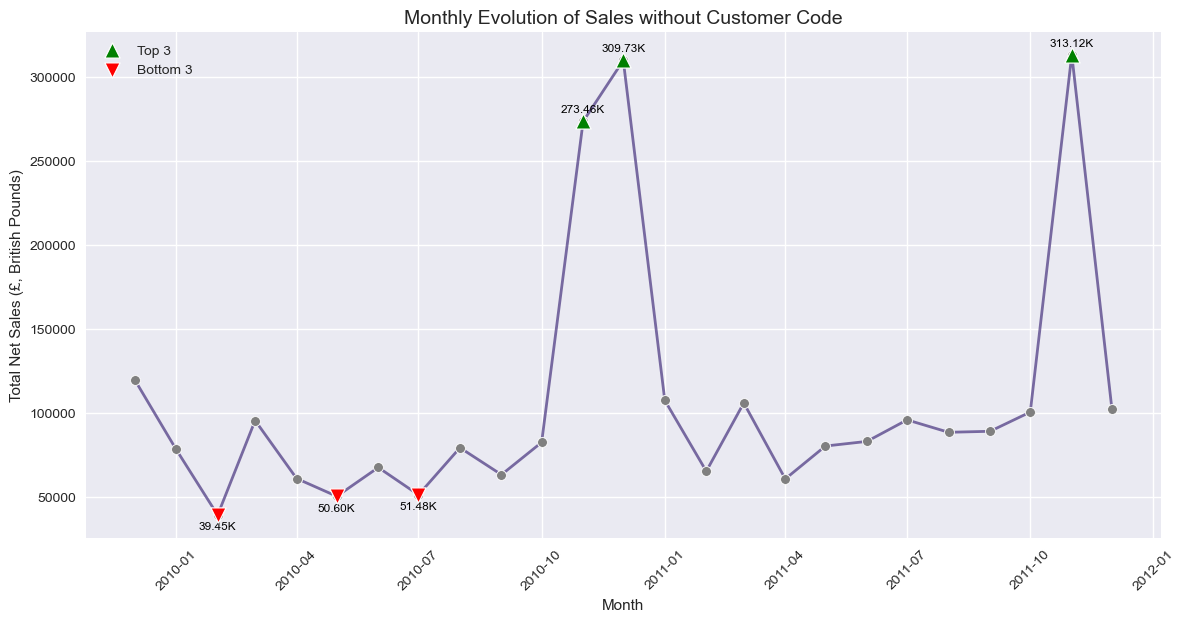

In [31]:
# Converting values back to float
try:
    unknown_ym_dist['Total Net Sales'] = unknown_ym_dist['Total Net Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Converting months to datetime format
unknown_ym_dist['Period'] = pd.to_datetime(unknown_ym_dist['Period'], format='%Y-%m-%d')

# Selecting the 3 months with highest and lowest net sales
top3_unknown_ym_dist = unknown_ym_dist.nlargest(3, 'Total Net Sales')
bottom3_unknown_ym_dist = unknown_ym_dist.nsmallest(3, 'Total Net Sales')

# Validating integrity
df_check(unknown_ym_dist, col_num='Total Net Sales', col_date='Period', negative=True)

# Creating lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=unknown_ym_dist,
    x='Period',
    y='Total Net Sales',
    marker='o',
    color='C0',
    linewidth=2,
    alpha=0.7,
    zorder=1
)

# Plotting all data points
sns.scatterplot(
    data=unknown_ym_dist, x='Period', y='Total Net Sales', color='gray', s=50, ax=ax, zorder=2
)

# Plotting Top 3
sns.scatterplot(
    data=top3_unknown_ym_dist, x='Period', y='Total Net Sales', color='green', s=120, marker='^', label='Top 3', ax=ax, zorder=5
)

# Plotting Bottom 3
sns.scatterplot(
    data=bottom3_unknown_ym_dist, x='Period', y='Total Net Sales', color='red', s=120, marker='v', label='Bottom 3', ax=ax, zorder=5
)

# Adding labels for Top 3
for i, row in top3_unknown_ym_dist.iterrows():
    date = row['Period']
    value = row['Total Net Sales']
    ax.text(date, value+4000, f'{value/1e3:.2f}K',
            ha='center', va='bottom', fontsize=8.5, color='black')

# Adding labels for Bottom 3
for i, row in bottom3_unknown_ym_dist.iterrows():
    date = row['Period']
    value = row['Total Net Sales']
    ax.text(date, value-4000, f'{value/1e3:.2f}K',
            ha='center', va='top', fontsize=8.5, color='black')

# Customizing chart format
plt.title('Monthly Evolution of Sales without Customer Code', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Total Net Sales (£, British Pounds)')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

The chart follows a very similar pattern to the overall sales volume evolution, suggesting that the **number of sales without customer code also increases during peak seasons**.

This reinforces the conclusion that there is **no isolated error** o justify the large number of invoices without customer assignment. Therefore, this phenomenon could be related to purchases made as **"guests"** or to platform limitations in **encouraging customer registration**.

---
### 7. Question 5: What percentage of invoices correspond to returns?

In this section of the exploratory analysis, I run an SQL query to determine the **proportion of invoices that correspond to sales and returns**. This is analyzed both for the United Kingdom, as the main market, and for the rest of the world.  

To achieve this, I use the `WITH` clause to create a subquery that allows me to count three key elements:  

- `total_invoices`: the total number of distinct invoices in the dataset.  
- `returns`: invoices whose identifier begins with `'C'`, which indicate returns.  
- `sales`: the remaining invoices, considered as sales.  

Then, using two `SELECT` blocks joined with `UNION ALL`, I obtain a summary with the total and percentage of each type of transaction.  
This approach allows me to directly compare the relative weight of returns against sales.  

For visualization, I consider that a *pie chart* is the clearest option to present the result.  

#### 7.1. General analysis 

In [32]:
# Getting the number of sales and return invoices and their percentage of the total
query = """
WITH stats AS(
    SELECT
        COUNT(DISTINCT Invoice) AS total_invoices,
        COUNT(DISTINCT CASE WHEN Invoice LIKE 'C%' THEN Invoice END) AS returns,
        COUNT(DISTINCT CASE WHEN Invoice NOT LIKE 'C%' THEN Invoice END) AS sales
    FROM retail
)

SELECT 'Sales' AS "Invoice Type",
    sales AS "Quantity",
    ROUND(sales * 100.0 / total_invoices, 2) AS "Percentage"
FROM stats

UNION ALL

SELECT 'Returns' AS "Invoice Type",
    returns AS "Quantity",
    ROUND(returns * 100.0 / total_invoices, 2) AS "Percentage"
FROM stats
"""

# Converting query result into a DataFrame, formatting it, and displaying results
invoice_dist = pd.read_sql_query(query, engine)
invoice_dist['Quantity'] = invoice_dist['Quantity'].map('{:,.0f}'.format)
invoice_dist['Percentage'] = invoice_dist['Percentage'].map('{:,.2f} %'.format)
display(invoice_dist)

Invoice Type Quantity Percentage
0        Sales   39,496    84.21 %
1      Returns    7,405    15.79 %

Initially, I used the `viridis` palette for the ***pie chart***, but I decided to switch to `pastel` because I noticed that dark colors do not work well for a pie chart with few categories. With `pastel`, the segments are distinguished more clearly, and the chart looks cleaner and easier to read.

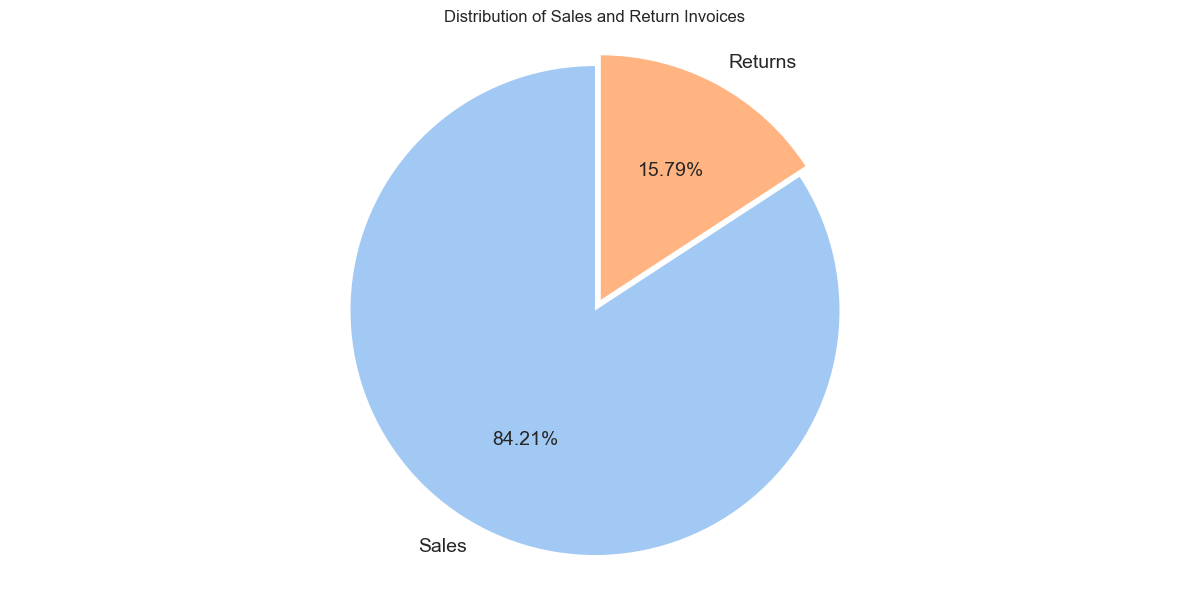

In [33]:
# Converting values back to float
try:
    invoice_dist['Quantity'] = invoice_dist['Quantity'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validating integrity
df_check(invoice_dist, col_num='Quantity', col_text=['Invoice Type', 'Percentage'], negative=False)

# Creating pie chart (in Matplotlib)
plt.figure(figsize=(12, 6))
plt.pie(
    invoice_dist['Quantity'],
    labels=invoice_dist['Invoice Type'],
    autopct='%1.2f%%',
    colors=sns.color_palette("pastel", len(invoice_dist)),
    startangle=90,
    explode=(0, 0.05),
    textprops={'fontsize': 14}
)

# Customizing chart format
plt.title('Distribution of Sales and Return Invoices')
plt.axis('equal')
plt.tight_layout()
plt.show()

The result indicates that approximately **15.79%** of invoices correspond to **returns**, while **84.21%** represent **actual sales**. This value, although significant, is **below the general industry average for e-commerce**, which is estimated at around **20%** according to [Outvio (2024)](https://outvio.com/blog/return-rate-stats/).

This level of returns can be considered reasonable depending on the type of product and sales channel, but it also represents an opportunity to improve the shopping experience, reduce logistical errors, or strengthen product communication.

#### 7.2. Results in the United Kingdom

In [34]:
# Getting number of sales and return invoices in the UK and their percentage of the total
query = """
WITH stats AS(
    SELECT
        COUNT(DISTINCT Invoice) AS total_invoices,
        COUNT(DISTINCT CASE WHEN Invoice LIKE 'C%' THEN Invoice END) AS returns,
        COUNT(DISTINCT CASE WHEN Invoice NOT LIKE 'C%' THEN Invoice END) AS sales
    FROM retail
    WHERE "Country" = "United Kingdom"
)

SELECT 'Sales' AS "Invoice Type",
    sales AS "Quantity",
    ROUND(sales * 100.0 / total_invoices, 2) AS "Percentage"
FROM stats

UNION ALL

SELECT 'Returns' AS "Invoice Type",
    returns AS "Quantity",
    ROUND(returns * 100.0 / total_invoices, 2) AS "Percentage"
FROM stats;
"""

# Converting query result into a DataFrame, formatting it, and displaying results
uk_invoice_dist = pd.read_sql_query(query, engine)
uk_invoice_dist['Quantity'] = uk_invoice_dist['Quantity'].map('{:,.0f}'.format)
uk_invoice_dist['Percentage'] = uk_invoice_dist['Percentage'].map('{:,.2f} %'.format)
display(uk_invoice_dist)

Invoice Type Quantity Percentage
0        Sales   36,184    84.58 %
1      Returns    6,597    15.42 %

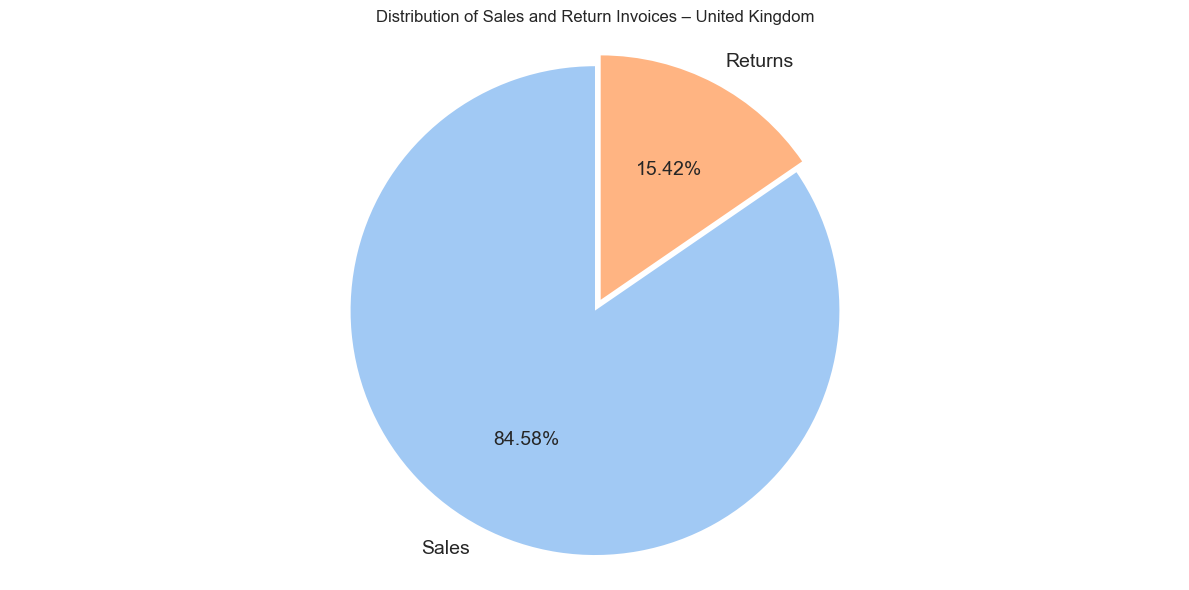

In [35]:
# Converting values back to float
try:
    uk_invoice_dist['Quantity'] = uk_invoice_dist['Quantity'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validating integrity
df_check(uk_invoice_dist, col_num='Quantity', col_text=['Invoice Type', 'Percentage'], negative=False)

# Creating pie chart
plt.figure(figsize=(12, 6))
plt.pie(
    uk_invoice_dist['Quantity'],
    labels=uk_invoice_dist['Invoice Type'],
    autopct='%1.2f%%',
    colors=sns.color_palette("pastel", len(invoice_dist)),
    startangle=90,
    explode=(0, 0.05),
    textprops={'fontsize': 14}
)

# Customizing chart format
plt.title('Distribution of Sales and Return Invoices – United Kingdom')
plt.axis('equal')
plt.tight_layout()
plt.show()

The chart does not change much in the case of the **United Kingdom**, with returns making up **15.42%** of all transactions in the British market and sales accounting for **84.58%**. 

#### 7.3. Results in the Rest of the World

In [36]:
# Getting number of sales and return invoices in the rest of the world and their percentage of the total
query = """
WITH stats AS(
    SELECT
        COUNT(DISTINCT Invoice) AS total_invoices,
        COUNT(DISTINCT CASE WHEN Invoice LIKE 'C%' THEN Invoice END) AS returns,
        COUNT(DISTINCT CASE WHEN Invoice NOT LIKE 'C%' THEN Invoice END) AS sales
    FROM retail
    WHERE "Country" != "United Kingdom"
)

SELECT 'Sales' AS "Invoice Type",
    sales AS "Quantity",
    ROUND(sales * 100.0 / total_invoices, 2) AS "Percentage"
FROM stats

UNION ALL

SELECT 'Returns' AS "Invoice Type",
    returns AS "Quantity",
    ROUND(returns * 100.0 / total_invoices, 2) AS "Percentage"
FROM stats;
"""

# Converting query result into a DataFrame, formatting it, and displaying results
rw_invoice_dist = pd.read_sql_query(query, engine)
rw_invoice_dist['Quantity'] = rw_invoice_dist['Quantity'].map('{:,.0f}'.format)
rw_invoice_dist['Percentage'] = rw_invoice_dist['Percentage'].map('{:,.2f} %'.format)
display(rw_invoice_dist)

Invoice Type Quantity Percentage
0        Sales    3,312    80.39 %
1      Returns      808    19.61 %

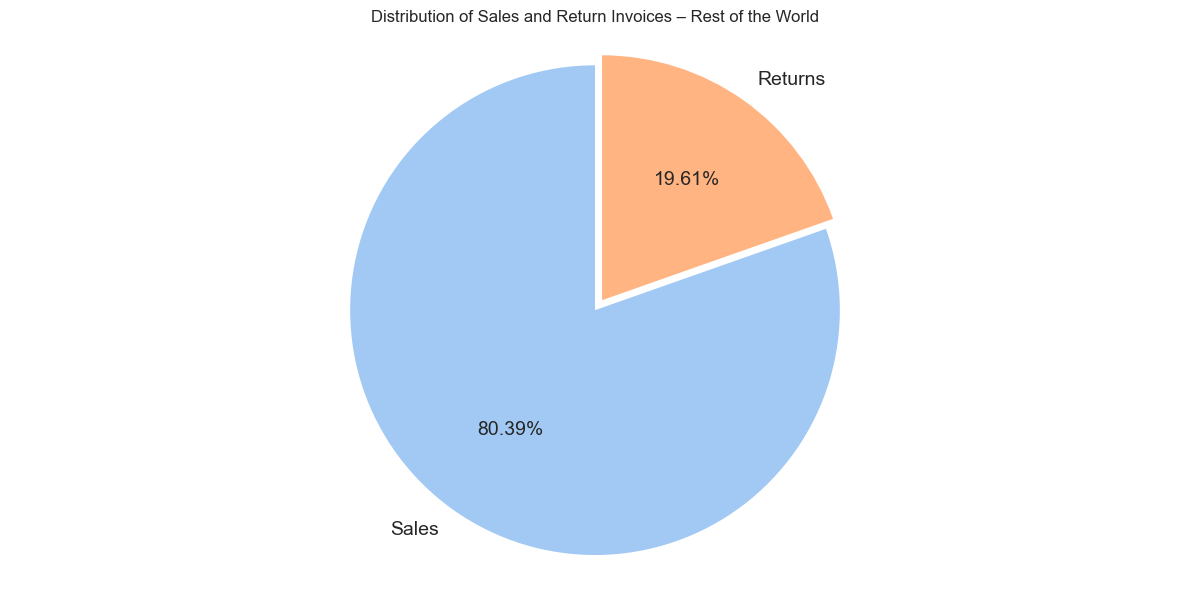

In [37]:
# Converting values back to float
try:
    rw_invoice_dist['Quantity'] = rw_invoice_dist['Quantity'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validating integrity
df_check(rw_invoice_dist, col_num='Quantity', col_text=['Invoice Type', 'Percentage'], negative=False)

# Creating pie chart
plt.figure(figsize=(12, 6))
plt.pie(
    rw_invoice_dist['Quantity'],
    labels=rw_invoice_dist['Invoice Type'],
    autopct='%1.2f%%',
    colors=sns.color_palette("pastel", len(invoice_dist)),
    startangle=90,
    explode=(0, 0.05),
    textprops={'fontsize': 14}
)

# Customizing chart format
plt.title('Distribution of Sales and Return Invoices – Rest of the World')
plt.axis('equal')
plt.tight_layout()
plt.show()

The rest of the world shows a **higher percentage** of returns, with **19.61%** compared to **80.39%** effective sales.

This return rate is much **closer to the industry average** for e-commerce.

---
### 8. Question 6: What is the average ticket per invoice?

Answering this question is useful to understand the **individual value of each transaction**. This information can help identify markets or segments that, without necessarily having a high purchase volume, generate **greater revenue per transaction**. 

#### 8.1. Gross sales

In this case, I start from the assumption that invoices beginning with the letter *'C'* correspond to returns, so I **exclude them from the analysis** to obtain an average ticket that represents only actual sales.  

The SQL query calculates the number of unique invoices, their total gross sales value, and the average gross ticket, represented by total value divided by the number of invoices.  

In [38]:
# Getting number of sales invoices, total gross sales, and average gross ticket
query = """
SELECT COUNT(DISTINCT Invoice) AS "Number of Sales Invoices",
    SUM("LineTotal") AS "Total Gross Sales",
    ROUND(SUM("LineTotal") * 1.0 / COUNT(DISTINCT Invoice), 2) AS "Average Gross Ticket"
FROM retail
WHERE Invoice NOT LIKE 'C%';
"""

# Converting query result into a DataFrame, formatting it, and displaying results
avg_gticket = pd.read_sql_query(query, engine)
avg_gticket['Number of Sales Invoices'] = avg_gticket['Number of Sales Invoices'].map('{:,.0f}'.format)
avg_gticket['Total Gross Sales'] = avg_gticket['Total Gross Sales'].map('{:,.0f}'.format)
avg_gticket['Average Gross Ticket'] = avg_gticket['Average Gross Ticket'].map('{:,.2f}'.format)
display(avg_gticket)

Number of Sales Invoices Total Gross Sales Average Gross Ticket
0                   39,496        20,110,478               509.18

The result indicates that, on average, **each invoice** represents approximately **£509.18** in sales, **excluding returns**.

The next step in this analysis is to identify which **countries** have the **highest average ticket**.

Answering this question is key to detecting which markets generate **greater revenue per invoice**, which may have both commercial and logistical implications.

In [39]:
# Getting number of sales invoices, total gross sales, and average gross ticket by country
query = """
SELECT Country,
    COUNT(DISTINCT Invoice) AS "Number of Sales Invoices",
    SUM("LineTotal") AS "Total Gross Sales",
    ROUND(SUM("LineTotal") * 1.0 / COUNT(DISTINCT Invoice), 2) AS "Average Gross Ticket"
FROM retail
WHERE Invoice NOT LIKE 'C%'
GROUP BY Country
ORDER BY "Average Gross Ticket" DESC;
"""

# Converting query result into a DataFrame, formatting it, and displaying results
avg_gticket_countries = pd.read_sql_query(query, engine)
avg_gticket_countries['Number of Sales Invoices'] = avg_gticket_countries['Number of Sales Invoices'].map('{:,.0f}'.format)
avg_gticket_countries['Total Gross Sales'] = avg_gticket_countries['Total Gross Sales'].map('{:,.0f}'.format)
avg_gticket_countries['Average Gross Ticket'] = avg_gticket_countries['Average Gross Ticket'].map('{:,.2f}'.format)
display(avg_gticket_countries)

Country Number of Sales Invoices Total Gross Sales  \
0            Netherlands                      216           549,953   
1              Australia                       89           168,485   
2              Singapore                        8            13,158   
3                Denmark                       42            68,560   
4              Hong Kong                        9            13,875   
5               Thailand                        2             3,071   
6                  Japan                       33            47,138   
7                Bermuda                        1             1,253   
8                 Israel                       10            11,335   
9           South Africa                        3             3,369   
10           Switzerland                       85            94,270   
11             Lithuania                        6             6,554   
12               Ireland                      585           638,934   
13                Norway                       39            42,362   
14                Greece                       18            18,711   
15               Lebanon                        2             1,906   
16                Sweden                       99            86,353   
17  United Arab Emirates                       12            10,273   
18       Channel Islands                       54            44,704   
19                Brazil                        2             1,412   
20               Iceland                        8             5,633   
21                Cyprus                       35            24,614   
22                 Spain                      144            98,613   
23                 Malta                        7             4,757   
24                Canada                        7             4,332   
25              Portugal                       85            48,819   
26                 Korea                        2             1,119   
27           West Indies                        1               536   
28                France                      601           317,345   
29               Germany                      753           388,830   
30               Austria                       40            20,297   
31                 Italy                       59            29,324   
32                   USA                       16             7,920   
33        United Kingdom                   36,184        17,235,543   
34               Finland                       54            25,180   
35               Belgium                      143            57,323   
36        Czech Republic                        2               787   
37                Poland                       28            10,462   
38               Bahrain                       10             3,110   
39          Saudi Arabia                        1               146   
40               Nigeria                        1               113   

   Average Gross Ticket  
0              2,546.08  
1              1,893.09  
2              1,644.77  
3              1,632.39  
4              1,541.69  
5              1,535.27  
6              1,428.44  
7              1,253.14  
8              1,133.47  
9              1,123.01  
10             1,109.06  
11             1,092.29  
12             1,092.19  
13             1,086.22  
14             1,039.51  
15               952.79  
16               872.25  
17               856.10  
18               827.85  
19               705.94  
20               704.16  
21               703.27  
22               684.81  
23               679.62  
24               618.87  
25               574.35  
26               559.25  
27               536.41  
28               528.03  
29               516.37  
30               507.43  
31               497.01  
32               495.00  
33               476.33  
34               466.30  
35               400.86  
36               393.37  
37               373.66  
38               310

Because of the **amount of data** on the *'y'*, axis, I decided that the best way to show the results is through a *scatterplot* highlighting with a **different color** those in the **Top 5 and Bottom 5**.

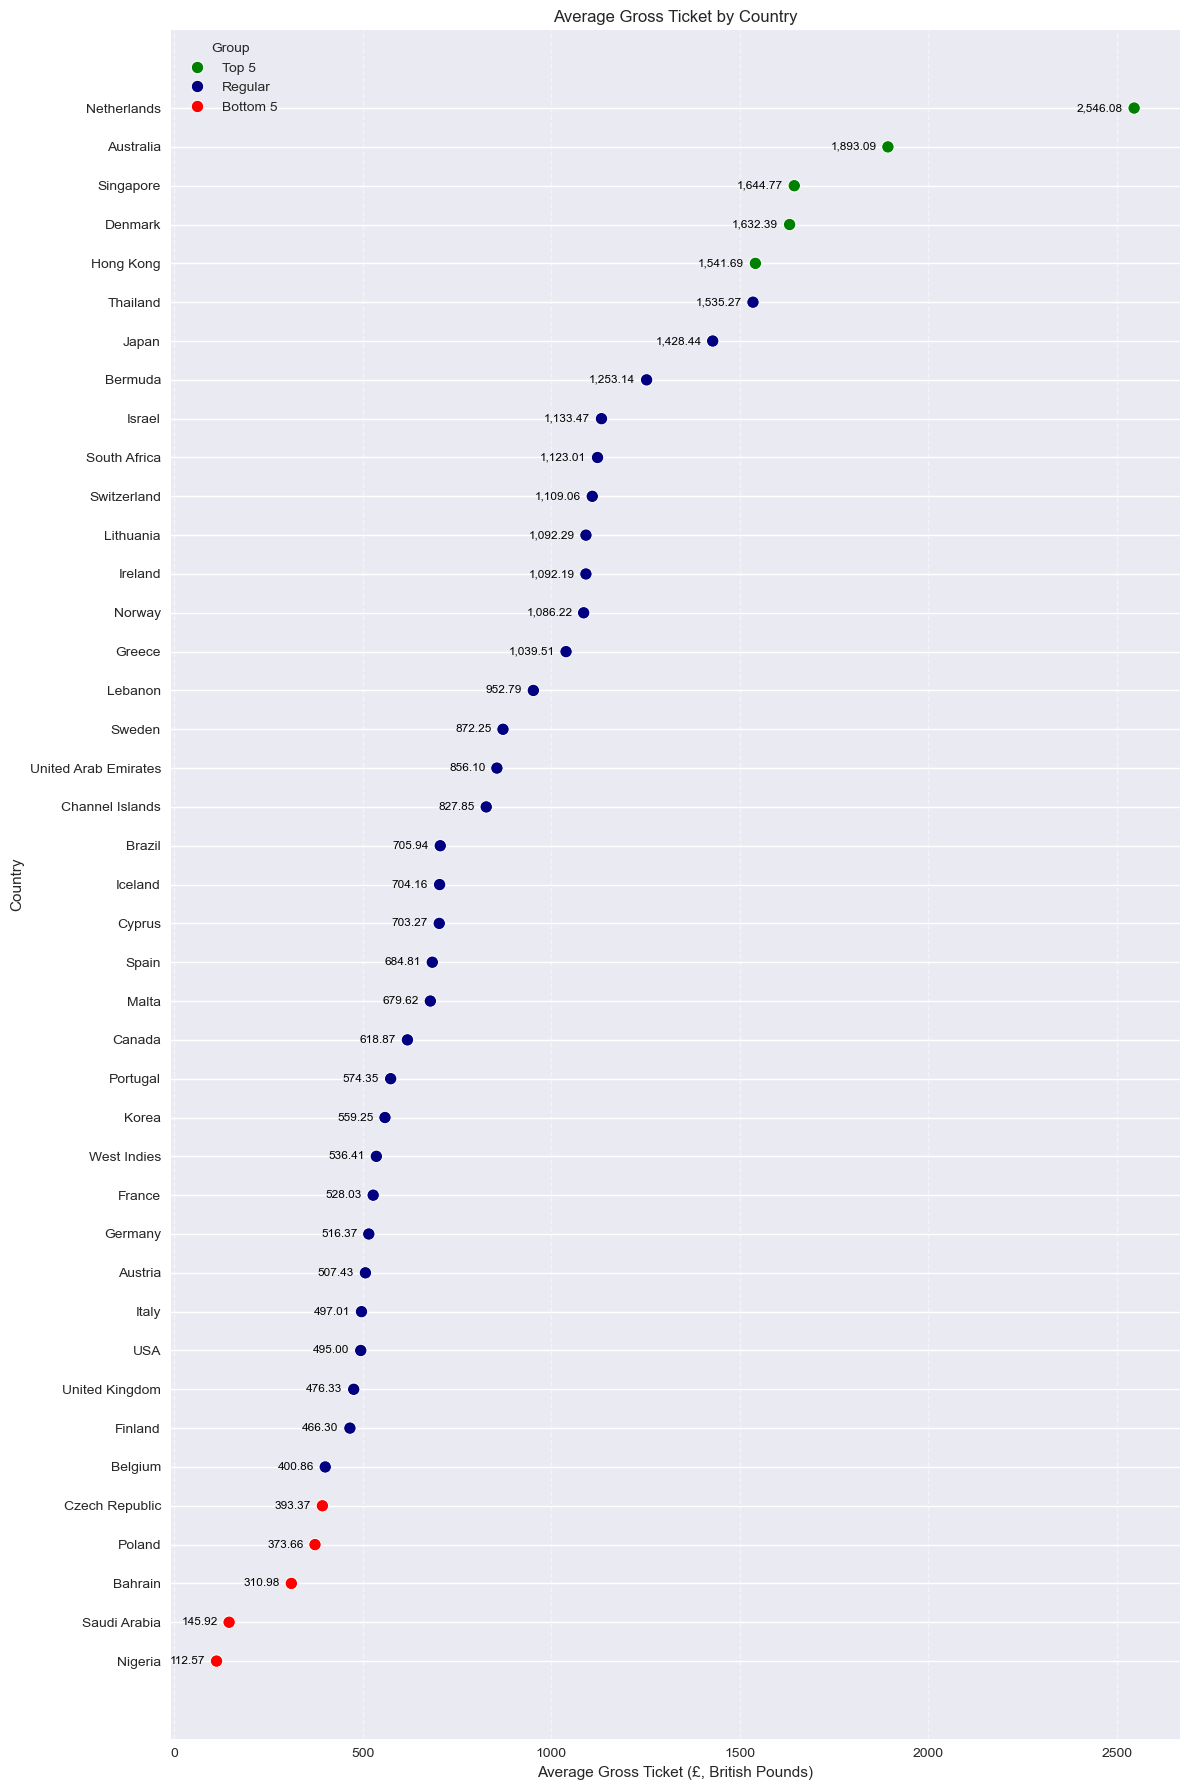

In [40]:
# Converting values back to float
try:
    avg_gticket_countries['Average Gross Ticket'] = avg_gticket_countries['Average Gross Ticket'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Copying original DataFrame and classifying countries into Top 5, Bottom 5, and Regular
agtc = avg_gticket_countries.copy()
agtc['Group'] = 'Regular'
agtc.loc[:4, 'Group'] = 'Top 5'
agtc.loc[agtc.shape[0]-5:, 'Group'] = 'Bottom 5'

# Validating integrity
df_check(agtc, col_num='Average Gross Ticket', col_text=['Country', 'Group'], negative=False)

# Creating scatterplot and formatting points
plt.figure(figsize=(12, 18))
ax = sns.scatterplot(
    data=agtc,
    x='Average Gross Ticket',
    y='Country',
    hue='Group',
    palette={'Top 5': 'green', 'Regular': 'navy', 'Bottom 5': 'red'},
    s=80
)

# Adding data labels
for i, value in enumerate(agtc['Average Gross Ticket']):
    ax.text(value-30, i, f'{value:,.2f}',
            ha='right', va='center', fontsize=8.5, color='black'
           )

# Customizing chart format
plt.title('Average Gross Ticket by Country')
plt.xlabel('Average Gross Ticket (£, British Pounds)')
plt.ylabel('Country')
plt.legend(title='Group')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

As observed, the **Netherlands** clearly leads the ranking, with an average ticket of approximately **£2,546 per transaction**, far above the second place, **Australia**, which records an average of **£1,893**.

There are no other particularly pronounced differences across the remaining countries, except for those occupying the **last two positions**, which could be due to the **low number of transactions** in these markets.

To conclude the gross average ticket analysis, I run an SQL query to visualize the **evolution of the gross average ticket over time** through a *lineplot*, similar to the sales analysis.

In [41]:
# Getting number of sales invoices, total gross sales, and average gross ticket by month
query = """
SELECT Year_Month AS "Period",
    COUNT(DISTINCT Invoice) AS "Number of Sales Invoices",
    SUM("LineTotal") AS "Total Gross Sales",
    ROUND(SUM("LineTotal") * 1.0 / COUNT(DISTINCT Invoice), 2) AS "Average Gross Ticket"
FROM retail
WHERE Invoice NOT LIKE 'C%'
GROUP BY "Period";
"""

# Converting query result into a DataFrame, formatting it, and displaying results
avg_gticket_period = pd.read_sql_query(query, engine)
avg_gticket_period['Number of Sales Invoices'] = avg_gticket_period['Number of Sales Invoices'].map('{:,.0f}'.format)
avg_gticket_period['Total Gross Sales'] = avg_gticket_period['Total Gross Sales'].map('{:,.0f}'.format)
avg_gticket_period['Average Gross Ticket'] = avg_gticket_period['Average Gross Ticket'].map('{:,.2f}'.format)
display(avg_gticket_period)

Period Number of Sales Invoices Total Gross Sales Average Gross Ticket
0   2009-12-01                    1,666           801,603               481.15
1   2010-01-01                    1,047           612,966               585.45
2   2010-02-01                    1,189           539,945               454.12
3   2010-03-01                    1,647           764,734               464.32
4   2010-04-01                    1,434           649,091               452.64
5   2010-05-01                    1,484           645,895               435.24
6   2010-06-01                    1,612           699,766               434.10
7   2010-07-01                    1,507           633,277               420.22
8   2010-08-01                    1,402           676,711               482.68
9   2010-09-01                    1,787           870,350               487.05
10  2010-10-01                    2,244         1,098,868               489.69
11  2010-11-01                    2,717         1,436,505               528.71
12  2010-12-01                    1,551         1,188,008               765.96
13  2011-01-01                    1,081           672,133               621.77
14  2011-02-01                    1,093           509,101               465.78
15  2011-03-01                    1,440           692,008               480.56
16  2011-04-01                    1,233           516,164               418.62
17  2011-05-01                    1,666           740,558               444.51
18  2011-06-01                    1,523           738,579               484.95
19  2011-07-01                    1,447           687,707               475.26
20  2011-08-01                    1,338           725,164               541.98
21  2011-09-01                    1,818         1,030,999               567.11
22  2011-10-01                    2,005         1,107,250               552.24
23  2011-11-01                    2,749         1,457,555               530.21
24  2011-12-01                      816           615,543               754.34

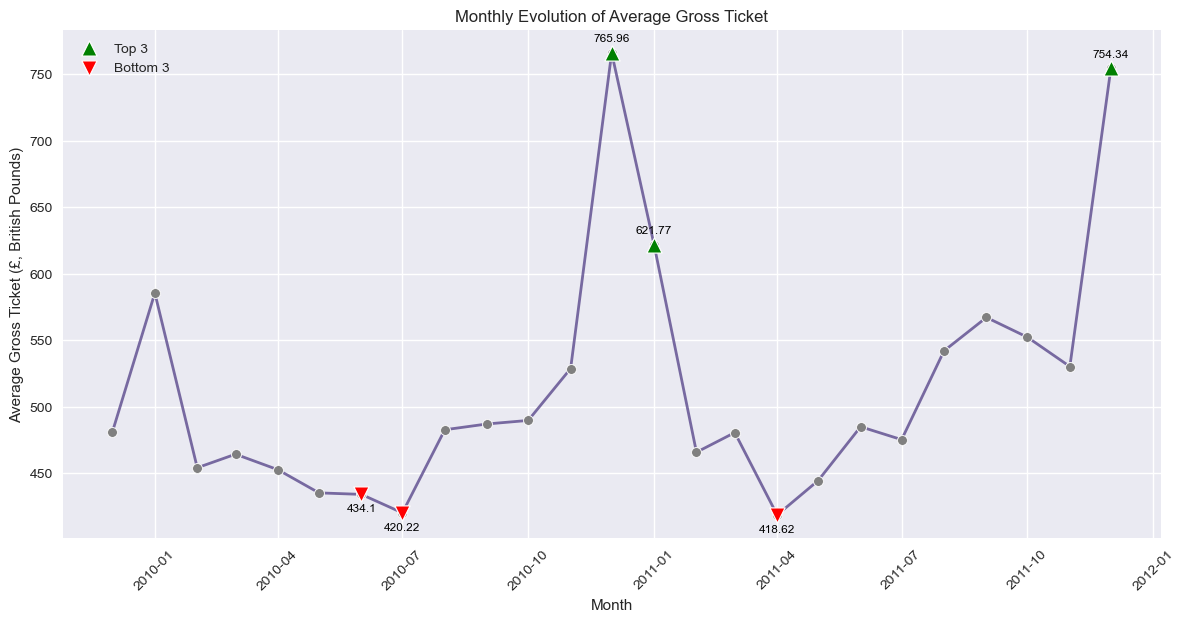

In [42]:
# Converting values back to float
try:
    avg_gticket_period['Average Gross Ticket'] = avg_gticket_period['Average Gross Ticket'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Converting months to datetime format
avg_gticket_period['Period'] = pd.to_datetime(avg_gticket_period['Period'], format='%Y-%m-%d')

# Selecting the 3 months with highest and lowest average gross tickets
top3_gticket_period = avg_gticket_period.nlargest(3, 'Average Gross Ticket')
bottom3_gticket_period = avg_gticket_period.nsmallest(3, 'Average Gross Ticket')

# Validating integrity
df_check(avg_gticket_period, col_num='Average Gross Ticket', col_date='Period', negative=False)

# Creating lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=avg_gticket_period,
    x='Period',
    y='Average Gross Ticket',
    marker='o',
    color='C0',
    linewidth=2,
    alpha=0.7,
    zorder=1
)

# Plotting all points
sns.scatterplot(
    data=avg_gticket_period, x='Period', y='Average Gross Ticket', color='gray', s=50, ax=ax, zorder=2
)

# Plotting Top 3
sns.scatterplot(
    data=top3_gticket_period, x='Period', y='Average Gross Ticket', color='green', s=120, marker='^', label='Top 3', ax=ax, zorder=5
)

# Plotting Bottom 3
sns.scatterplot(
    data=bottom3_gticket_period, x='Period', y='Average Gross Ticket', color='red', s=120, marker='v', label='Bottom 3', ax=ax, zorder=5
)

# Adding labels for Top 3
for _, row in top3_gticket_period.iterrows():
    date = row['Period']
    value = row['Average Gross Ticket']
    ax.text(date, value+7, value,
            ha='center', va='bottom', fontsize=8.5, color='black'
           )

# Adding labels for Bottom 3
for _, row in bottom3_gticket_period.iterrows():
    date = row['Period']
    value = row['Average Gross Ticket']
    ax.text(date, value-7, value,
        ha='center', va='top', fontsize=8.5, color='black'
    )

# Customizing chart format
plt.title('Monthly Evolution of Average Gross Ticket')
plt.xlabel('Month')
plt.ylabel('Average Gross Ticket (£, British Pounds)')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

The evolution of the average gross ticket **shows a very similar behavior to the overall sales evolution**, highlighting a **clear seasonality**. There are marked peaks at the **end of the year**, while the lowest values usually occur around **mid-year**.

This pattern may be related to periods of **high demand**, such as **holiday campaigns**, where not only sales volume increases but also the average spending per transaction.

#### 8.2. Net sales

For the **average net ticket**, I **include returns**, so this value reflects the real average revenue that remains in the company **after subtracting returns**.

The SQL query calculates the number of unique invoices, the total value of net sales, and the average net ticket, represented by the total divided by the number of invoices.

In [43]:
# Getting number of sales invoices, total net sales, and average net ticket
query = """
SELECT COUNT(DISTINCT Invoice) AS "Number of Sales Invoices",
    SUM("LineTotal") AS "Total Net Sales",
    ROUND(SUM("LineTotal") * 1.0 / COUNT(DISTINCT Invoice), 2) AS "Average Net Ticket"
FROM retail;
"""

# Converting query result into a DataFrame, formatting it, and displaying results
avg_nticket = pd.read_sql_query(query, engine)
avg_nticket['Number of Sales Invoices'] = avg_nticket['Number of Sales Invoices'].map('{:,.0f}'.format)
avg_nticket['Total Net Sales'] = avg_nticket['Total Net Sales'].map('{:,.0f}'.format)
avg_nticket['Average Net Ticket'] = avg_nticket['Average Net Ticket'].map('{:,.2f}'.format)
display(avg_nticket)

Number of Sales Invoices Total Net Sales Average Net Ticket
0                   46,901      19,383,715             413.29

On average, each invoice represents about **£413.29** in sales, **including returns**.

This implies a **reduction of roughly 20%** versus the gross average ticket, due to the impact of returns. This result is **consistent with the previously observed return share**, which was below the industry average.

Next, I calculate the **average net ticket by country**, following the same logic used for the gross average ticket.

In this case, **returns are included**, which lets us see the real impact of returns on the average revenue per transaction in each country.

In [44]:
# Getting number of sales invoices, total net sales, and average net ticket by country
query = """
SELECT Country,
    COUNT(DISTINCT Invoice) AS "Number of Sales Invoices",
    SUM("LineTotal") AS "Total Net Sales",
    ROUND(SUM("LineTotal") * 1.0 / COUNT(DISTINCT Invoice), 2) AS "Average Net Ticket"
FROM retail
GROUP BY Country
ORDER BY "Average Net Ticket" DESC;
"""

# Converting query result into a DataFrame, formatting it, and displaying results
avg_nticket_countries = pd.read_sql_query(query, engine)
avg_nticket_countries['Number of Sales Invoices'] = avg_nticket_countries['Number of Sales Invoices'].map('{:,.0f}'.format)
avg_nticket_countries['Total Net Sales'] = avg_nticket_countries['Total Net Sales'].map('{:,.0f}'.format)
avg_nticket_countries['Average Net Ticket'] = avg_nticket_countries['Average Net Ticket'].map('{:,.2f}'.format)
display(avg_nticket_countries)

Country Number of Sales Invoices Total Net Sales  \
0            Netherlands                      227         546,275   
1              Singapore                        8          13,158   
2              Australia                      108         166,967   
3               Thailand                        2           3,071   
4              Hong Kong                       10          13,864   
5                Denmark                       50          64,493   
6                Bermuda                        1           1,253   
7           South Africa                        3           3,369   
8              Lithuania                        6           6,554   
9                 Norway                       41          42,201   
10                Israel                       11          11,107   
11               Lebanon                        2           1,906   
12                Greece                       20          18,660   
13               Ireland                      731         618,472   
14           Switzerland                      111          93,164   
15                 Japan                       53          43,861   
16                Sweden                      114          84,379   
17                Brazil                        2           1,412   
18               Iceland                        8           5,633   
19                Canada                        7           4,332   
20                Cyprus                       42          24,118   
21  United Arab Emirates                       17           9,628   
22       Channel Islands                       75          42,465   
23           West Indies                        1             536   
24                 Spain                      168          85,658   
25               Austria                       44          20,072   
26              Portugal                      106          48,189   
27                 Malta                       11           4,667   
28                France                      712         299,656   
29               Finland                       60          25,090   
30        United Kingdom                   42,781      16,593,572   
31               Germany                    1,035         379,901   
32                 Italy                       80          28,596   
33               Belgium                      172          56,928   
34                 Korea                        3             950   
35                   USA                       21           5,840   
36                Poland                       38          10,088   
37               Bahrain                       12           2,862   
38        Czech Republic                        4             672   
39          Saudi Arabia                        2             131   
40               Nigeria                        2             -34   

   Average Net Ticket  
0            2,406.50  
1            1,644.77  
2            1,545.99  
3            1,535.27  
4            1,386.43  
5            1,289.86  
6            1,253.14  
7            1,123.01  
8            1,092.29  
9            1,029.29  
10           1,009.75  
11             952.79  
12             933.02  
13             846.06  
14             839.31  
15             827.57  
16             740.17  
17             705.94  
18             704.16  
19             618.87  
20             574.23  
21             566.36  
22             566.20  
23             536.41  
24             509.87  
25             456.17  
26             454.61  
27             424.29  
28             420.86  
29             418.16  
30             387.87  
31             367.05  
32             357.45  
33             330.98  
34             316.61  
35             278.08  
36             265.48  
37             238.46  
38             167.93  
39              65.59  
40             -17.24

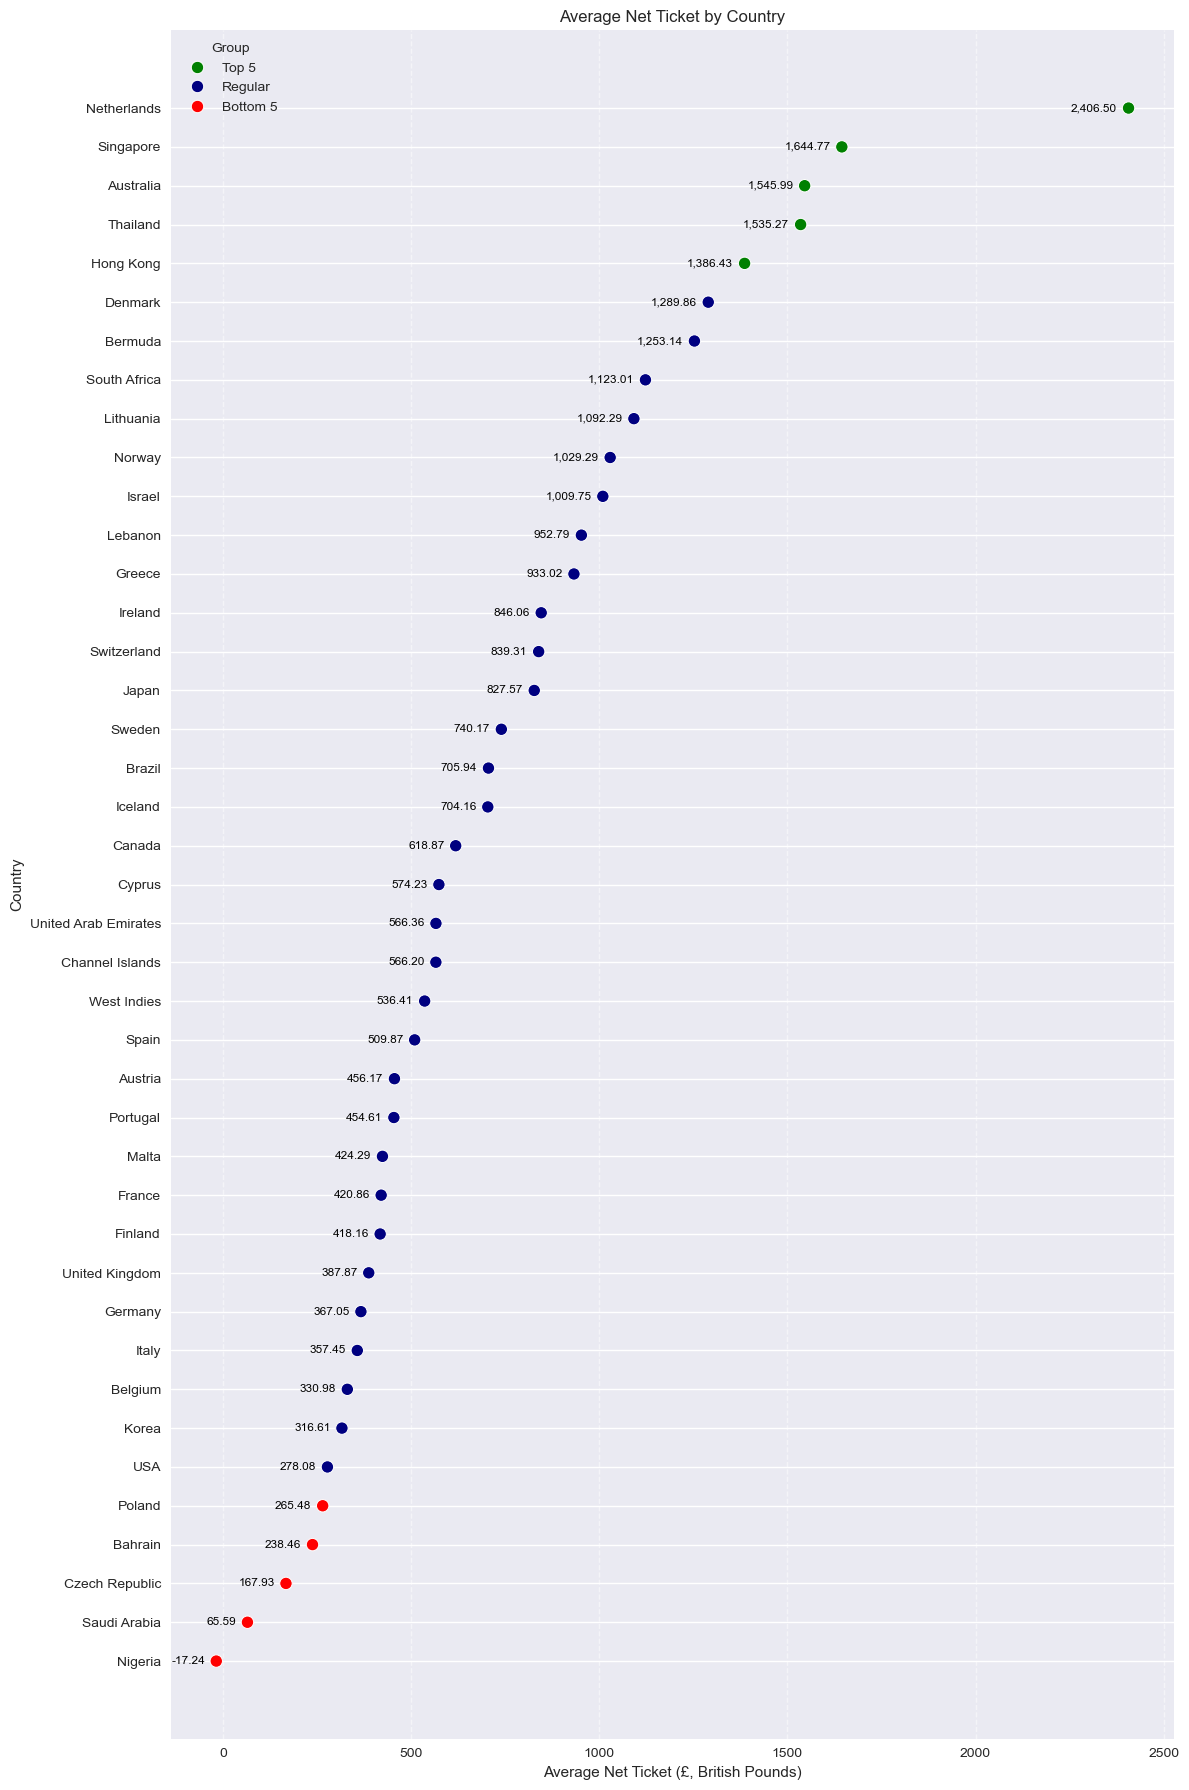

In [45]:
# Converting values back to float
try:
    avg_nticket_countries['Average Net Ticket'] = avg_nticket_countries['Average Net Ticket'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Copying original DataFrame and classifying countries into Top 5, Bottom 5, and Regular
antc = avg_nticket_countries.copy()
antc['Group'] = 'Regular'
antc.loc[:4, 'Group'] = 'Top 5'
antc.loc[antc.shape[0]-5:, 'Group'] = 'Bottom 5'

# Validating integrity
df_check(antc, col_num='Average Net Ticket', col_text=['Country', 'Group'], negative=True)

# Creating scatterplot and formatting points
plt.figure(figsize=(12, 18))
ax = sns.scatterplot(
    data=antc,
    x='Average Net Ticket',
    y='Country',
    hue='Group',
    palette={'Top 5': 'green', 'Regular': 'navy', 'Bottom 5': 'red'},
    s=80
)

# Adding data labels
for i, value in enumerate(antc['Average Net Ticket']):
    ax.text(value-30, i, f'{value:,.2f}',
            ha='right', va='center', fontsize=8.5, color='black')

# Customizing chart format
plt.title('Average Net Ticket by Country')
plt.xlabel('Average Net Ticket (£, British Pounds)')
plt.ylabel('Country')
plt.legend(title='Group')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In this chart, the **Netherlands** remains the **clear leader** with an average net ticket of about **£2,407** even after considering returns.

However, some countries **shift positions in the ranking** because of return impacts. Despite these changes, **the lowest-ranked countries remain the same**, with minor order swaps between them.

> **Update note:**  
> I noticed that **Nigeria** had a **negative average net ticket**, so I ran a quick query to understand how its invoices are composed.

In [46]:
# Getting Nigeria invoices and their totals
query = """
SELECT Country, Invoice, SUM("LineTotal") AS "Total"
FROM retail
WHERE Country = 'Nigeria'
GROUP BY Invoice;
"""

# Converting query result into a DataFrame and displaying it
nigeria_ntickets = pd.read_sql_query(query, engine)
display(nigeria_ntickets)

Country  Invoice   Total
0  Nigeria   519827  112.57
1  Nigeria  C489881 -147.05

Reviewing the results shows that the **return** has a **higher absolute value** than the purchase, which yields a negative average net ticket.

Finally, I query and chart the **evolution of the average net ticket over time** using a *lineplot*, similar to the gross average ticket analysis.

In [47]:
# Getting number of sales invoices, total net sales, and average net ticket by month
query = """
SELECT Year_Month AS "Period",
    COUNT(DISTINCT Invoice) AS "Number of Sales Invoices",
    SUM("LineTotal") AS "Total Net Sales",
    ROUND(SUM("LineTotal") * 1.0 / COUNT(DISTINCT Invoice), 2) AS "Average Net Ticket"
FROM retail
GROUP BY "Period";
"""

# Converting query result into a DataFrame, formatting it, and displaying results
avg_nticket_period = pd.read_sql_query(query, engine)
avg_nticket_period['Number of Sales Invoices'] = avg_nticket_period['Number of Sales Invoices'].map('{:,.0f}'.format)
avg_nticket_period['Total Net Sales'] = avg_nticket_period['Total Net Sales'].map('{:,.0f}'.format)
avg_nticket_period['Average Net Ticket'] = avg_nticket_period['Average Net Ticket'].map('{:,.2f}'.format)
display(avg_nticket_period)

Period Number of Sales Invoices Total Net Sales Average Net Ticket
0   2009-12-01                    2,045         782,042             382.42
1   2010-01-01                    1,288         605,500             470.11
2   2010-02-01                    1,408         527,360             374.55
3   2010-03-01                    1,999         755,027             377.70
4   2010-04-01                    1,697         639,066             376.59
5   2010-05-01                    1,871         608,601             325.28
6   2010-06-01                    1,931         673,372             348.72
7   2010-07-01                    1,821         616,144             338.35
8   2010-08-01                    1,644         664,292             404.07
9   2010-09-01                    2,105         842,582             400.28
10  2010-10-01                    2,652       1,073,243             404.69
11  2010-11-01                    3,260       1,401,345             429.86
12  2010-12-01                    1,852       1,163,537             628.26
13  2011-01-01                    1,328         580,557             437.17
14  2011-02-01                    1,284         500,725             389.97
15  2011-03-01                    1,721         681,332             395.89
16  2011-04-01                    1,453         482,847             332.31
17  2011-05-01                    1,933         731,609             378.48
18  2011-06-01                    1,821         724,812             398.03
19  2011-07-01                    1,682         676,313             402.09
20  2011-08-01                    1,578         702,235             445.02
21  2011-09-01                    2,117       1,013,954             478.96
22  2011-10-01                    2,313       1,063,258             459.69
23  2011-11-01                    3,145       1,432,544             455.50
24  2011-12-01                      953         441,417             463.19

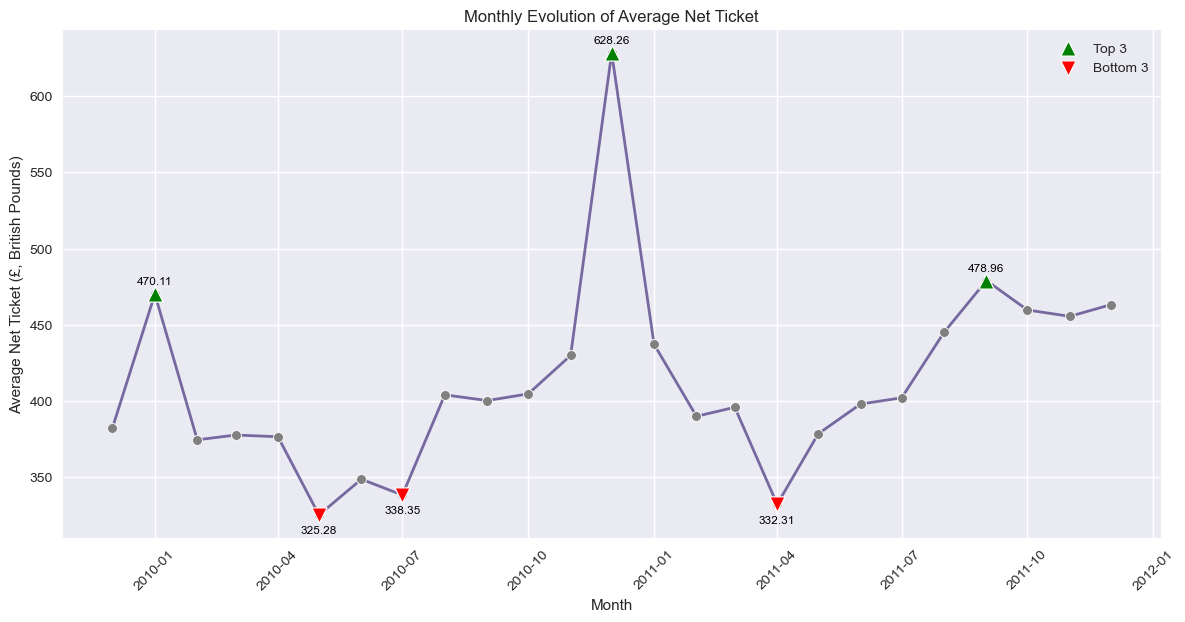

In [48]:
# Converting values back to float
try:
    avg_nticket_period['Average Net Ticket'] = avg_nticket_period['Average Net Ticket'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Converting months to datetime format
avg_nticket_period['Period'] = pd.to_datetime(avg_nticket_period['Period'], format='%Y-%m-%d')

# Picking Top 3 and Bottom 3 months
top3_nticket_period = avg_nticket_period.nlargest(3, 'Average Net Ticket')
bottom3_nticket_period = avg_nticket_period.nsmallest(3, 'Average Net Ticket')

# Validating integrity
df_check(avg_nticket_period, col_num='Average Net Ticket', col_date='Period', negative=True)

# Creating lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=avg_nticket_period,
    x='Period',
    y='Average Net Ticket',
    marker='o',
    color='C0',
    linewidth=2,
    alpha=0.7,
    zorder=1
)

# Plotting all points
sns.scatterplot(
    data=avg_nticket_period, x='Period', y='Average Net Ticket', color='gray', s=50, ax=ax, zorder=2
)

# Plotting Top 3
sns.scatterplot(
    data=top3_nticket_period, x='Period', y='Average Net Ticket', color='green', s=120, marker='^', label='Top 3', ax=ax, zorder=5
)

# Plotting Bottom 3
sns.scatterplot(
    data=bottom3_nticket_period, x='Period', y='Average Net Ticket', color='red', s=120, marker='v', label='Bottom 3', ax=ax, zorder=5
)

# Adding labels for Top 3
for _,row in top3_nticket_period.iterrows():
    date = row['Period']
    value = row['Average Net Ticket']
    ax.text(date, value+5, value,
           ha='center', va='bottom', fontsize=8.5, color='black')

# Adding labels for Bottom 3
for _,row in bottom3_nticket_period.iterrows():
    date = row['Period']
    value = row['Average Net Ticket']
    ax.text(date, value-7, value,
           ha='center', va='top', fontsize=8.5, color='black')

# Customizing chart format
plt.title('Monthly Evolution of Average Net Ticket')
plt.xlabel('Month')
plt.ylabel('Average Net Ticket (£, British Pounds)')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

This chart shows an interesting pattern. While the **first peak** still appears in **December 2010**, the **subsequent peaks are not as high**, which could be due to **higher return volumes** in those periods or **lower average spend per transaction**.

To close this section, I run a **comparative analysis between gross and net average tickets** in a single figure.

As with the earlier sales evolution comparison, I apply a `fill-between` to shade the difference between both metrics. Additionally, I add a separate line that makes it easier to see the **absolute variation between the two values** over time.

#### 8.3. Sales comparison

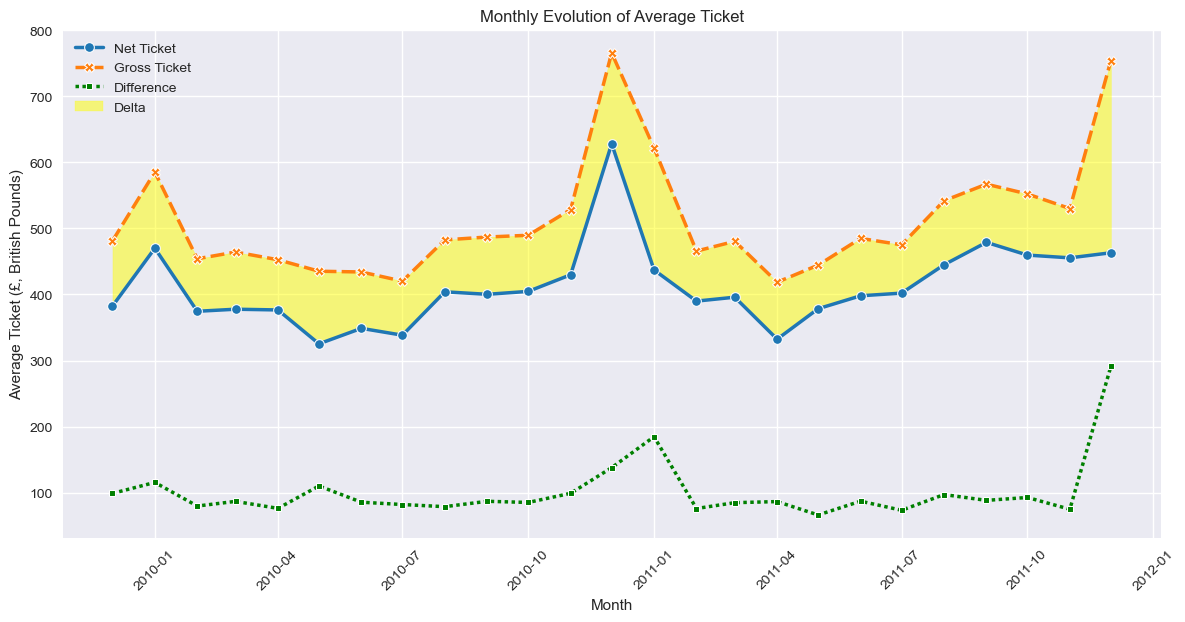

In [49]:
# Copying original DataFrames for transformation
antp = avg_nticket_period.copy()
agtp = avg_gticket_period.copy()

# Merging net and gross tickets by period and renaming columns
merged_avg_ticket = pd.merge(antp, agtp, on='Period', how='inner')
merged_avg_ticket = merged_avg_ticket.rename(columns={
    'Average Net Ticket': 'Net Ticket',
    'Average Gross Ticket': 'Gross Ticket'
})

# Creating difference line between gross and net tickets
merged_avg_ticket['Difference'] = merged_avg_ticket['Gross Ticket'] - merged_avg_ticket['Net Ticket']

# Converting DataFrame to long format
avg_ticket = merged_avg_ticket.melt(
    id_vars = 'Period',
    value_vars = ['Net Ticket', 'Gross Ticket', 'Difference'],
    var_name = 'Type',
    value_name = 'Average Ticket'
)

# Validating integrity
df_check(avg_ticket, col_num='Average Ticket', col_text='Type', col_date='Period', negative=True)

# Creating lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=avg_ticket,
    x='Period',
    y='Average Ticket',
    hue='Type',
    style='Type',
    markers=True,
    linewidth=2.5,
    palette=['#1f77b4', '#ff7f0e', 'green']
)

# Shading the difference area
plt.fill_between(
    merged_avg_ticket['Period'],
    merged_avg_ticket['Gross Ticket'],
    merged_avg_ticket['Net Ticket'],
    where=(merged_avg_ticket['Gross Ticket'] > merged_avg_ticket['Net Ticket']),
    interpolate=True,
    color='yellow',
    alpha=0.5,
    label='Delta'
)

# Customizing chart format
plt.title('Monthly Evolution of Average Ticket')
plt.xlabel('Month')
plt.ylabel('Average Ticket (£, British Pounds)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

A notable difference can be seen in **January 2011**, likely associated with a significant increase in **post-holiday returns**. This means that, despite the high gross ticket value, the net value decreases considerably.

However, the point with the **largest gap between both metrics** occurs in **December 2011**, which could be explained by a combination of factors: a **lower average spend per invoice** together with a **high volume of returns**, amplifying the gap between gross and net values.

This analysis reinforces the importance of considering the impact of returns in commercial and logistical planning, especially during periods of high seasonality.

---
### 9. Question 7: On which day of the week are sales highest?

In this part of the analysis, I aim to identify **temporal patterns** in sales behavior, particularly based on the **day of the week and the time of day**.  

I will work directly from the same DataFrame without the need for an SQL query, since this gives me access to all the necessary columns for the analysis.  

The visualization method will be a *heatmap*, as it allows us to observe with precision the **concentration of sales** and their monetary value depending on the time they occur.

#### 9.1. Order analysis

For the order analysis, I will not consider returns, since my goal is to understand the **number of actual invoices generated**. As this is a transaction volume analysis, returns are not relevant in this context.

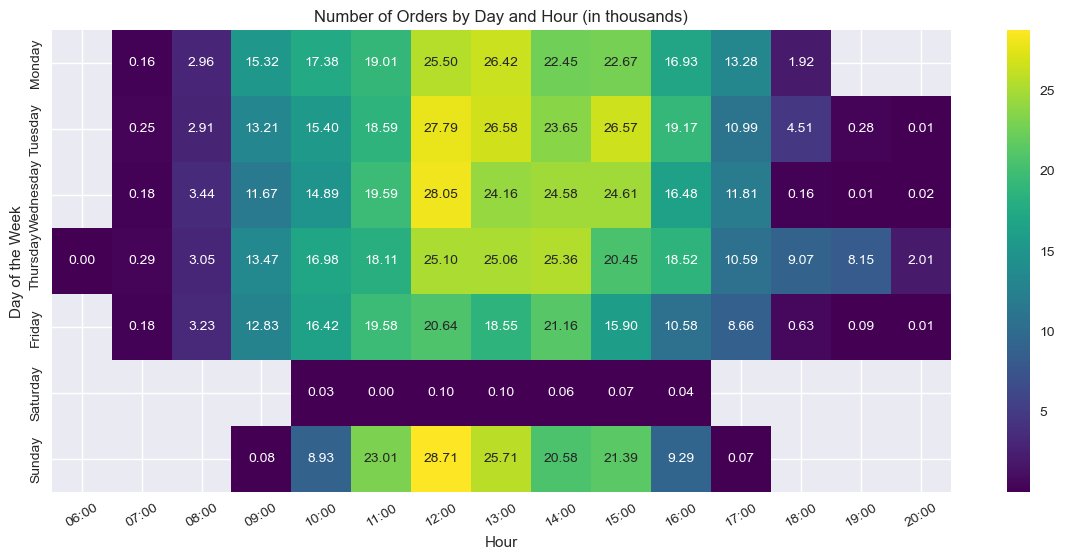

In [50]:
# Converting values to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Defining day of the week order and assigning them as ordered category
days_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Day Name'] = pd.Categorical(df['Day Name'], categories=days_week, ordered=True)

# Filtering only sales (excluding returns) and grouping invoice counts by day and hour for the heatmap matrix
df_gross = df[df['Quantity'] > 0]
sales_time_heatmap = df_gross.groupby(['Day Name', 'Hour'], observed=True).size().unstack()

# Creating heatmap
plt.figure(figsize=(14.5, 6))
sns.heatmap(
    data=sales_time_heatmap / 1e3,
    cmap='viridis',
    annot=True,
    annot_kws={'size': 10},
    fmt='.2f'
)

# Customizing chart format
plt.title('Number of Orders by Day and Hour (in thousands)')
plt.ylabel('Day of the Week')
plt.xlabel('Hour')
plt.xticks(rotation=30)
plt.show()

The *heatmap* shows that the highest number of orders is recorded between **12 p.m. and 3 p.m.**, with **Tuesday and Wednesday** being the days with the highest order volume.

This could be because the *deadline* for receiving orders as quickly as possible is usually around 3 or 5 p.m. As a result, many customers prefer to place their orders early in the week to avoid longer wait times due to the approaching weekend.

It is also interesting to note that **Sunday at 12 p.m.** is one of the time slots with the highest number of orders. This is likely because customers who were unable to make their purchase before the weekend take advantage of this time to buy, ensuring they **receive their products at the start of the following week**.

#### 9.2. Sales analysis

For the sales analysis, I run an SQL query to obtain a **summary table** that provides a general overview of **weekly sales behavior**.  

In this case, I focus on three key metrics:  

- **Number of invoices**  
- **Total gross value** (sales excluding returns)  
- **Average gross ticket** (average per invoice)  

In [51]:
# Getting number of invoices, total gross sales, and average gross ticket by day of the week
query = """
SELECT "Day Name" AS "Day of Week",
    COUNT(DISTINCT "Invoice") AS "Number of Invoices",
    SUM("LineTotal") AS "Total Gross Order",
    SUM("LineTotal") / COUNT(DISTINCT "Invoice") AS "Average Gross Ticket"
FROM retail
WHERE "Quantity" > 0
GROUP BY "Day of Week";
"""

# Converting query result into a DataFrame and sorting it by day of the week
day_week_gsales = pd.read_sql_query(query, engine)
days_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_week_gsales['Day of Week'] = pd.Categorical(day_week_gsales['Day of Week'], categories=days_week, ordered=True)
day_week_gsales = day_week_gsales.sort_values('Day of Week')

# Formatting columns and displaying results
day_week_gsales['Number of Invoices'] = day_week_gsales['Number of Invoices'].map('{:,.0f}'.format)
day_week_gsales['Total Gross Order'] = day_week_gsales['Total Gross Order'].map('{:,.0f}'.format)
day_week_gsales['Average Gross Ticket'] = day_week_gsales['Average Gross Ticket'].map('{:,.2f}'.format)
display(day_week_gsales)

Day of Week Number of Invoices Total Gross Order Average Gross Ticket
1      Monday              6,242         3,477,586               557.13
5     Tuesday              7,144         3,968,947               555.56
6   Wednesday              7,111         3,485,289               490.13
4    Thursday              8,163         4,118,859               504.58
0      Friday              5,984         3,218,418               537.84
2    Saturday                 30             9,803               326.77
3      Sunday              4,822         1,831,577               379.84

The table shows that the **largest volume of orders and sales** occurs on **Thursdays** (8,163 invoices and over £4 million). However, the **highest average gross ticket** is observed on **Mondays**, followed closely by Tuesdays. This may be due to wholesalers or customers planning purchases at the start of the week.

**Fridays** stand out for having a lower invoice volume but a **high average ticket** (£537.69), which may indicate last-minute purchases or larger orders before the weekend.

**Saturdays** reflect **almost no commercial activity**, with only 30 invoices recorded. These are likely **emergency orders or very specific cases**, which strongly contrasts with the rest of the week.

Next, I visualize the difference with a simple *lineplot* and data labels for each day of the week.

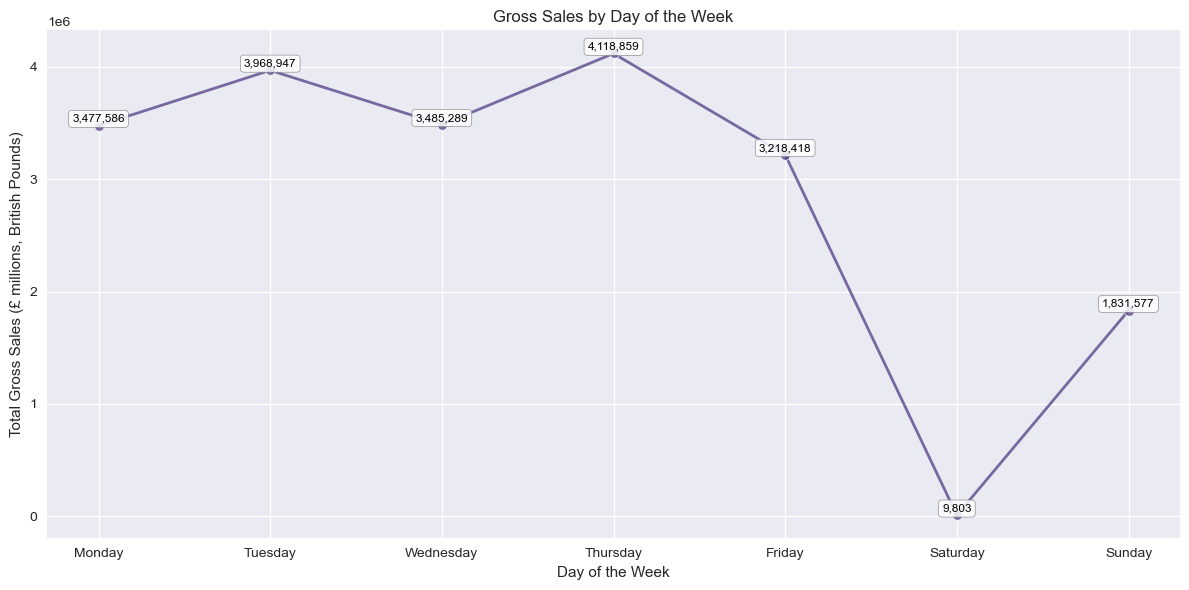

In [52]:
# Converting values back to float
try:
    day_week_gsales['Total Gross Order'] = day_week_gsales['Total Gross Order'].str.replace(',','').astype(float)
except:
    pass

# Validating integrity
df_check(day_week_gsales, col_num='Total Gross Order', col_text='Day of Week', negative=False)

# Creating lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=day_week_gsales,
    x='Day of Week',
    y='Total Gross Order',
    marker='o',
    color='C0',
    linewidth=2,
    alpha=0.7,
    zorder=1
)

# Adding data labels with bbox for better readability
for _, row in day_week_gsales.iterrows():
    date = row['Day of Week']
    value = row['Total Gross Order']
    ax.text(date, value + 15000, f'{value:,.0f}',
           ha='center', va='bottom', fontsize=8.5, color='black', bbox=dict(
        boxstyle='round,pad=0.3',
        facecolor='white',
        edgecolor='gray',
        linewidth=0.5,
        alpha=0.85
    ))

# Customizing chart format
plt.title('Gross Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Gross Sales (£ millions, British Pounds)')
plt.grid(True)
plt.tight_layout()
plt.show()

The *lineplot* shows that the day with the **highest gross sales volume** is **Thursday**, with a total exceeding **£4 million**. In contrast, **Saturday** stands out as the day with the **lowest commercial activity**, followed by **Sunday**.

Among weekdays, **Friday** has the lowest sales volume, which could be explained by customers preferring to place their orders earlier in the week.

I then generate a *heatmap* to visualize the **sales volume by day of the week and hour**.

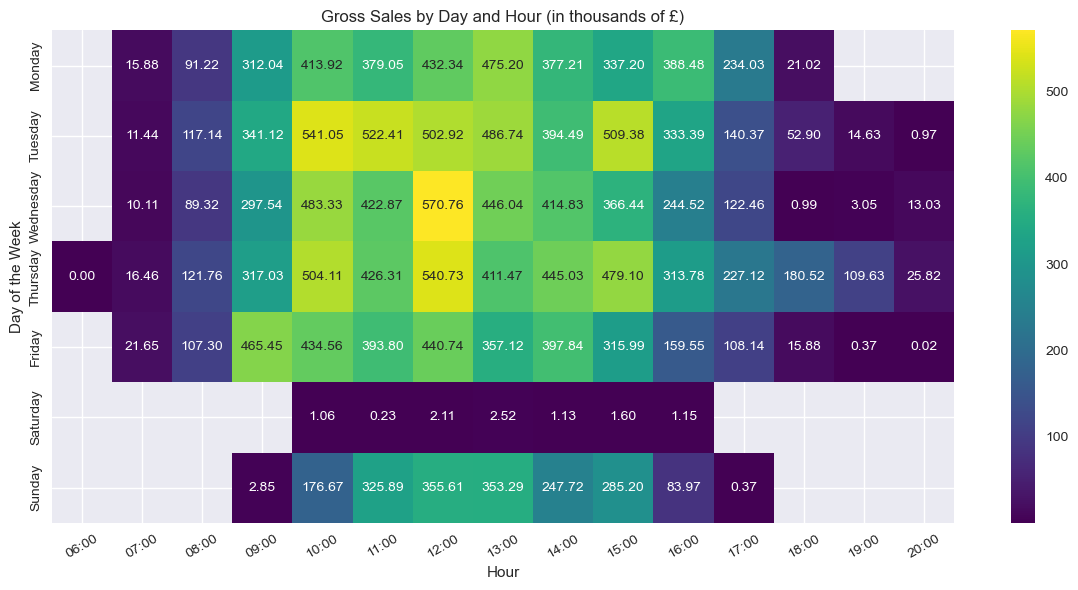

In [53]:
# Generating gross sales matrix by day and hour
sales_value_heatmap = df_gross.groupby(['Day Name', 'Hour'], observed=True)['LineTotal'].sum().unstack()

# Creating heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    data=sales_value_heatmap / 1e3,
    cmap='viridis',
    annot=True,
    annot_kws={'size': 10},
    fmt='.2f'
)

# Customizing chart format
plt.title('Gross Sales by Day and Hour (in thousands of £)')
plt.ylabel('Day of the Week')
plt.xlabel('Hour')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

The *heatmap* shows that the **highest gross sales value** is recorded at **12 p.m. on Wednesday**, peaking at over **£570,000** in that time slot.

Other periods of high activity are observed between **10 a.m. and 3 p.m.** on weekdays, suggesting that **midday hours** are the period of **highest economic activity**. On Fridays, sales peak much earlier in the day.

These patterns could be related to the logistical planning of customers, who take advantage of midday hours to make significant purchases. In contrast, **weekends** show a considerably lower sales volume.

Since two **main markets** have been identified, **United Kingdom** and the **Rest of the World**, in this section I will analyze the **differences in hourly and weekly behavior** of their orders.

The goal is to determine whether there are **specific patterns** in how each market places orders, which could have important **logistical** and **commercial** implications. To do this, I will compare both segments in a *heatmap* by day of the week and hour.

#### 9.3. Results in the United Kingdom

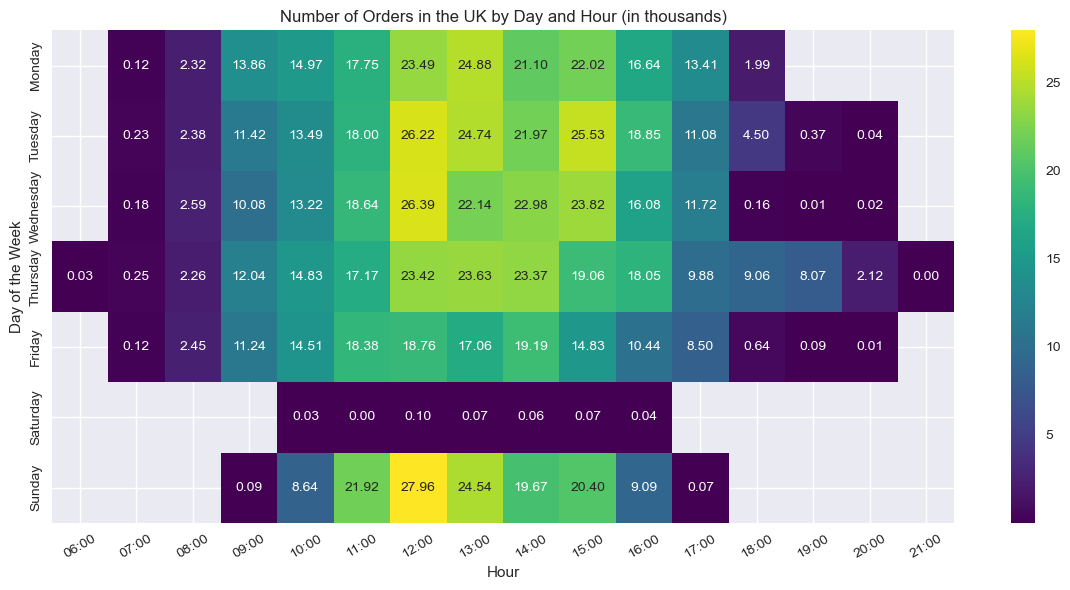

In [54]:
# Filtering only sales in the UK and grouping number of invoices by day and hour
uk_df = df[df['Country'] == 'United Kingdom']
uk_sales_heatmap = uk_df.groupby(['Day Name', 'Hour'], observed=True).size().unstack()

# Creating heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    data=uk_sales_heatmap / 1e3,
    cmap='viridis',
    annot=True,
    annot_kws={'size': 10},
    fmt='.2f'
)

# Customizing chart format
plt.title('Number of Orders in the UK by Day and Hour (in thousands)')
plt.ylabel('Day of the Week')
plt.xlabel('Hour')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

The behavior in the **United Kingdom** follows a very similar trend to the general *heatmap*. The highest order activity is concentrated during the **first days of the week**, especially between **12 p.m. and 3 p.m.**, peaking on **Wednesday at noon**. From that point, activity begins to gradually decrease toward the weekend.

It is interesting to note that although **Sunday at noon** shows a peak in the **number of orders**, this does not necessarily imply a **higher sales volume**, as was shown in the previous visualization.

#### 9.4. Results in the Rest of the World

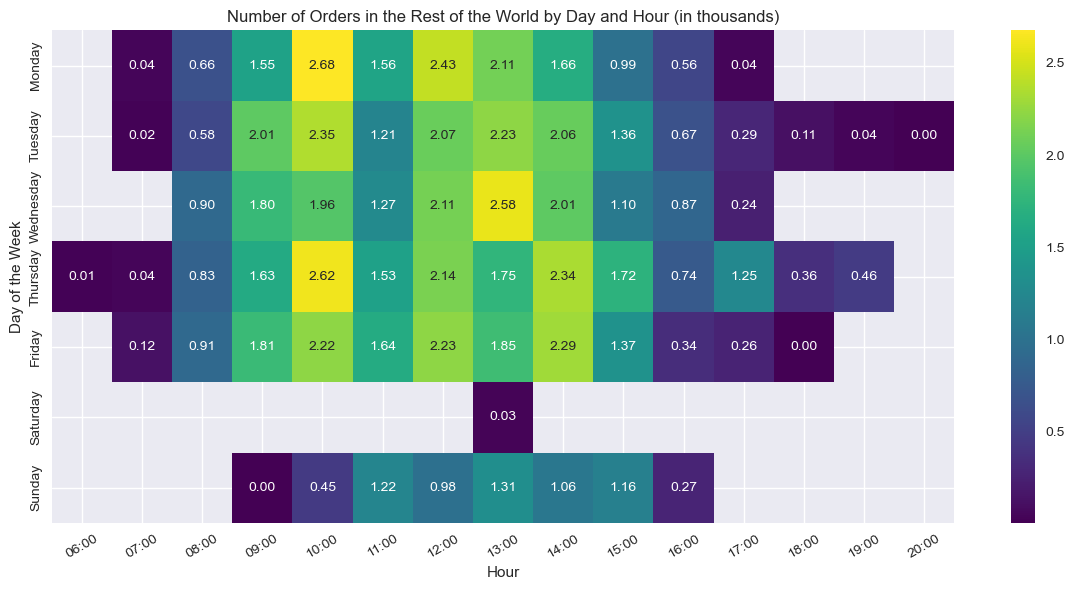

In [55]:
# Filtering only sales in the rest of the world and grouping number of invoices by day and hour
rw_df = df[df['Country'] != 'United Kingdom']
rw_sales_heatmap = rw_df.groupby(['Day Name', 'Hour'], observed=True).size().unstack()

# Creating heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    data=rw_sales_heatmap / 1e3,
    cmap='viridis',
    annot=True,
    annot_kws={'size': 10},
    fmt='.2f'
)

# Customizing chart format
plt.title('Number of Orders in the Rest of the World by Day and Hour (in thousands)')
plt.ylabel('Day of the Week')
plt.xlabel('Hour')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

The behavior of the **rest of the world** differs significantly from that observed in the **United Kingdom**. While in the UK the order volume peaks **at noon**, in the rest of the world **values start to rise as early as 10 a.m.**. Interestingly, there is a **drop at 11 a.m.**, followed by a new **increase at noon**, which remains high until about **2 p.m.**

Unlike the British pattern, the **rest of the world does not show a high order volume on Sundays**, highlighting a clear **difference in commercial behavior between the two markets**.

---
### 10. Question 8: Are there seasonal or monthly sales patterns?

Although earlier we observed **seasonality in sales trends**, especially with **peaks in November and drops at the beginning of the year**, in this section I will analyze this behavior in a more structured and explicit way.  

In addition to analyzing sales to identify recurring patterns, I will also look at the **evolution of returns** to see whether there is any seasonal behavior in product returns.

#### 10.1. Sales patterns

The SQL query generates a **monthly summary table** showing the total number of invoices and the gross sales value. This table will serve as the basis to visualize the **temporal evolution** of sales and confirm whether a **cyclical pattern** indeed exists over time.

In [56]:
# Getting number of invoices and gross sales by month
query = """
SELECT "Year_Month" AS "Period",
    COUNT(DISTINCT "Invoice") AS "Number of Sales Invoices",
    SUM("LineTotal") AS "Total Gross Sales"
FROM retail
WHERE "Quantity" > 0
GROUP BY "Period";
"""

# Converting query result into a DataFrame, formatting it, and displaying results
invoices_per_month = pd.read_sql_query(query, engine)
invoices_per_month['Number of Sales Invoices'] = invoices_per_month['Number of Sales Invoices'].map('{:,}'.format)
invoices_per_month['Total Gross Sales'] = invoices_per_month['Total Gross Sales'].map('{:,.0f}'.format)
display(invoices_per_month)

Period Number of Sales Invoices Total Gross Sales
0   2009-12-01                    1,666           801,603
1   2010-01-01                    1,047           612,966
2   2010-02-01                    1,189           539,945
3   2010-03-01                    1,647           764,734
4   2010-04-01                    1,434           649,091
5   2010-05-01                    1,484           645,895
6   2010-06-01                    1,612           699,766
7   2010-07-01                    1,507           633,277
8   2010-08-01                    1,402           676,711
9   2010-09-01                    1,787           870,350
10  2010-10-01                    2,244         1,098,868
11  2010-11-01                    2,717         1,436,505
12  2010-12-01                    1,551         1,188,008
13  2011-01-01                    1,081           672,133
14  2011-02-01                    1,093           509,101
15  2011-03-01                    1,440           692,008
16  2011-04-01                    1,233           516,164
17  2011-05-01                    1,666           740,558
18  2011-06-01                    1,523           738,579
19  2011-07-01                    1,447           687,707
20  2011-08-01                    1,338           725,164
21  2011-09-01                    1,818         1,030,999
22  2011-10-01                    2,005         1,107,250
23  2011-11-01                    2,749         1,457,555
24  2011-12-01                      816           615,543

It is quickly noticeable in the table that the **lowest sales point** occurred in **December 2011**, with only **816 invoices**, an outlier compared to the seasonal behavior seen in prior years.

Because of this anomaly, in the following visualization I add an **extra data label** to highlight this point, compensating visually for the trend break and making interpretation easier.

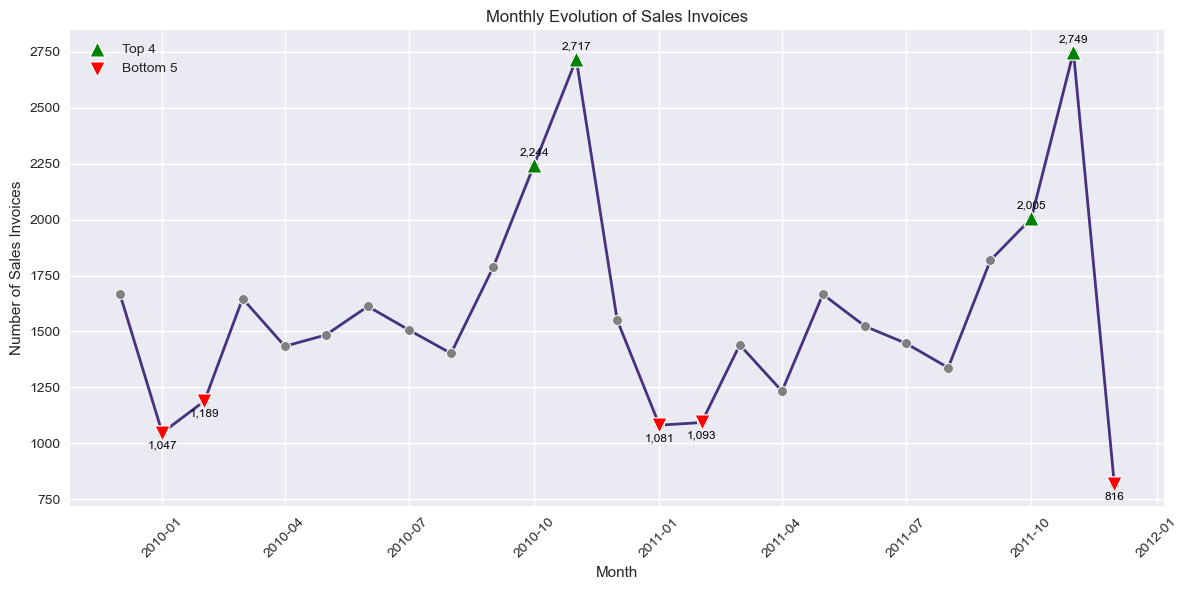

In [57]:
# Converting values back to float
try:
    invoices_per_month['Number of Sales Invoices'] = invoices_per_month['Number of Sales Invoices'].str.replace(',','').astype(float)
    invoices_per_month['Total Gross Sales'] = invoices_per_month['Total Gross Sales'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Converting months to datetime format
invoices_per_month['Period'] = pd.to_datetime(invoices_per_month['Period'], format='%Y-%m-%d')

# Selecting months with highest and lowest number of invoices
top4_ipm = invoices_per_month.nlargest(4, 'Number of Sales Invoices')
bottom5_ipm = invoices_per_month.nsmallest(5, 'Number of Sales Invoices')

# Validating integrity
df_check(invoices_per_month, col_num='Number of Sales Invoices', col_date='Period', negative=False)

# Creating lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=invoices_per_month,
    x='Period',
    y='Number of Sales Invoices',
    marker='o',
    color='C0',
    linewidth=2,
    zorder=1
)

# Plotting all points
sns.scatterplot(
    data=invoices_per_month, x='Period', y='Number of Sales Invoices', color='gray', s=50, ax=ax, zorder=2
)

# Highlighting Top 4
sns.scatterplot(
    data=top4_ipm, x='Period', y='Number of Sales Invoices', color='green', marker='^', s=120, label='Top 4', ax=ax, zorder=5
)

# Highlighting Bottom 5
sns.scatterplot(
    data=bottom5_ipm, x='Period', y='Number of Sales Invoices', color='red', marker='v', s=120, label='Bottom 5', ax=ax, zorder=5
)

# Adding labels for Top 4
for _, row in top4_ipm.iterrows():
    date = row['Period']
    value = row['Number of Sales Invoices']
    ax.text(date, value+35, f'{value:,.0f}',
           ha='center', va='bottom', fontsize=8.5, color='black')

# Adding labels for Bottom 5
for _, row in bottom5_ipm.iterrows():
    date = row['Period']
    value = row['Number of Sales Invoices']
    ax.text(date, value-35, f'{value:,.0f}',
            ha='center', va='top', fontsize=8.5, color='black')

# Customizing chart format
plt.title('Monthly Evolution of Sales Invoices')
plt.xlabel('Month')
plt.ylabel('Number of Sales Invoices')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

We can observe a **recurring upward trend in the last quarter of the year**, suggesting a typical high-season behavior in November and December, likely tied to events such as **Black Friday, Christmas shopping, or fiscal year-end**.

There is also a **sharp drop in orders at the beginning of the year**, which could be explained by a **natural slowdown in consumption** after the holiday season. However, it is **notable** that December 2011 had the **lowest order volume of the entire period**, breaking the pattern seen in previous years where December consistently showed high activity. This could be linked to **operational changes, inventory adjustments, or external events** that impacted demand that month.

Next, I generate a visualization of the **evolution of sales over time**, this time focusing on **gross sales value**.

As with the previous chart, I add an **extra data label** to highlight the **December 2011 anomaly**.

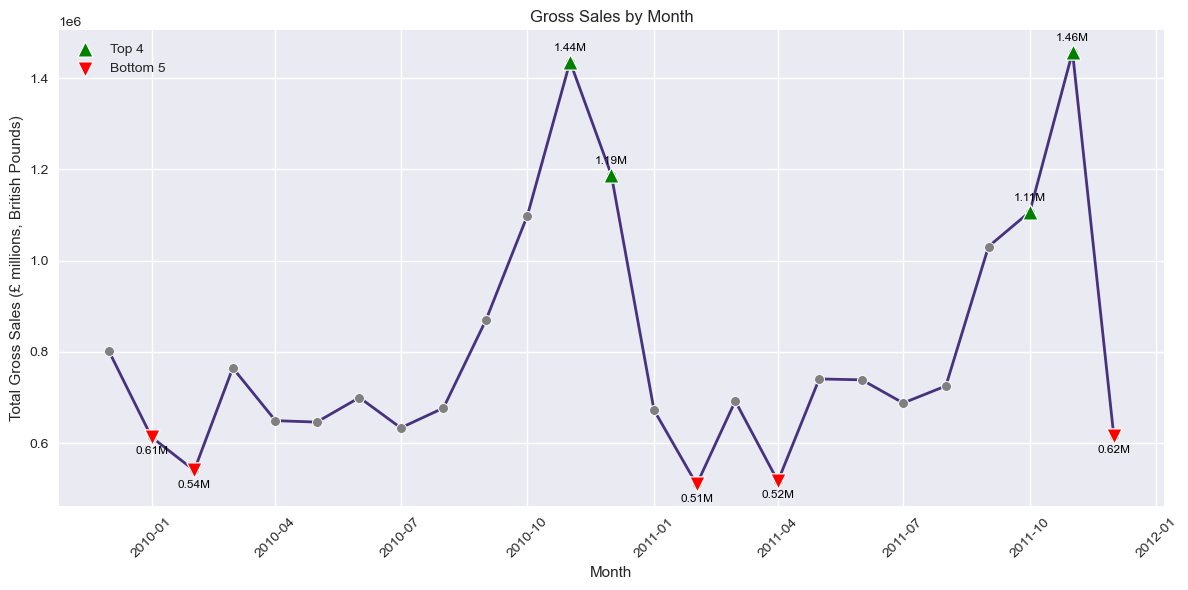

In [58]:
# Selecting months with highest and lowest gross sales
top4_spm = invoices_per_month.nlargest(4, 'Total Gross Sales')
bottom5_spm = invoices_per_month.nsmallest(5, 'Total Gross Sales')

# Validating integrity
df_check(invoices_per_month, col_num='Total Gross Sales', col_date='Period', negative=False)

# Creating lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=invoices_per_month,
    x='Period',
    y='Total Gross Sales',
    marker='o',
    color='C0',
    linewidth=2,
    zorder=1
)

# Plotting all points
sns.scatterplot(
    data=invoices_per_month, x='Period', y='Total Gross Sales', color='gray', s=50, ax=ax, zorder=2
)

# Highlighting Top 4
sns.scatterplot(
    data=top4_spm, x='Period', y='Total Gross Sales', color='green', marker='^', s=120, label='Top 4', ax=ax, zorder=5
)

# Highlighting Bottom 5
sns.scatterplot(
    data=bottom5_spm, x='Period', y='Total Gross Sales', color='red', marker='v', s=120, label='Bottom 5', ax=ax, zorder=5
)

# Adding labels for Top 4
for _, row in top4_spm.iterrows():
    date = row['Period']
    value = row['Total Gross Sales']
    ax.text(date, value+20000, f'{value/1e6:,.2f}M',
           ha='center', va='bottom', fontsize=8.5, color='black')

# Adding labels for Bottom 5
for _, row in bottom5_spm.iterrows():
    date = row['Period']
    value = row['Total Gross Sales']
    ax.text(date, value-20000, f'{value/1e6:,.2f}M',
            ha='center', va='top', fontsize=8.5, color='black')

# Customizing chart format
plt.title('Gross Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Gross Sales (£ millions, British Pounds)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

The evolution of **monthly gross sales** closely follows the pattern seen in invoice counts, though with some interesting differences.

In **2010**, the **second-highest invoice volume** was recorded in **October**, but in terms of **gross sales**, **December** took that spot. In **2011**, the **peaks for both invoices and sales coincided**, occurring in the **last quarter**.

On the other end, **the months with lowest activity in 2010 were January and February**, both in orders and sales, though the order varies slightly between metrics. In **2011**, the **lowest order counts** also occurred in **January and February**; however, in **gross sales**, **February** was the **lowest**, followed by April. This aligns with the fact that **April 2011** shows the **lowest gross average ticket** in the entire series.

One of the **most interesting findings is December 2011**, which, despite having the **lowest number of orders** and being among the **lowest in gross sales**, records the **highest gross average ticket** of the entire period analyzed. This could indicate an operational or commercial restructuring, where only high-value orders were prioritized, possibly as an efficiency measure or due to internal capacity restrictions.

#### 10.2. Return patterns

The SQL query to build the returns table follows the same format as before, with the difference that this time we filter only invoices starting with `'C'`, since those represent **returns** in the dataset.

In [59]:
# Getting monthly returns, their percentage, and total value
query = """
SELECT "Year_Month" AS "Period",
    COUNT(DISTINCT "Invoice") AS "Number of Returns",
    ROUND(100.0 * COUNT(DISTINCT "Invoice") / (
        SELECT COUNT(DISTINCT "Invoice")
        FROM retail AS r2
        WHERE r2."Quantity" > 0
          AND r2."Year_Month" = retail."Year_Month"
    ), 2) AS "Percentage of Sales Returned",
    SUM("LineTotal") AS "Total Returned Value"
FROM retail
WHERE "Invoice" LIKE 'C%'
GROUP BY "Period";
"""

# Converting query result into a DataFrame, formatting it, and displaying results
returns_per_month = pd.read_sql_query(query, engine)
returns_per_month['Number of Returns'] = returns_per_month['Number of Returns'].map('{:,}'.format)
returns_per_month['Total Returned Value'] = returns_per_month['Total Returned Value'].map('{:,.0f}'.format)
display(returns_per_month)

Period Number of Returns  Percentage of Sales Returned  \
0   2009-12-01               379                         22.75   
1   2010-01-01               241                         23.02   
2   2010-02-01               219                         18.42   
3   2010-03-01               352                         21.37   
4   2010-04-01               263                         18.34   
5   2010-05-01               387                         26.08   
6   2010-06-01               319                         19.79   
7   2010-07-01               314                         20.84   
8   2010-08-01               242                         17.26   
9   2010-09-01               318                         17.80   
10  2010-10-01               408                         18.18   
11  2010-11-01               543                         19.99   
12  2010-12-01               301                         19.41   
13  2011-01-01               247                         22.85   
14  2011-02-01               191                         17.47   
15  2011-03-01               281                         19.51   
16  2011-04-01               220                         17.84   
17  2011-05-01               267                         16.03   
18  2011-06-01               298                         19.57   
19  2011-07-01               235                         16.24   
20  2011-08-01               240                         17.94   
21  2011-09-01               299                         16.45   
22  2011-10-01               308                         15.36   
23  2011-11-01               396                         14.41   
24  2011-12-01               137                         16.79   

   Total Returned Value  
0               -19,561  
1                -7,466  
2               -12,584  
3                -9,707  
4               -10,025  
5               -37,294  
6               -26,394  
7               -17,133  
8               -12,419  
9               -27,768  
10              -25,625  
11              -35,159  
12              -24,471  
13              -91,576  
14               -8,376  
15              -10,675  
16              -33,317  
17               -8,948  
18              -13,767  
19              -11,394  
20              -22,930  
21              -17,045  
22              -43,992  
23              -25,011  
24             -174,127

For consistency, I’ll add an extra data label in the returns charts to keep the **visual pattern** aligned with previous figures.

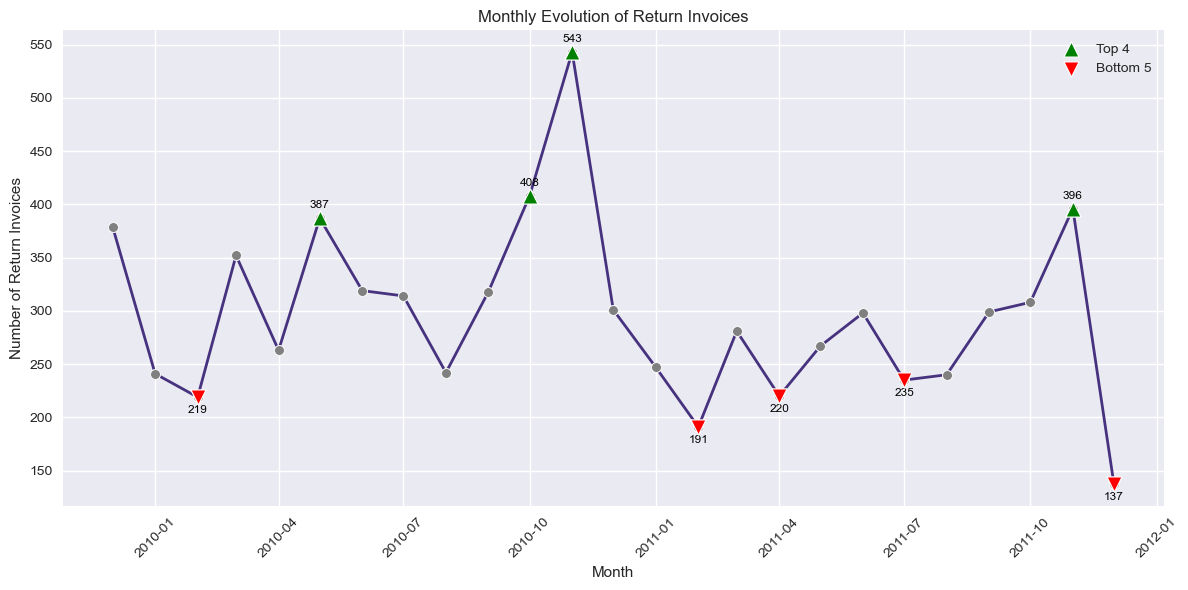

In [60]:
# Converting values back to float
try:
    returns_per_month['Number of Returns'] = returns_per_month['Number of Returns'].str.replace(',','').astype(float)
    returns_per_month['Total Returned Value'] = returns_per_month['Total Returned Value'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Converting months to datetime
returns_per_month['Period'] = pd.to_datetime(returns_per_month['Period'], format='%Y-%m-%d')

# Selecting months with highest and lowest number of return invoices
top4_rpm = returns_per_month.nlargest(4, 'Number of Returns')
bottom5_rpm = returns_per_month.nsmallest(5, 'Number of Returns')

# Validating integrity
df_check(returns_per_month, col_num='Number of Returns', col_date='Period', negative=True)

# Creating lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=returns_per_month,
    x='Period',
    y='Number of Returns',
    marker='o',
    color='C0',
    linewidth=2,
    zorder=1
)

# Plotting all points
sns.scatterplot(
    data=returns_per_month, x='Period', y='Number of Returns', color='gray', s=50, ax=ax, zorder=2
)

# Highlighting Top 4
sns.scatterplot(
    data=top4_rpm, x='Period', y='Number of Returns', color='green', marker='^', s=120, label='Top 4', ax=ax, zorder=5
)

# Highlighting Bottom 5
sns.scatterplot(
    data=bottom5_rpm, x='Period', y='Number of Returns', color='red', marker='v', s=120, label='Bottom 5', ax=ax, zorder=5
)

# Adding labels for Top 4
for _, row in top4_rpm.iterrows():
    date = row['Period']
    value = row['Number of Returns']
    ax.text(date, value+7.5, f'{value:,.0f}',
           ha='center', va='bottom', fontsize=8.5, color='black')

# Adding labels for Bottom 5
for _, row in bottom5_rpm.iterrows():
    date = row['Period']
    value = row['Number of Returns']
    ax.text(date, value-7.5, f'{value:,.0f}',
            ha='center', va='top', fontsize=8.5, color='black')

# Customizing chart
plt.title('Monthly Evolution of Return Invoices')
plt.xlabel('Month')
plt.ylabel('Number of Return Invoices')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

The monthly distribution of returns follows a pattern similar to the orders chart, with **peaks in the last months of the year**. This makes sense: as the order volume increases, the absolute number of returns also rises, even if the return rate itself doesn’t necessarily increase.

**Lower values** appear mostly at the beginning of the year, post-holiday, when commercial activity tends to slow down.

However, this view isn’t the most precise way to assess returns, since it only reflects **processing load** relative to orders, not the return **rate** itself.

To properly visualize the **return rate**, I’ll plot the percentage of returns relative to the total sales invoices for each month.

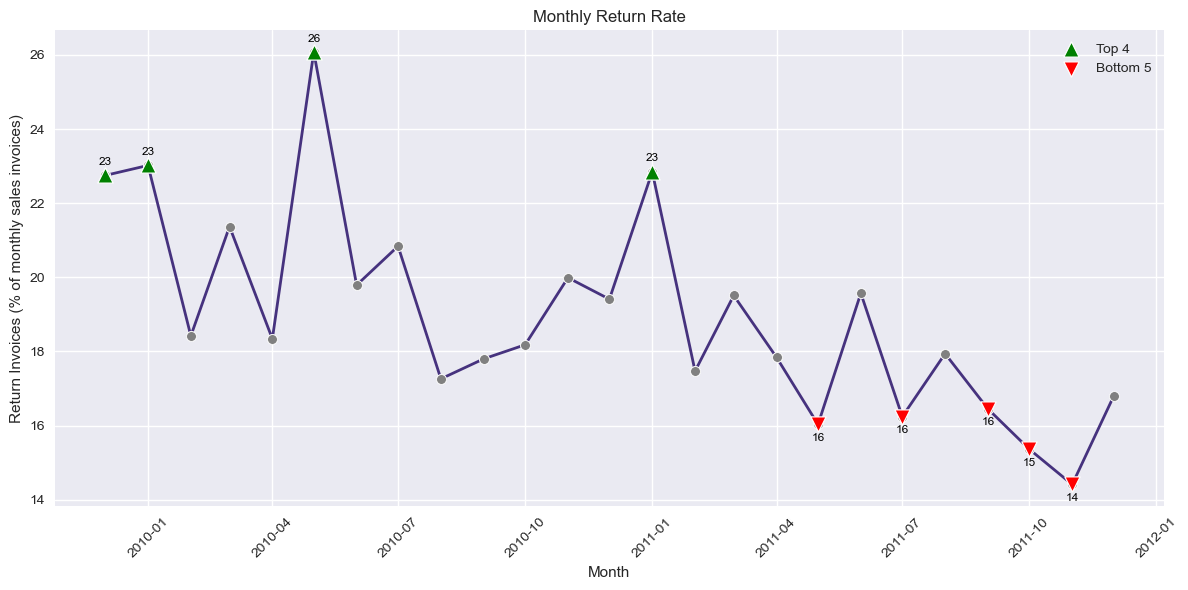

In [61]:
# Selecting months with highest and lowest return rates
top4_prpm = returns_per_month.nlargest(4, 'Percentage of Sales Returned')
bottom5_prpm = returns_per_month.nsmallest(5, 'Percentage of Sales Returned')

# Validating integrity
df_check(returns_per_month, col_num='Percentage of Sales Returned', col_date='Period', negative=False)

# Creating lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=returns_per_month,
    x='Period',
    y='Percentage of Sales Returned',
    marker='o',
    color='C0',
    linewidth=2,
    zorder=1
)

# Plotting all points
sns.scatterplot(
    data=returns_per_month, x='Period', y='Percentage of Sales Returned', color='gray', s=50, ax=ax, zorder=2
)

# Highlighting Top 4
sns.scatterplot(
    data=top4_prpm, x='Period', y='Percentage of Sales Returned', color='green', marker='^', s=120, label='Top 4', ax=ax, zorder=5
)

# Highlighting Bottom 5
sns.scatterplot(
    data=bottom5_prpm, x='Period', y='Percentage of Sales Returned', color='red', marker='v', s=120, label='Bottom 5', ax=ax, zorder=5
)

# Adding labels for Top 4
for _, row in top4_prpm.iterrows():
    date = row['Period']
    value = row['Percentage of Sales Returned']
    ax.text(date, value+0.225, f'{value:,.0f}',
           ha='center', va='bottom', fontsize=8.5, color='black')

# Adding labels for Bottom 5
for _, row in bottom5_prpm.iterrows():
    date = row['Period']
    value = row['Percentage of Sales Returned']
    ax.text(date, value-0.225, f'{value:,.0f}',
            ha='center', va='top', fontsize=8.5, color='black')

# Customizing chart
plt.title('Monthly Return Rate')
plt.xlabel('Month')
plt.ylabel('Return Invoices (% of monthly sales invoices)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

The **return rate** over total orders shows a **variable trend** with clear spikes, for example **January and May 2010, and January 2011**. These could be tied to higher order volumes in prior periods, which lift the relative share of returns.

There’s also a **downward trend toward the end of 2011**, suggesting that although orders continue, returns become less frequent. This might reflect internal process improvements, higher customer satisfaction, or changes to return policies.

To close the returns analysis, I plot a *line chart of the total monetary value returned* over time. This helps pinpoint periods with the **largest financial impact** from returns and how they relate to overall order behavior.

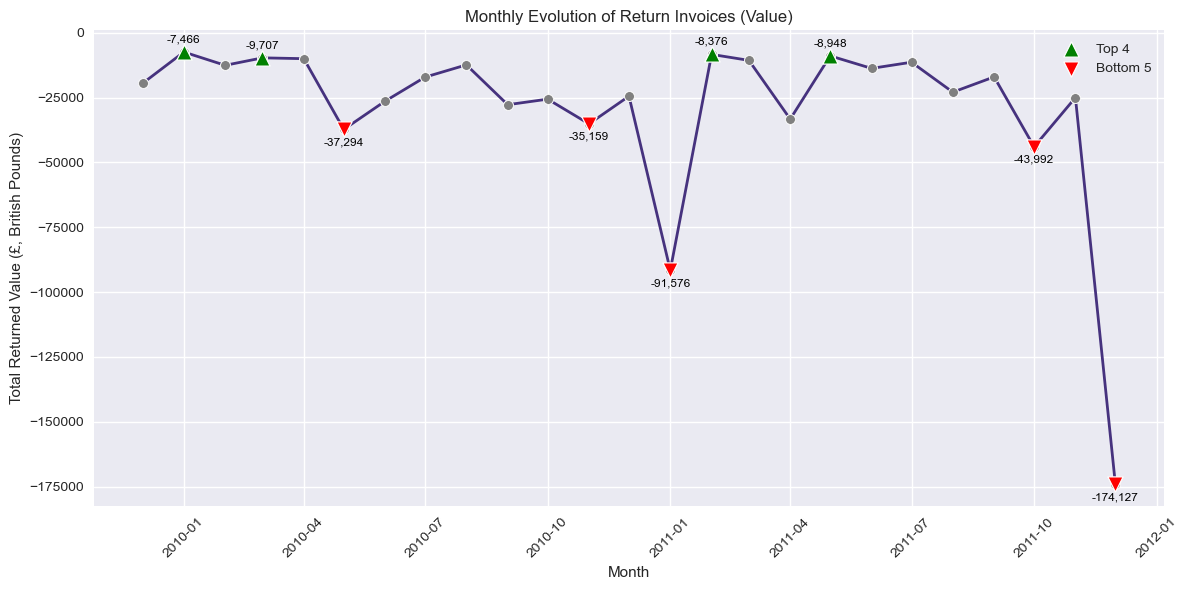

In [62]:
# Selecting months with highest and lowest returned value
top4_rvpm = returns_per_month.nlargest(4, 'Total Returned Value')
bottom5_rvpm = returns_per_month.nsmallest(5, 'Total Returned Value')

# Validating integrity
df_check(returns_per_month, col_num='Total Returned Value', col_date='Period', negative=True)

# Creating lineplot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=returns_per_month,
    x='Period',
    y='Total Returned Value',
    marker='o',
    color='C0',
    linewidth=2,
    zorder=1
)

# Plotting all points
sns.scatterplot(
    data=returns_per_month, x='Period', y='Total Returned Value', color='gray', s=50, ax=ax, zorder=2
)

# Highlighting Top 4
sns.scatterplot(
    data=top4_rvpm, x='Period', y='Total Returned Value', color='green', marker='^', s=120, label='Top 4', ax=ax, zorder=5
)

# Highlighting Bottom 5
sns.scatterplot(
    data=bottom5_rvpm, x='Period', y='Total Returned Value', color='red', marker='v', s=120, label='Bottom 5', ax=ax, zorder=5
)

# Adding labels for Top 4
for _, row in top4_rvpm.iterrows():
    date = row['Period']
    value = row['Total Returned Value']
    ax.text(date, value+3000, f'{value:,.0f}',
           ha='center', va='bottom', fontsize=8.5, color='black')

# Adding labels for Bottom 5
for _, row in bottom5_rvpm.iterrows():
    date = row['Period']
    value = row['Total Returned Value']
    ax.text(date, value-3000, f'{value:,.0f}',
            ha='center', va='top', fontsize=8.5, color='black')

# Customizing chart
plt.title('Monthly Evolution of Return Invoices (Value)')
plt.xlabel('Month')
plt.ylabel('Total Returned Value (£, British Pounds)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In absolute terms, most months show **moderate losses** of **under £50k**, with two sharp drops standing out: **January 2011 and December 2011**, the latter being the **lowest point** in the entire period.

The **most favorable months** (lowest economic impact from returns) cluster in the **first months of each year**, such as January and February 2010, and January and March 2011, with amounts near or below **£10k**.

Overall, the data suggests that while the **number of returns** follows **patterns similar to orders**, the **monetary impact** isn’t always aligned. Some months with few returns still show high returned value due to **higher-priced products**.

---
### 11. Question 9: Which products are most frequently returned?

In this question, the goal is to identify the products with the highest number of returns during the analyzed period.  

The focus is on the **frequency of returns per invoice**, in other words, how many unique sales ended up being returned at least once.  

This criterion highlights the items that generate the **largest number of customer issues**, regardless of the number of units returned.

#### 11.1. General analysis

To answer this, I used the count of **unique invoices** (`COUNT(DISTINCT "Invoice")`) that recorded at least one return of each product. This way, if a customer returned the same item multiple times within a single invoice, it is only counted once.  

Along with the invoice count, the **total returned value** is shown, which helps dimension the economic impact of these returns.  

In [63]:
# Getting products by total return invoices
query = """
SELECT "Description", 
    COUNT(DISTINCT "Invoice") AS "Return Invoices",
    SUM("LineTotal") AS "Total Returned Value"
FROM retail
WHERE "Quantity" < 0
GROUP BY "Description"
ORDER BY "Return Invoices" DESC;
"""

# Converting query result into DataFrame
returns = pd.read_sql_query(query, engine)

# Copying DataFrame and showing the top 10
top_returns = returns.head(10).copy()

# Formatting columns and displaying results
top_returns['Total Returned Value'] = top_returns['Total Returned Value'].map('{:,.0f}'.format)
display(top_returns)

Description  Return Invoices Total Returned Value
0            REGENCY CAKESTAND 3 TIER              341              -16,750
1        BAKING SET 9 PIECE RETROSPOT              209               -4,073
2      STRAWBERRY CERAMIC TRINKET BOX              183               -1,105
3            RED RETROSPOT CAKE STAND              154               -5,402
4  WHITE HANGING HEART T-LIGHT HOLDER              134               -9,390
5                 WHITE CHERRY LIGHTS              124               -6,421
6    RED RETROSPOT TRADITIONAL TEAPOT              114               -1,424
7                SMALL POPCORN HOLDER               90                 -621
8                  PINK CHERRY LIGHTS               86               -4,021
9            JAM MAKING SET WITH JARS               86               -1,043

For the visualization, I use a horizontal *barplot* to show the **Top 10 most returned products** based on their incidence in **unique invoices**.

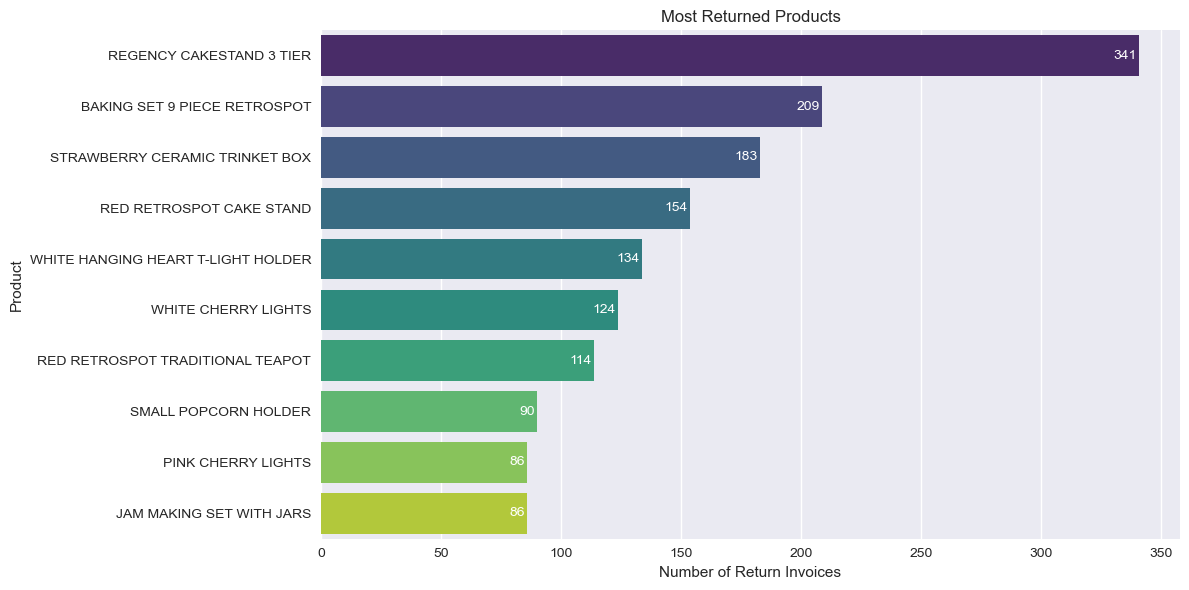

In [64]:
# Converting values back to float
try:
    top_returns['Total Returned Value'] = returns['Total Returned Value'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validating integrity
df_check(top_returns, col_num='Return Invoices', col_text='Description', negative=False)

# Creating barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_returns,
    x='Return Invoices',
    y='Description',
    hue='Description',
    palette='viridis',
    legend=False
)

# Adding data labels
for i, value in enumerate(top_returns['Return Invoices']):
    ax.text(value-1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Customizing chart format
plt.title('Most Returned Products')
plt.xlabel('Number of Return Invoices')
plt.ylabel('Product')
plt.tight_layout()
plt.show() 

The chart shows that the product **"REGENCY CAKESTAND 3 TIER"** tops the list, which makes sense given that it is also one of the best-selling items in the dataset.

It is noteworthy, however, that most products on the ranking are **not among the top sellers**, which may suggest issues with the items themselves (e.g., manufacturing defects) or with how they are described in the catalog, potentially causing confusion for customers.

Considering that there are **two distinct markets**, the United Kingdom as the primary and the rest of the world as the secondary, I will now analyze the differences in return behavior between the two.

#### 11.2. Results in the United Kingdom

The SQL query follows the same format as the general one, but considers only **unique return invoices** where the country is **United Kingdom**.

In [65]:
# Getting products by total return invoices in the UK
query = """
SELECT "Description", 
    COUNT(DISTINCT "Invoice") AS "Return Invoices",
    SUM("LineTotal") AS "Total Returned Value"
FROM retail
WHERE "Quantity" < 0
    AND "Country" = "United Kingdom"
GROUP BY "Description"
ORDER BY "Return Invoices" DESC;
"""

# Converting query result into DataFrame
uk_returns = pd.read_sql_query(query, engine)

# Copying DataFrame and showing the top 10
top_uk_returns = uk_returns.head(10).copy()

# Formatting columns and displaying results
top_uk_returns['Total Returned Value'] = top_uk_returns['Total Returned Value'].map('{:,.0f}'.format)
display(top_uk_returns)

Description  Return Invoices Total Returned Value
0            REGENCY CAKESTAND 3 TIER              281              -13,813
1        BAKING SET 9 PIECE RETROSPOT              177               -3,204
2      STRAWBERRY CERAMIC TRINKET BOX              155               -1,011
3  WHITE HANGING HEART T-LIGHT HOLDER              129               -9,193
4            RED RETROSPOT CAKE STAND              129               -4,878
5                 WHITE CHERRY LIGHTS              124               -6,421
6    RED RETROSPOT TRADITIONAL TEAPOT               95               -1,209
7                  PINK CHERRY LIGHTS               86               -4,021
8  WOOD 2 DRAWER CABINET WHITE FINISH               80               -1,508
9             JUMBO BAG RED RETROSPOT               79               -2,145

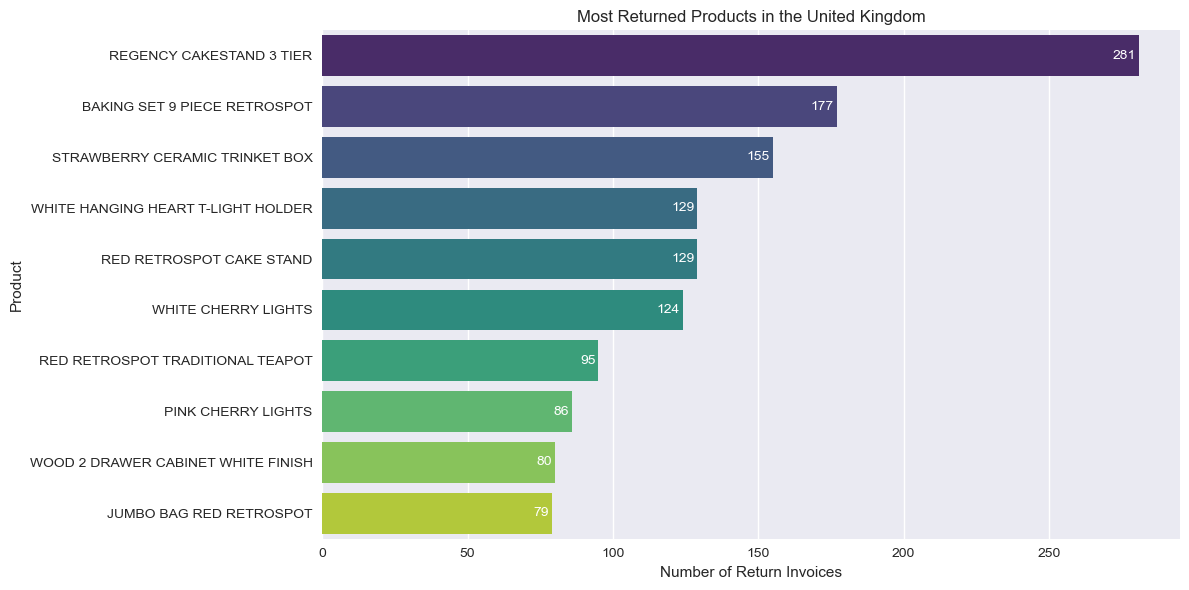

In [66]:
# Converting values back to float
try:
    top_uk_returns['Return Invoices'] = top_uk_returns['Return Invoices'].str.replace(',', '').astype(float)
    top_uk_returns['Total Returned Value'] = top_uk_returns['Total Returned Value'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validating integrity
df_check(top_uk_returns, col_num='Return Invoices', col_text='Description', negative=False)

# Creating barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_uk_returns,
    x='Return Invoices',
    y='Description',
    hue='Description',
    palette='viridis',
    legend=False
)

# Adding data labels
for i, value in enumerate(top_uk_returns['Return Invoices']):
    ax.text(value-1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Customizing chart format
plt.title('Most Returned Products in the United Kingdom')
plt.xlabel('Number of Return Invoices')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

It is clear that the **United Kingdom** sets the tone for the dataset’s overall trend, as it includes **8 out of the 10 products** present in the general analysis. Moreover, the **top 3 most returned products** match exactly those observed in the chart considering **all countries**.

#### 11.3. Results in the Rest of the World

For the **rest of the world** query, all countries are selected **except** those labeled as **United Kingdom**

In [67]:
# Getting products by total return invoices in the Rest of the World
query = """
SELECT "Description", 
    COUNT(DISTINCT "Invoice") AS "Return Invoices",
    SUM("LineTotal") AS "Total Returned Value"
FROM retail
WHERE "Quantity" < 0
    AND "Country" != "United Kingdom"
GROUP BY "Description"
ORDER BY "Return Invoices" DESC;
"""

# Converting query result into DataFrame
rw_returns = pd.read_sql_query(query, engine)

# Copying DataFrame and showing the top 10
top_rw_returns = rw_returns.head(10).copy()

# Formatting columns and displaying results
top_rw_returns['Total Returned Value'] = top_rw_returns['Total Returned Value'].map('{:,.0f}'.format)
display(top_rw_returns)

Description  Return Invoices Total Returned Value
0             REGENCY CAKESTAND 3 TIER               60               -2,937
1         BAKING SET 9 PIECE RETROSPOT               32                 -869
2       STRAWBERRY CERAMIC TRINKET BOX               28                  -94
3                    GUMBALL COAT RACK               28                 -294
4  SET/5 RED RETROSPOT LID GLASS BOWLS               25                 -143
5             RED RETROSPOT CAKE STAND               25                 -524
6                    GLASS BEURRE DISH               21                  -94
7        CHILDS BREAKFAST SET SPACEBOY               20                 -514
8     RED RETROSPOT TRADITIONAL TEAPOT               19                 -215
9    ROUND SNACK BOXES SET OF 4 FRUITS               16               -1,700

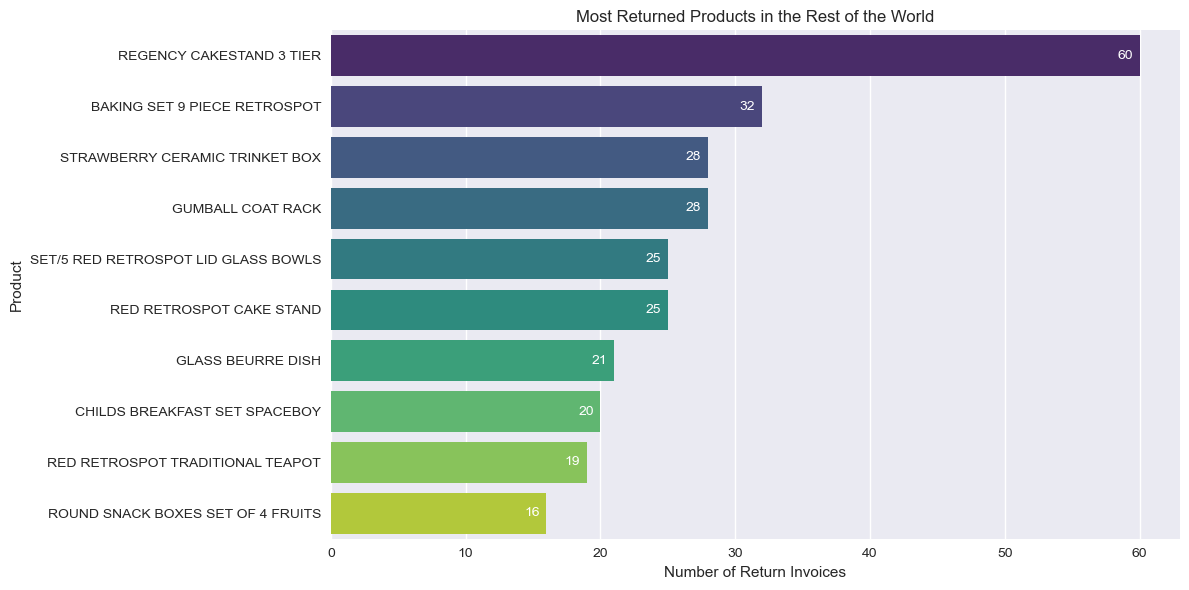

In [68]:
# Converting values back to float
try:
    top_rw_returns['Return Invoices'] = top_rw_returns['Return Invoices'].str.replace(',', '').astype(float)
    top_rw_returns['Total Returned Value'] = top_rw_returns['Total Returned Value'].str.replace(',','').astype(float)
except AttributeError:
    pass

# Validating integrity
df_check(top_rw_returns, col_num='Return Invoices', col_text='Description', negative=False)

# Creating barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_rw_returns,
    x='Return Invoices',
    y='Description',
    hue='Description',
    palette='viridis',
    legend=False
)

# Adding data labels
for i, value in enumerate(top_rw_returns['Return Invoices']):
    ax.text(value-0.5, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Customizing chart format
plt.title('Most Returned Products in the Rest of the World')
plt.xlabel('Number of Return Invoices')
plt.ylabel('Product')
plt.tight_layout()
plt.show()

In the case of the **rest of the world**, the picture changes. The **top three products** with the most returns remain the same, but the rest of the items in the *Top 10* differ from the global table, which indicates a **different return behavior** outside the UK market.

---
### 12. Question 10: Which products are often purchased together?

In this section, I analyze which **product combinations** most frequently appear on invoices, with the aim of identifying joint purchase patterns.

#### 12.1. General analysis

The following code counts the **combinations of products** that are sold together in the **same invoice**.  

First, it groups products by invoice and **removes duplicates**. Then, it generates **all possible 2-product combinations** and counts how many times each pair appears. Finally, it displays the 30 most frequent pairs in a tabular format for analysis.  

Because of the large number of **possible combinations**, processing this cell may take a few minutes.  

In [69]:
# Importing required libraries for basket analysis
from itertools import combinations
from collections import Counter

# Grouping products by invoice in the general DataFrame
basket_df = df.groupby('Invoice')['Description'].apply(list)

# Counting 2-product combinations
pairs_counter = Counter()
for basket in basket_df:
    unique_products = list(set(basket))  # evitar duplicados
    for pair in combinations(sorted(unique_products), 2):
        pairs_counter[pair] += 1

# Showing the 30 most frequent pairs
top_pairs = pairs_counter.most_common(30)

# Converting query result into a DataFrame, formatting it, and displaying results
top_pairs_df = pd.DataFrame(top_pairs, columns=['Product Pair', 'Count'])
top_pairs_df[['Product A', 'Product B']] = pd.DataFrame(top_pairs_df['Product Pair'].tolist(), index=top_pairs_df.index)
top_pairs_df = top_pairs_df[['Product A', 'Product B', 'Count']]
display(top_pairs_df)

Product A                           Product B  \
0              JUMBO BAG PINK POLKADOT             JUMBO BAG RED RETROSPOT   
1              JUMBO BAG RED RETROSPOT              JUMBO STORAGE BAG SUKI   
2     RED HANGING HEART T-LIGHT HOLDER  WHITE HANGING HEART T-LIGHT HOLDER   
3               LUNCH BAG BLACK SKULL.             LUNCH BAG RED RETROSPOT   
4          60 TEATIME FAIRY CAKE CASES     PACK OF 72 RETROSPOT CAKE CASES   
5              JUMBO BAG RED RETROSPOT                JUMBO BAG STRAWBERRY   
6              LUNCH BAG RED RETROSPOT               LUNCH BAG SUKI DESIGN   
7              LUNCH BAG PINK POLKADOT             LUNCH BAG RED RETROSPOT   
8              JUMBO BAG RED RETROSPOT   JUMBO SHOPPER VINTAGE RED PAISLEY   
9       STRAWBERRY CERAMIC TRINKET BOX      SWEETHEART CERAMIC TRINKET BOX   
10       JUMBO BAG BAROQUE BLACK WHITE             JUMBO BAG RED RETROSPOT   
11          WOODEN FRAME ANTIQUE WHITE   WOODEN PICTURE FRAME WHITE FINISH   
12             JUMBO BAG RED RETROSPOT             LUNCH BAG RED RETROSPOT   
13  PACK OF 60 PINK PAISLEY CAKE CASES     PACK OF 72 RETROSPOT CAKE CASES   
14         CHARLOTTE BAG PINK POLKADOT         RED RETROSPOT CHARLOTTE BAG   
15                 LUNCH BAG CARS BLUE             LUNCH BAG RED RETROSPOT   
16     GREEN REGENCY TEACUP AND SAUCER     ROSES REGENCY TEACUP AND SAUCER   
17             LUNCH BAG RED RETROSPOT                  LUNCH BAG WOODLAND   
18           LUNCH BAG SPACEBOY DESIGN               LUNCH BAG SUKI DESIGN   
19              LUNCH BAG BLACK SKULL.               LUNCH BAG SUKI DESIGN   
20             LUNCH BAG RED RETROSPOT           LUNCH BAG SPACEBOY DESIGN   
21               HEART OF WICKER LARGE               HEART OF WICKER SMALL   
22           CHARLOTTE BAG SUKI DESIGN         RED RETROSPOT CHARLOTTE BAG   
23              LUNCH BAG BLACK SKULL.             LUNCH BAG PINK POLKADOT   
24                 LUNCH BAG CARS BLUE               LUNCH BAG SUKI DESIGN   
25             JUMBO BAG RED RETROSPOT  WHITE HANGING HEART T-LIGHT HOLDER   
26             JUMBO BAG RED RETROSPOT      JUMBO BAG SCANDINAVIAN PAISLEY   
27         RED RETROSPOT CHARLOTTE BAG              WOODLAND CHARLOTTE BAG   
28         60 TEATIME FAIRY CAKE CASES  PACK OF 60 PINK PAISLEY CAKE CASES   
29      JUMBO BAG PINK VINTAGE PAISLEY             JUMBO BAG RED RETROSPOT   

    Count  
0    1440  
1    1338  
2    1256  
3    1213  
4    1202  
5    1200  
6    1185  
7    1169  
8    1167  
9    1141  
10   1124  
11   1124  
12   1120  
13   1113  
14   1084  
15   1057  
16   1054  
17   1039  
18   1029  
19   1016  
20   1007  
21   1003  
22    964  
23    958  
24    948  
25    935  
26    932  
27    930  
28    925  
29    920

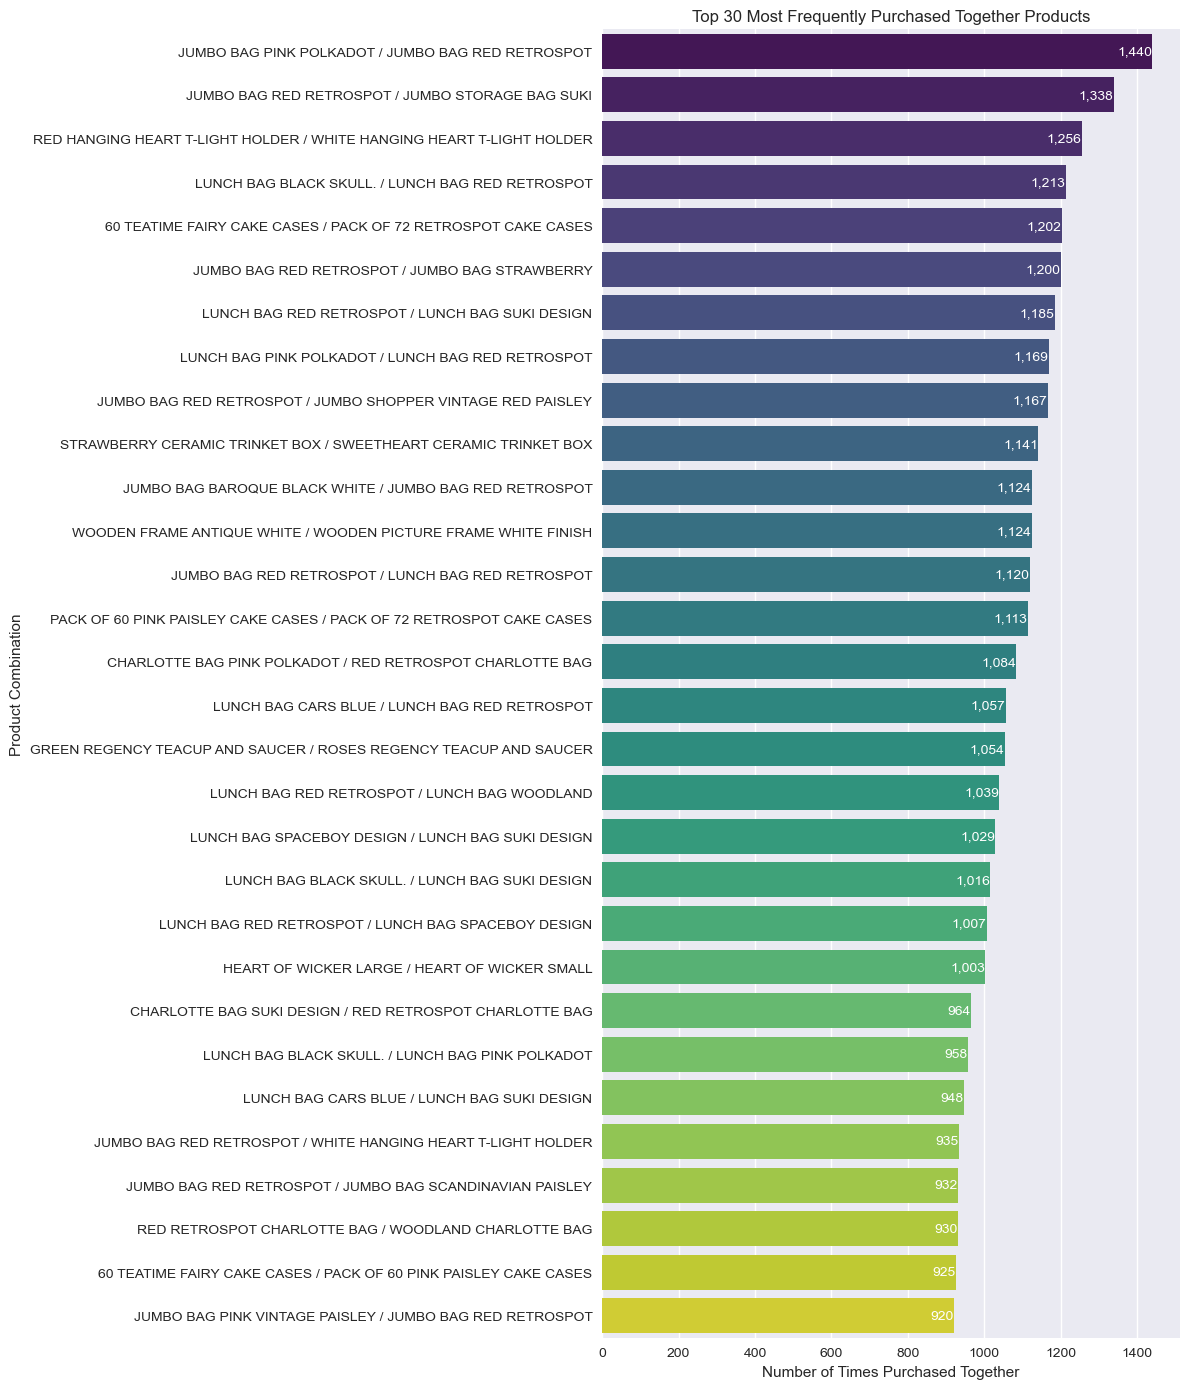

In [70]:
# Concatenating pairs
top_pairs_df['Pairs'] = top_pairs_df['Product A'] + ' / ' + top_pairs_df['Product B']

# Saving DataFrame in CSV format for dashboard visualizations
tpdf_save_path = BASE_DIR / 'data' / 'top_pairs.csv'
top_pairs_df.to_csv(tpdf_save_path, index=False)

# Validating integrity
df_check(top_pairs_df, col_num='Count', col_text='Pairs', negative=False)

# Creating barplot
plt.figure(figsize=(12, 14))
ax = sns.barplot(
    data=top_pairs_df,
    x='Count',
    y='Pairs',
    hue='Pairs',
    palette='viridis',
    legend=False
)

# Adding data labels
for i, value in enumerate(top_pairs_df['Count']):
    ax.text(value-1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Customizing chart format
plt.title('Top 30 Most Frequently Purchased Together Products')
plt.xlabel('Number of Times Purchased Together')
plt.ylabel('Product Combination')
plt.tight_layout()
plt.show()

From the results, we can see that the most frequently bought pair of products is **JUMBO BAG PINK POLKADOT** and **JUMBO BAG RED RETROSPOT**, appearing **1,440 times** across different invoices. 

Moreover, when analyzing the frequent pairs in more detail, it becomes clear that most products bought together belong to the **same category**, suggesting purchase patterns based on product type or theme.

I will now examine the **behavior in the United Kingdom** to determine whether the most frequent product pairs match the global pattern or show slight variations.

#### 12.2. Results in the United Kingdom

The *pandas* routine applied here is similar to the one used in the global analysis, with the difference that in this case only products sold in the **UK market** are filtered.

In [71]:
# Grouping products by invoice in the UK DataFrame
uk_basket_df = uk_df.groupby('Invoice')['Description'].apply(list)

# Counting 2-product combinations
uk_pairs_counter = Counter()

for basket in uk_basket_df:
    unique_products = list(set(basket))  # evitar duplicados
    for pair in combinations(sorted(unique_products), 2):
        uk_pairs_counter[pair] += 1

# Showing the 30 most frequent pairs
uk_top_pairs = uk_pairs_counter.most_common(30)

# Converting query result into a DataFrame, formatting it, and displaying results
uk_top_pairs_df = pd.DataFrame(uk_top_pairs, columns=['Product Pair', 'Count'])
uk_top_pairs_df[['Product A', 'Product B']] = pd.DataFrame(uk_top_pairs_df['Product Pair'].tolist(), index=uk_top_pairs_df.index)
uk_top_pairs_df = uk_top_pairs_df[['Product A', 'Product B', 'Count']]
display(uk_top_pairs_df)

Product A                           Product B  \
0              JUMBO BAG PINK POLKADOT             JUMBO BAG RED RETROSPOT   
1              JUMBO BAG RED RETROSPOT              JUMBO STORAGE BAG SUKI   
2     RED HANGING HEART T-LIGHT HOLDER  WHITE HANGING HEART T-LIGHT HOLDER   
3               LUNCH BAG BLACK SKULL.             LUNCH BAG RED RETROSPOT   
4              JUMBO BAG RED RETROSPOT                JUMBO BAG STRAWBERRY   
5              JUMBO BAG RED RETROSPOT   JUMBO SHOPPER VINTAGE RED PAISLEY   
6           WOODEN FRAME ANTIQUE WHITE   WOODEN PICTURE FRAME WHITE FINISH   
7          60 TEATIME FAIRY CAKE CASES     PACK OF 72 RETROSPOT CAKE CASES   
8        JUMBO BAG BAROQUE BLACK WHITE             JUMBO BAG RED RETROSPOT   
9              LUNCH BAG RED RETROSPOT               LUNCH BAG SUKI DESIGN   
10      STRAWBERRY CERAMIC TRINKET BOX      SWEETHEART CERAMIC TRINKET BOX   
11             LUNCH BAG PINK POLKADOT             LUNCH BAG RED RETROSPOT   
12             JUMBO BAG RED RETROSPOT             LUNCH BAG RED RETROSPOT   
13  PACK OF 60 PINK PAISLEY CAKE CASES     PACK OF 72 RETROSPOT CAKE CASES   
14               HEART OF WICKER LARGE               HEART OF WICKER SMALL   
15              LUNCH BAG BLACK SKULL.               LUNCH BAG SUKI DESIGN   
16         CHARLOTTE BAG PINK POLKADOT         RED RETROSPOT CHARLOTTE BAG   
17                 LUNCH BAG CARS BLUE             LUNCH BAG RED RETROSPOT   
18     GREEN REGENCY TEACUP AND SAUCER     ROSES REGENCY TEACUP AND SAUCER   
19           LUNCH BAG SPACEBOY DESIGN               LUNCH BAG SUKI DESIGN   
20              LUNCH BAG BLACK SKULL.             LUNCH BAG PINK POLKADOT   
21             LUNCH BAG RED RETROSPOT                  LUNCH BAG WOODLAND   
22             JUMBO BAG RED RETROSPOT  WHITE HANGING HEART T-LIGHT HOLDER   
23             LUNCH BAG RED RETROSPOT           LUNCH BAG SPACEBOY DESIGN   
24             JUMBO BAG RED RETROSPOT      JUMBO BAG SCANDINAVIAN PAISLEY   
25                 LUNCH BAG CARS BLUE               LUNCH BAG SUKI DESIGN   
26           CHARLOTTE BAG SUKI DESIGN         RED RETROSPOT CHARLOTTE BAG   
27             JUMBO BAG PINK POLKADOT              JUMBO STORAGE BAG SUKI   
28   JUMBO SHOPPER VINTAGE RED PAISLEY              JUMBO STORAGE BAG SUKI   
29      JUMBO BAG PINK VINTAGE PAISLEY             JUMBO BAG RED RETROSPOT   

    Count  
0    1362  
1    1293  
2    1190  
3    1165  
4    1161  
5    1130  
6    1099  
7    1096  
8    1094  
9    1093  
10   1074  
11   1074  
12   1029  
13    997  
14    988  
15    978  
16    967  
17    965  
18    960  
19    947  
20    920  
21    917  
22    911  
23    909  
24    890  
25    888  
26    886  
27    886  
28    881  
29    862

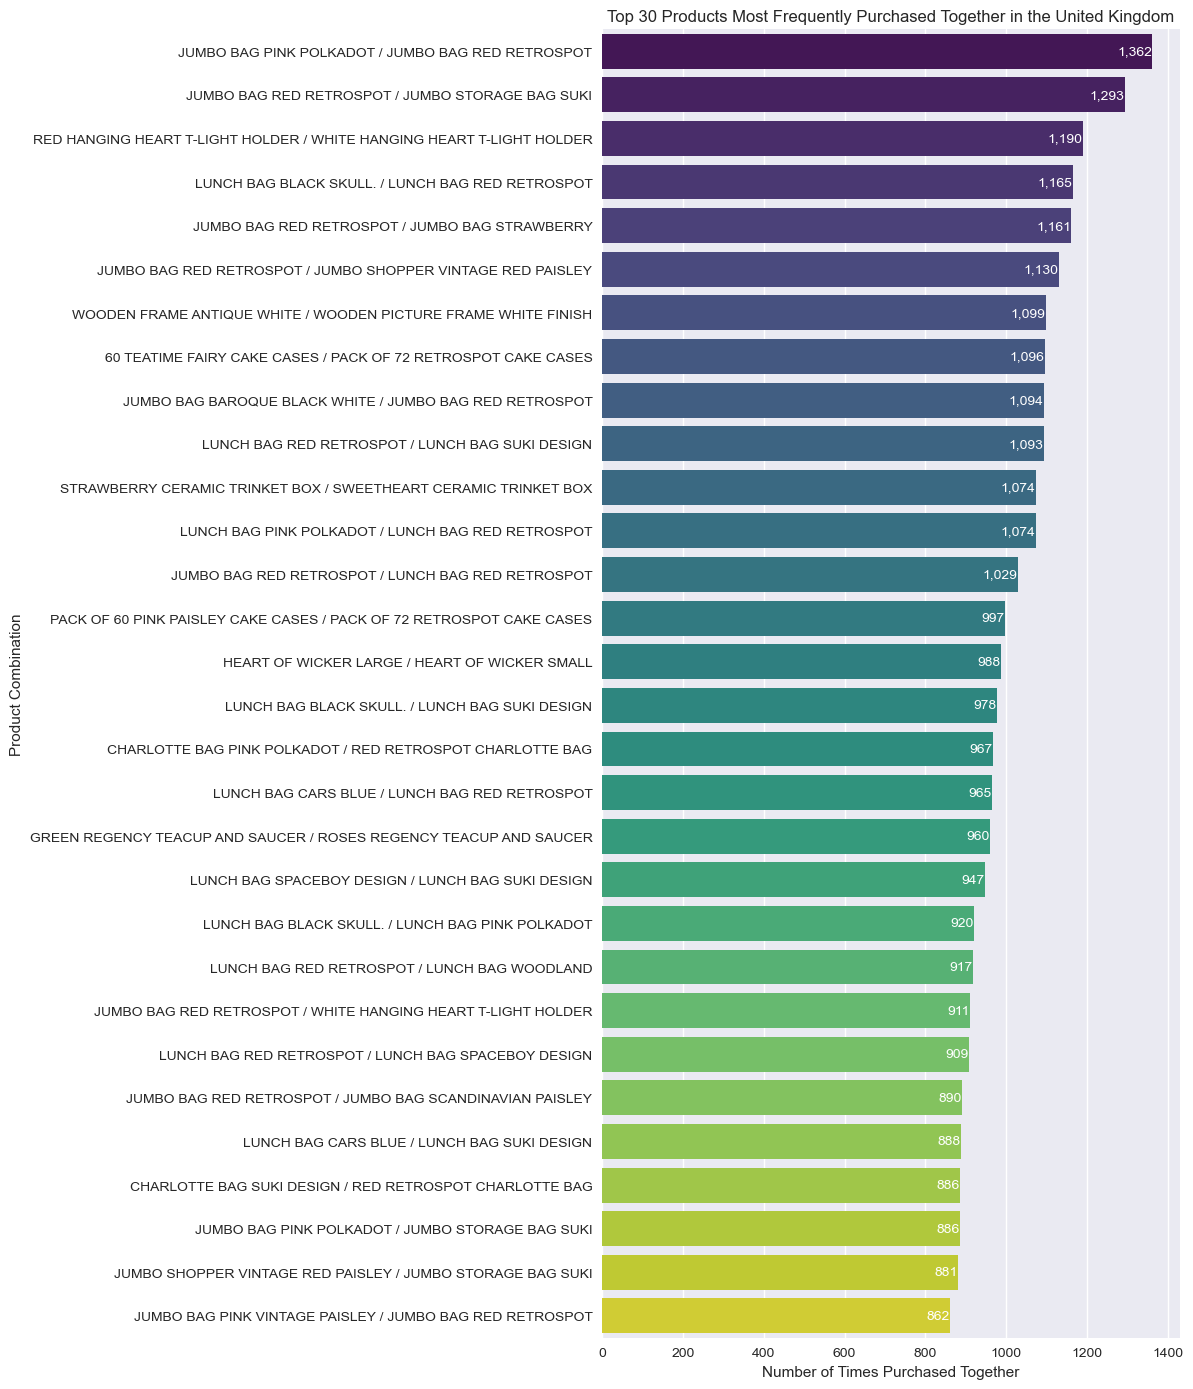

In [72]:
# Concatenating pairs
uk_top_pairs_df['Pairs'] = uk_top_pairs_df['Product A'] + ' / ' + uk_top_pairs_df['Product B']

# Validating integrity
df_check(uk_top_pairs_df, col_num='Count', col_text='Pairs', negative=False)

# Creating barplot
plt.figure(figsize=(12, 14))
ax = sns.barplot(
    data=uk_top_pairs_df,
    x='Count',
    y='Pairs',
    hue='Pairs',
    palette='viridis',
    legend=False
)

# Adding data labels
for i, value in enumerate(uk_top_pairs_df['Count']):
    ax.text(value-1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Customizing chart format
plt.title('Top 30 Products Most Frequently Purchased Together in the United Kingdom')
plt.xlabel('Number of Times Purchased Together')
plt.ylabel('Product Combination')
plt.tight_layout()
plt.show()

The results for the most frequently bought-together products show that **7 of the Top 10 items in this ranking** also appear in the **Global Top 10**.

This confirms that the overall trend is **heavily influenced by the UK market**, as previously observed in earlier sections.  

Finally, to close the exploratory analysis, the procedure will be replicated with the data corresponding to countries **outside the United Kingdom**, in order to **identify whether they present different purchase patterns from the global analysis**.

#### 12.3. Results in the Rest of the World

The *pandas* routine is the same as the one used in the previous analyses of this section. In this case, only transactions from **countries other than the United Kingdom** are filtered.

In [73]:
# Grouping products by invoice in the Rest of the World DataFrame
rw_basket_df = rw_df.groupby('Invoice')['Description'].apply(list)

# Counting 2-product combinations
rw_pairs_counter = Counter()
for basket in rw_basket_df:
    unique_products = list(set(basket))  # evitar duplicados
    for pair in combinations(sorted(unique_products), 2):
        rw_pairs_counter[pair] += 1

# Showing the 30 most frequent pairs
rw_top_pairs = rw_pairs_counter.most_common(30)

# Converting query result into a DataFrame, formatting it, and displaying results
rw_top_pairs_df = pd.DataFrame(rw_top_pairs, columns=['Product Pair', 'Count'])
rw_top_pairs_df[['Product A', 'Product B']] = pd.DataFrame(rw_top_pairs_df['Product Pair'].tolist(), index=rw_top_pairs_df.index)
rw_top_pairs_df = rw_top_pairs_df[['Product A', 'Product B', 'Count']]
display(rw_top_pairs_df)

Product A                           Product B  \
0    ROUND SNACK BOXES SET OF 4 FRUITS  ROUND SNACK BOXES SET OF4 WOODLAND   
1        PLASTERS IN TIN CIRCUS PARADE    PLASTERS IN TIN WOODLAND ANIMALS   
2             PLASTERS IN TIN SPACEBOY    PLASTERS IN TIN WOODLAND ANIMALS   
3                 DOLLY GIRL LUNCH BOX                  SPACEBOY LUNCH BOX   
4        PLASTERS IN TIN CIRCUS PARADE            PLASTERS IN TIN SPACEBOY   
5          RED RETROSPOT CHARLOTTE BAG              WOODLAND CHARLOTTE BAG   
6          SET/6 RED SPOTTY PAPER CUPS       SET/6 RED SPOTTY PAPER PLATES   
7     PLASTERS IN TIN WOODLAND ANIMALS  ROUND SNACK BOXES SET OF4 WOODLAND   
8        PLASTERS IN TIN CIRCUS PARADE           PLASTERS IN TIN STRONGMAN   
9   ROUND SNACK BOXES SET OF4 WOODLAND                  SPACEBOY LUNCH BOX   
10  ROUND SNACK BOXES SET OF4 WOODLAND              WOODLAND CHARLOTTE BAG   
11       RED TOADSTOOL LED NIGHT LIGHT  ROUND SNACK BOXES SET OF4 WOODLAND   
12  SET/20 RED RETROSPOT PAPER NAPKINS       SET/6 RED SPOTTY PAPER PLATES   
13       PLASTERS IN TIN CIRCUS PARADE  ROUND SNACK BOXES SET OF4 WOODLAND   
14    LUNCH BOX WITH CUTLERY RETROSPOT   STRAWBERRY LUNCH BOX WITH CUTLERY   
15             LUNCH BAG RED RETROSPOT                  LUNCH BAG WOODLAND   
16  SET/20 RED RETROSPOT PAPER NAPKINS         SET/6 RED SPOTTY PAPER CUPS   
17         CHARLOTTE BAG PINK POLKADOT         RED RETROSPOT CHARLOTTE BAG   
18            PLASTERS IN TIN SPACEBOY  ROUND SNACK BOXES SET OF4 WOODLAND   
19  PACK OF 60 PINK PAISLEY CAKE CASES     PACK OF 72 RETROSPOT CAKE CASES   
20           PLASTERS IN TIN STRONGMAN    PLASTERS IN TIN WOODLAND ANIMALS   
21  BLUE 3 PIECE MINI DOTS CUTLERY SET  PINK 3 PIECE MINI DOTS CUTLERY SET   
22     PACK OF 72 RETROSPOT CAKE CASES   SET OF 72 RETROSPOT PAPER DOILIES   
23            RED RETROSPOT MINI CASES  ROUND SNACK BOXES SET OF4 WOODLAND   
24       RED TOADSTOOL LED NIGHT LIGHT              WOODLAND CHARLOTTE BAG   
25    LUNCH BOX WITH CUTLERY RETROSPOT  ROUND SNACK BOXES SET OF4 WOODLAND   
26         60 TEATIME FAIRY CAKE CASES     PACK OF 72 RETROSPOT CAKE CASES   
27             JUMBO BAG RED RETROSPOT          JUMBO BAG WOODLAND ANIMALS   
28         RED RETROSPOT CHARLOTTE BAG  ROUND SNACK BOXES SET OF4 WOODLAND   
29            PLASTERS IN TIN SPACEBOY                  SPACEBOY LUNCH BOX   

    Count  
0     242  
1     193  
2     187  
3     182  
4     163  
5     161  
6     154  
7     145  
8     139  
9     137  
10    136  
11    135  
12    130  
13    127  
14    124  
15    122  
16    121  
17    117  
18    117  
19    116  
20    114  
21    112  
22    110  
23    110  
24    109  
25    109  
26    106  
27    105  
28    105  
29    105

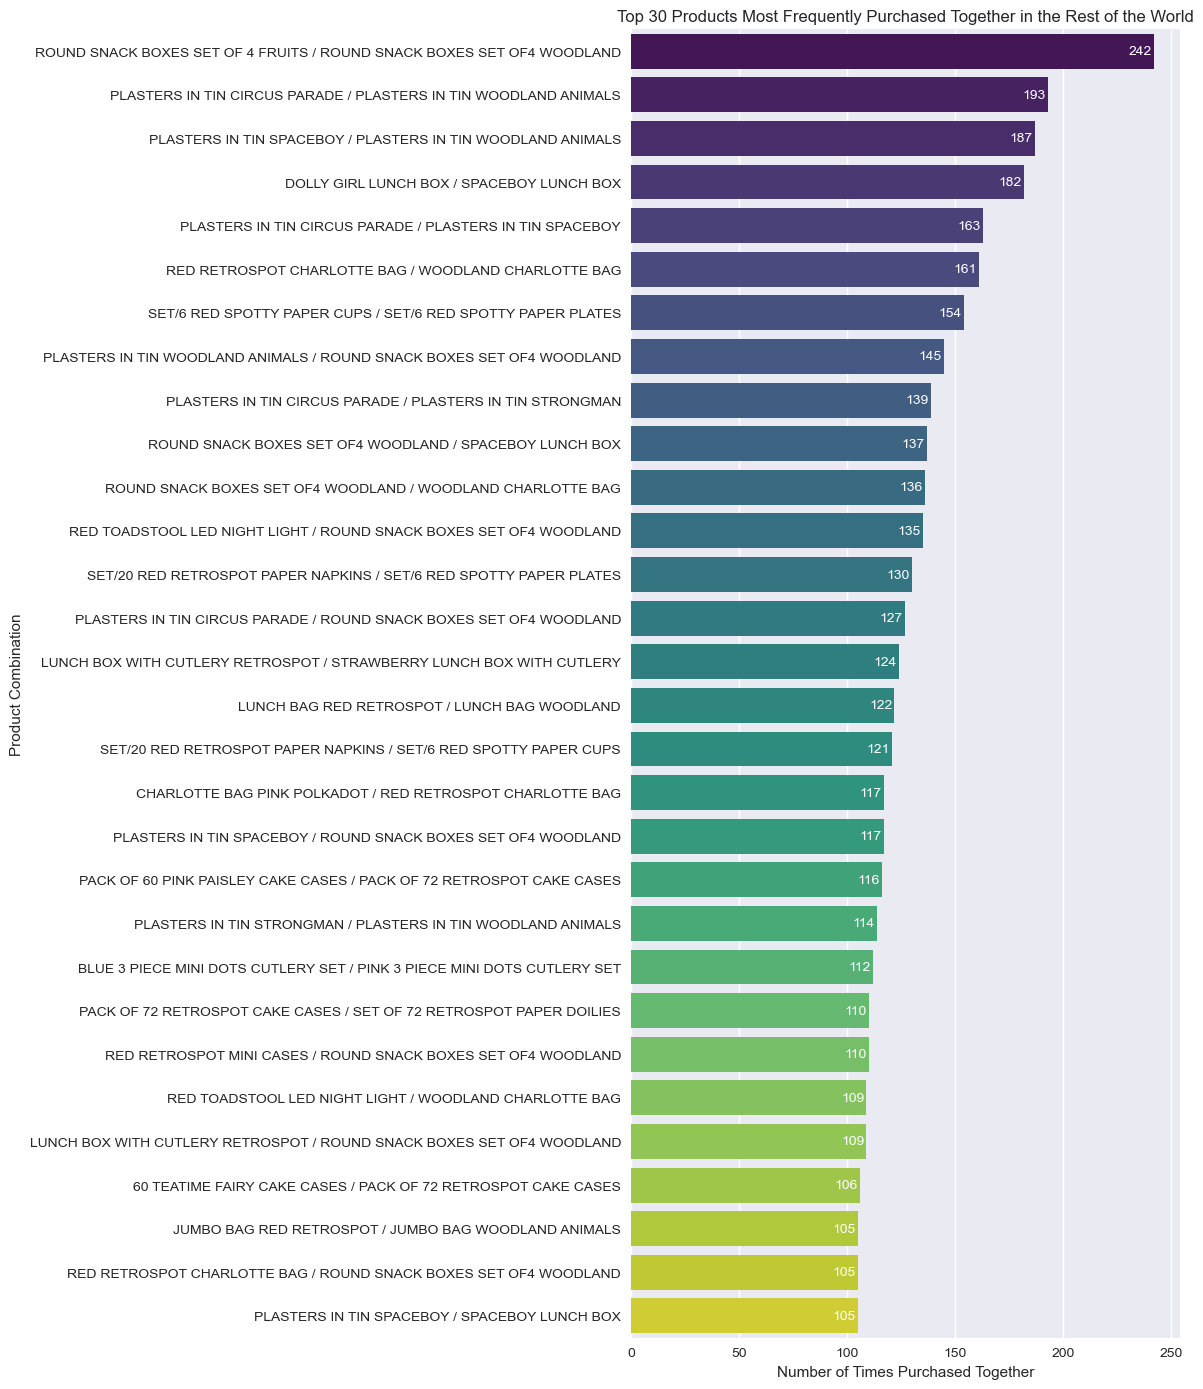

In [74]:
# Concatenating pairs
rw_top_pairs_df['Pairs'] = rw_top_pairs_df['Product A'] + ' / ' + rw_top_pairs_df['Product B']

# Validating integrity
df_check(rw_top_pairs_df, col_num='Count', col_text='Pairs', negative=False)

# Creating barplot
plt.figure(figsize=(12, 14))
ax = sns.barplot(
    data=rw_top_pairs_df,
    x='Count',
    y='Pairs',
    hue='Pairs',
    palette='viridis',
    legend=False
)

# Adding data labels
for i, value in enumerate(rw_top_pairs_df['Count']):
    ax.text(value-1, i, f'{value:,.0f}',
            va='center', ha='right', fontsize=10,
            color='white')

# Customizing chart format
plt.title('Top 30 Products Most Frequently Purchased Together in the Rest of the World')
plt.xlabel('Number of Times Purchased Together')
plt.ylabel('Product Combination')
plt.tight_layout()
plt.show()

In this market, a **completely different picture** emerges: almost none of the product combinations in the UK Top 10 appear among the 30 most frequently bought pairs in the rest of the world.

This result suggests the need to implement **segmented promotion strategies** for markets outside the UK.

---
## Conclusions and Recommendations

Below are the main findings obtained from the exploratory analysis, along with the limitations identified and recommendations for future steps.  

The objective is to synthesize the **key information** and guide potential actions based on the results.

---
### 13. Key Findings from the Analysis

After the exploratory analysis, the following conclusions can be drawn:

- **United Kingdom** is, by far, the main market for this e-commerce, concentrating **85.70%** of total sales.
- There are **two clearly differentiated market behaviors**: the UK versus the rest of the world, with the latter showing limited participation in overall sales.
- The product **"REGENCY CAKESTAND 3 TIER"** is the undisputed sales leader, even after accounting for returns. It is followed by **"WHITE HANGING HEART T-LIGHT HOLDER"**, second both in units sold and total revenue generated. Both products are far ahead of the rest in gross and net sales.
- The business shows a **cyclical sales pattern**, with peaks in the last months of the year and sharp slowdowns at the beginning of the next year.
- Returns represent **15.79%** of all invoices, below the industry average (20%).
- **13.80%** of net sales are not associated with a customer ID, making segmentation analysis more challenging.
- The **average ticket size** per invoice is £509.18 gross and £413.29 net. **The Netherlands** shows the **highest average ticket** (both gross and net), followed by Singapore and Australia. Its temporal evolution follows a pattern similar to sales, with some exceptions in January and December 2011.
- **Thursday** is the day with the highest sales volume and number of invoices processed.  
  **Saturday** shows the lowest activity (possibly serving only urgent or specific cases). Among weekdays, Friday records the lowest sales volume.
- In the **United Kingdom**, most orders are placed between **12 p.m. and 3 p.m.**, including Sundays. In the rest of the world, the peak occurs between **10 a.m. and 2 p.m.**, with an abrupt dip at 11 a.m., and no orders are placed on Sundays.
- Most of the **top returned items** are not among the top-selling products, which could indicate quality issues, inaccurate descriptions, or logistical problems in delivery.
- **Frequently bought-together items** usually belong to the same category, suggesting that the shopping basket is strongly influenced by product theme.

---
### 14. Analysis Limitations

While the analysis provides a clear view of business behavior, it is important to consider the following limitations and areas for improvement in future reviews:

- **Lack of cost information**: margins cannot be calculated, nor can real product profitability be assessed.
- **Unidentified customer sales**: 13.80% of net sales are not associated with a customer ID, limiting segmentation analysis.
- **Restricted time coverage**: the dataset only includes data between 2010 and 2011, preventing the evaluation of long-term trends.
- **Unavailable business variables**: there is no information about campaigns, discounts, inventory, or logistics costs that may influence sales.
- **Uneven geographic coverage**: the UK accounts for 85.70% of sales, reducing the representativeness of other markets.
- **Methodological scope**: the analysis focuses on descriptive exploratory techniques; predictive models, cohort analysis, or advanced segmentation were not included, representing an opportunity for deeper analysis in future phases.

---
### 15. Recommendations

The following recommendations are based on the **patterns and behaviors** detected in this dataset. Their purpose is to show how data analysis can be transformed into **practical proposals** that help **improve results**. The targets included are only examples, defined using both the values found in the analysis and general industry benchmarks.  

- **Leverage the November sales peak (Q4)**: Offer product bundles and propose complementary or premium items at checkout (upsell) to increase the average order value. Measure the impact by tracking changes in the average ticket size and the percentage of orders accepting the offer.
- **Reduce returns on top-selling products**: Review descriptions, product images, and packaging for the 5 products with the highest return rates. Goal: reduce returns by 20% within 60 days.
- **Increase customer identification at checkout**: Implement data capture (email or phone number) during the payment process, both online and in-store, to enable follow-up and deliver personalized promotions. Goal: reduce unidentified sales from 14% to 7% within three months.
- **Include cost information**: Collect and record unit cost and shipping expenses for each product to calculate true profitability and prioritize high-margin items.

---
### 16. Next Steps

The next step will be to develop an [**interactive dashboard in Power BI**](../reports/2_Overview.jpg) [(Download)](https://github.com/saul1832/online-retail-analytics/raw/refs/heads/main/powerbi/03_dashboard.pbix) that visually and dynamically displays the main metrics analyzed in this notebook, allowing non-technical users to explore the results.  